# WWT project - biochar filters for onsite wastewater treatment

Course version:

Section 1
- Moved section 1.1 and 1.2.2 to section 6 since they should not be run as part of set-up

Renamed variables:
- BN = Biochar bed filter, normal area
- BBS = Biochar bed filter, sensitive area
- BMS = Biochar modular filter, sensitive area
- SN = Sand filter, normal area
- SS = Sand filter, sensitive area
- C = Climate impact
- E = Eutrophication
- WPS = Wood pellet biochar, syngas-heated pyrolysis (Biochar 1)
- WPE = Wood pellet biochar, electricity-heated pyrolysis (Biochar 2)
- GWS = Garden waste biochar, syngas-heated pyrolysis (Biochar 3)
- GWE = Garden waste biochar, electricity-heated pyrolysis (Biochar 4)
- LR = Logging residues biochar (Biochar 5)
- (Biochar 6 not part of study)
- WC = Willow chips biochar
- CHP = Combined heat and power combustion (end-of-life)
- Heat = Heat-only combustion (end-of-life)
- LS = Landscaping soil (end-of-life)
- R = Renewable energy system
- F = Fossil energy system

Example:
- BN-C-LR-CHP-R = Biochar bed filter, normal area; climate impact; Logging residues as feedstock; combined heat and power as end-of-life; renewable energy system
- They are complex because the model is complex and the scenarios are 6*3*2 = 36, with normal and sensitive areas and three impact categories in addition to that.

Section 2 and 3 switched place since it makes more sense to put section 3 first.

Section 2 (this version)
- Removed old 3.1 and 3.2.7 that I don't use anymore
- Variables renamed
- Condensed code and use one function instead of two
- Save % and min-max in easier way

Section 3 (this version)
- Documentation improved
- Variables renamed
- Unneccessary commented lines removed
- In section 2.3, filter through parameters in scenario dfs in a more efficient way
- Removed old 2.4 that I did not finish

Section 4
- Renamed variables and removed duplicate code

Section 5
- No changes

Section 6
- Restructured this section to gather pieces of code that I have used to set up the model, but as the model is finished, they should not be run again

Possible trade-off - variables much shorter, but less obvious what they mean

Code used in article "Life cycle assessment of biochar filters for on-site wastewater treatment"

by

Zakrisson et al.

## set-up

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.available
style.use('seaborn')

import numpy as np
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from collections import defaultdict, OrderedDict
import brightway2 as bw2
from bw2data.parameters import ActivityParameter, ProjectParameter, DatabaseParameter, Group
import itertools

from IPython.display import display, Math

# Custom utils defined for inter-acv
from lca_algebraic import *
from lca_algebraic.stats import * 
import lca_algebraic as la
import re

from copy import deepcopy
from os.path import isfile

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_32688\374549200.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')
C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
project = 'wwt_new'
bw2.projects.set_current(project)
USER_DB = 'wwt_db'

In [3]:
# Impact categories 
## IPCC method GWP100
IPCC = [method for method in bw2.methods if "IPCC 2021" in str(method) 
        and "GWP100" in str(method) 
        and "biogenic" not in str(method)
        and "fossil" not in str(method)
        and "SLCFs" not in str(method)
        and "land use" not in str(method)
        and "LT" not in str(method)]
IPCC_unit = [r'kg $CO_2$-eq']

## Eutrophication TRACI
TRACI_eut = [method for method in bw2.methods if "TRACI" in str(method)
          and "eutrophication" in str(method)
          and "LT" not in str(method)
          ]

TRACI_eut_unit = [bw2.methods[method]['unit'] for method in TRACI_eut]

## Acidification CML
CML_acid = [method for method in bw2.methods if "CML v4.8" in str(method)
          and "acidification" in str(method)
          and "LT" not in str(method)
          ]

CML_acid_unit = [bw2.methods[method]['unit'] for method in CML_acid]


all_methods= IPCC + TRACI_eut + CML_acid
all_methods_units = IPCC_unit + TRACI_eut_unit + CML_acid_unit

In [4]:
BN = findActivity("BCBed Normal System", db_name=USER_DB)
BBS = findActivity("BCBed Sensitive System", db_name=USER_DB)
BMS = findActivity("BCMod Sensitive System", db_name=USER_DB)
SN = findActivity("Sand Normal System", db_name=USER_DB)
SS = findActivity("Sand Sensitive System", db_name=USER_DB)

In [5]:
climate_label = 'kg CO'+'$_{2}$' +'-eq / m' +'$^{3}$' +' wastewater'
eutroph_label = 'kg N-eq / m' +'$^{3}$' +' wastewater'
acid_label = 'kg SO'+'$_{2}$' +'-eq / m' +'$^{3}$' +' wastewater'

c_string = 'climate change - global warming potential (GWP100)'
e_string = 'eutrophication - eutrophication potential'
a_string = 'acidification - acidification (incl. fate, average Europe total, A&B)'

In [6]:
# If you get Value Error: 0 -> There's a parameter with Unknown uncertainty 
# change it to No uncertainty
loadParams()

10
elec_switch_param
heat_switch_param
sand_switch_param
bc_switch_param
EOL1and2_switch_param
EOL3and4_switch_param
EOL5and6_switch_param
EOL7_switch_param
bc_Seqswitch_param
bc_HLswitch_param


In [7]:
# define helping functions
def calcError(median, min_value, max_value):
    '''
    Calculates error margin based on min and max value - used later in plotting
    Input: median, min and max
    Output: an array with the differences between median and min and max values, respectively
    '''
    return np.array([median-min_value, max_value-median]).reshape((2,1))

In [8]:
def calcMinMaxMedianError(Y, column):
    '''
    Input: The dataframe and column heading
    Return min, max, median and error values in a column in a dataframe
    '''
    min_value = Y[column].min()
    max_value = Y[column].max()
    median = Y[column].median()
    error = calcError(median, min_value, max_value)
    return min_value, max_value, median, error

In [9]:
def calc_perc(col1, col2):
    '''
    Input: two df columns
    Returns: percentage of how many times col2 was lower (100% = 100 etc)
    '''    
    delta = col1 - col2
    alt1 = 0
    alt2 = 0
    for row in delta:
        if row > 0:
            alt2 += 1
        elif row < 0:
            alt1 += 1
    perc = alt2 / (alt1+alt2)
    return perc*100

### generate y:s and data

In [10]:
from lca_algebraic.stats import _stochastics
from lca_algebraic.stats import _compute_stochastics

In [14]:
problem1, params, Y1 = _stochastics(BN, all_methods, n=10000)

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


When we've gotten the params, no need to sample them again - and make sure that we're using the same ones

In [15]:
Y2 = _compute_stochastics(SN, all_methods, params)

In [16]:
Y3 = _compute_stochastics(BBS, all_methods, params)

Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


In [17]:
Y4 = _compute_stochastics(BMS, all_methods, params)

Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


In [18]:
Y5 = _compute_stochastics(SS, all_methods, params)

In [19]:
for Y in [Y1, Y2, Y3, Y4, Y5]: # change heading (make them shorter)
    Y.rename(columns={c_string: 'Climate', e_string: 'Eutroph.', a_string:'Acid.'}, inplace=True)

In [152]:
# BC Bed, Normal areas
BN_C_min, BN_C_max, BN_C_med, BN_C_e = calcMinMaxMedianError(Y1, 'Climate')
BN_E_min, BN_E_max, BN_E_med, BN_E_e = calcMinMaxMedianError(Y1, 'Eutroph.')
BN_A_min, BN_A_max, BN_A_med, BN_A_e = calcMinMaxMedianError(Y1, 'Acid.')

# Sand filter, normal areas
SN_C_min, SN_C_max, SN_C_med, SN_C_e = calcMinMaxMedianError(Y2, 'Climate')
SN_E_min, SN_E_max, SN_E_med, SN_E_e = calcMinMaxMedianError(Y2, 'Eutroph.')
SN_A_min, SN_A_max, SN_A_med, SN_A_e = calcMinMaxMedianError(Y2, 'Acid.')

# BC Bed, Sensitive areas
BBS_C_min, BBS_C_max, BBS_C_med, BBS_C_e = calcMinMaxMedianError(Y3, 'Climate')
BBS_E_min, BBS_E_max, BBS_E_med, BBS_E_e = calcMinMaxMedianError(Y3, 'Eutroph.')
BBS_A_min, BBS_A_max, BBS_A_med, BBS_A_e = calcMinMaxMedianError(Y3, 'Acid.')

# BC Mod, Sensitive areas
BMS_C_min, BMS_C_max, BMS_C_med, BMS_C_e = calcMinMaxMedianError(Y4, 'Climate')
BMS_E_min, BMS_E_max, BMS_E_med, BMS_E_e = calcMinMaxMedianError(Y4, 'Eutroph.')
BMS_A_min, BMS_A_max, BMS_A_med, BMS_A_e = calcMinMaxMedianError(Y4, 'Acid.')

# Sand filter, sensitive areas
SS_C_min, SS_C_max, SS_C_med, SS_C_e = calcMinMaxMedianError(Y5, 'Climate')
SS_E_min, SS_E_max, SS_E_med, SS_E_e = calcMinMaxMedianError(Y5, 'Eutroph.')
SS_A_min, SS_A_max, SS_A_med, SS_A_e = calcMinMaxMedianError(Y5, 'Acid.')

#### save excel sheet with all min and max (optional)

In [21]:
d = {'BedNormalClimate': [BN_minC, BN_maxC], 
     'BedNormalEutroph': [BN_minE, BN_maxE], 
     'BedNormalAcid': [BN_minA, BN_maxA],
     
     'BedSensitiveClimate': [BBS_minC, BBS_maxC], 
     'BedSensitiveEutroph': [BBS_minE, BBS_maxE], 
     'BedSensitiveAcid': [BBS_minA, BBS_maxA],
     
     'ModClimate': [BMS_minC, BMS_maxC], 
     'ModEutroph': [BMS_minE, BMS_maxE], 
     'ModAcid': [BMS_minA, BMS_maxA],
     
     'SandNormalClimate': [SN_minC, SN_maxC], 
     'SandNormalEutroph': [SN_minE, SN_maxE], 
     'SandNormalAcid': [SN_minA, SN_maxA],
     
     'SandSensitiveClimate': [SS_minC, SS_maxC], 
     'SandSensitiveEutroph': [SS_minE, SS_maxE], 
     'SandSensitiveAcid': [SS_minA, SS_maxA],
    }
min_max_df = pd.DataFrame(data=d, index = ['min', 'max'])

In [22]:
min_max_df

,BedNormalClimate,BedNormalEutroph,BedNormalAcid,BedSensitiveClimate,BedSensitiveEutroph,BedSensitiveAcid,ModClimate,ModEutroph,ModAcid,SandNormalClimate,SandNormalEutroph,SandNormalAcid,SandSensitiveClimate,SandSensitiveEutroph,SandSensitiveAcid
min,-28.959268,0.054926,-0.014630,-18.907025,0.029780,0.038981,-3.793688,0.026600,0.044572,3.213829,0.052793,0.035466,3.608215,0.050783,0.037958
max,30.847672,0.196112,0.092996,13.773668,0.132156,0.116933,13.611568,0.088907,0.084121,4.180903,0.117299,0.055161,4.575289,0.084163,0.057652


In [23]:
# save to Excel
with pd.ExcelWriter('MinMax.xlsx') as writer:  
    min_max_df.to_excel(writer, sheet_name='Sheet_name_1')

## scenarios

### Create and filter through the df:s

In [24]:
big_df = pd.DataFrame.from_dict(params)

In [25]:
big_df['BN_C'] = Y1['Climate'].values
big_df['BN_E'] = Y1['Eutroph.'].values
big_df['BN_A'] = Y1['Acid.'].values

In [26]:
big_df['SN_C'] = Y2['Climate'].values
big_df['SN_E'] = Y2['Eutroph.'].values
big_df['SN_A'] = Y2['Acid.'].values

In [27]:
big_df['BBS_C'] = Y3['Climate'].values
big_df['BBS_E'] = Y3['Eutroph.'].values
big_df['BBS_A'] = Y3['Acid.'].values

In [28]:
big_df['BMS_C'] = Y4['Climate'].values
big_df['BMS_E'] = Y4['Eutroph.'].values
big_df['BMS_A'] = Y4['Acid.'].values

In [29]:
big_df['SS_C'] = Y5['Climate'].values
big_df['SS_E'] = Y5['Eutroph.'].values
big_df['SS_A'] = Y5['Acid.'].values

In [30]:
# remove rows that are duplicates (but keep one of them) - (if we haven't done it earlier)
big_df= big_df.drop_duplicates(keep='first')

In [31]:
# Many of the params are constants, drop all cols that have same values
for col in big_df.columns:
    if len(big_df[col].unique()) == 1:
        big_df.drop(col,inplace=True,axis=1)

#### Different biochars

In [ ]:
WPS = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq')]

WPE = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq')]

GWS = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq')]

GWE = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq')]

LR = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq')]

WC = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq')]

#### different energy

In [ ]:
renew = big_df.loc[(big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]

fossil = big_df.loc[(big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]

#### different EOL

In [ ]:
CHP = big_df.loc[(big_df['EOL1and2_switch_param'] == 'CHP1') &
                    (big_df['EOL3and4_switch_param'] == 'CHP2') &
                    (big_df['EOL5and6_switch_param'] == 'CHP3') &                    
                    (big_df['EOL7_switch_param'] == 'CHP4')]

Heat = big_df.loc[(big_df['EOL1and2_switch_param'] == 'Heat1') &
                    (big_df['EOL3and4_switch_param'] == 'Heat2') &
                    (big_df['EOL5and6_switch_param'] == 'Heat3') &                    
                    (big_df['EOL7_switch_param'] == 'Heat4')]

LS = big_df.loc[(big_df['EOL1and2_switch_param'] == 'LS1') &
                    (big_df['EOL3and4_switch_param'] == 'LS2') &
                    (big_df['EOL5and6_switch_param'] == 'LS3') &                    
                    (big_df['EOL7_switch_param'] == 'LS4')]

### combine them all together

For BC bed in sensitive areas, all bc stays in the bed, so different eol won't matter -> for this bc, just use the bc and energy combination

(Also, only one of the three BC switches is used (bc_Seq))

In [34]:
WPS_F = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]
WPS_R = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]
WPE_F = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]
WPE_R = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]
GWS_F = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]
GWS_R = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]
GWE_F = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]
GWE_R = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]
LR_F = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]
LR_R = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]
WC_F = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal')]
WC_R = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower')]

In [52]:
WPS_F_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL1and2_switch_param'] == 'CHP1')]
WPS_R_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL1and2_switch_param'] == 'CHP1')]
WPE_F_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL1and2_switch_param'] == 'CHP1')]
WPE_R_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL1and2_switch_param'] == 'CHP1')]
GWS_F_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL3and4_switch_param'] == 'CHP2')]
GWS_R_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL3and4_switch_param'] == 'CHP2')]
GWE_F_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL3and4_switch_param'] == 'CHP2')]
GWE_R_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL3and4_switch_param'] == 'CHP2')]
LR_F_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL5and6_switch_param'] == 'CHP3')]
LR_R_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL5and6_switch_param'] == 'CHP3')]
WC_F_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL7_switch_param'] == 'CHP4')]
WC_R_CHP = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL7_switch_param'] == 'CHP4')]

In [54]:
WPS_F_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL1and2_switch_param'] == 'Heat1')]
WPS_R_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL1and2_switch_param'] == 'Heat1')]
WPE_F_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL1and2_switch_param'] == 'Heat1')]
WPE_R_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL1and2_switch_param'] == 'Heat1')]
GWS_F_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL3and4_switch_param'] == 'Heat2')]
GWS_R_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL3and4_switch_param'] == 'Heat2')]
GWE_F_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL3and4_switch_param'] == 'Heat2')]
GWE_R_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL3and4_switch_param'] == 'Heat2')]
LR_F_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL5and6_switch_param'] == 'Heat3')]
LR_R_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL5and6_switch_param'] == 'Heat3')]
WC_F_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL7_switch_param'] == 'Heat4')]
WC_R_Heat = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL7_switch_param'] == 'Heat4')]

In [55]:
WPS_F_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL1and2_switch_param'] == 'LS1')]
WPS_R_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc1') &
                    (big_df['bc_HLswitch_param'] == 'bc1HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc1Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL1and2_switch_param'] == 'LS1')]
WPE_F_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL1and2_switch_param'] == 'LS1')]
WPE_R_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc2') &
                    (big_df['bc_HLswitch_param'] == 'bc2HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc2Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL1and2_switch_param'] == 'LS1')]
GWS_F_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL3and4_switch_param'] == 'LS2')]
GWS_R_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc3') &
                    (big_df['bc_HLswitch_param'] == 'bc3HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc3Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL3and4_switch_param'] == 'LS2')]
GWE_F_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL3and4_switch_param'] == 'LS2')]
GWE_R_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc4') &
                    (big_df['bc_HLswitch_param'] == 'bc4HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc4Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL3and4_switch_param'] == 'LS2')]
LR_F_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL5and6_switch_param'] == 'LS3')]
LR_R_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc5') &
                    (big_df['bc_HLswitch_param'] == 'bc5HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc5Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL5and6_switch_param'] == 'LS3')]
WC_F_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatNaturalGas') &
                    (big_df['elec_switch_param'] == 'elecCoal') &
                    (big_df['EOL7_switch_param'] == 'LS4')]
WC_R_LS = big_df.loc[(big_df['bc_switch_param'] == 'bc7') &
                    (big_df['bc_HLswitch_param'] == 'bc7HL') &
                    (big_df['bc_Seqswitch_param'] == 'bc7Seq') &
                    (big_df['heat_switch_param'] == 'heatWoodchips') &
                    (big_df['elec_switch_param'] == 'elecWindpower') &
                    (big_df['EOL7_switch_param'] == 'LS4')]

#### calculate %

###### BC Bed sensitive

In [60]:
### BC Bed Sensitive ###
## Climate
BBS_C_WPS_F_d = calc_perc(WPS_F['SS_C'],WPS_F['BBS_C'])
BBS_C_WPS_R_d = calc_perc(WPS_R['SS_C'],WPS_R['BBS_C'])
BBS_C_WPE_F_d = calc_perc(WPE_F['SS_C'],WPE_F['BBS_C'])
BBS_C_WPE_R_d = calc_perc(WPE_R['SS_C'],WPE_R['BBS_C'])
BBS_C_GWS_F_d = calc_perc(GWS_F['SS_C'],GWS_F['BBS_C'])
BBS_C_GWS_R_d = calc_perc(GWS_R['SS_C'],GWS_R['BBS_C'])
BBS_C_GWE_F_d = calc_perc(GWE_F['SS_C'],GWE_F['BBS_C'])
BBS_C_GWE_R_d = calc_perc(GWE_R['SS_C'],GWE_R['BBS_C'])
BBS_C_LR_F_d = calc_perc(LR_F['SS_C'],LR_F['BBS_C'])
BBS_C_LR_R_d = calc_perc(LR_R['SS_C'],LR_R['BBS_C'])
BBS_C_WC_F_d = calc_perc(WC_F['SS_C'],WC_F['BBS_C'])
BBS_C_WC_R_d = calc_perc(WC_R['SS_C'],WC_R['BBS_C'])
## Eutrophication
BBS_E_WPS_F_d = calc_perc(WPS_F['SS_E'],WPS_F['BBS_E'])
BBS_E_WPS_R_d = calc_perc(WPS_R['SS_E'],WPS_R['BBS_E'])
BBS_E_WPE_F_d = calc_perc(WPE_F['SS_E'],WPE_F['BBS_E'])
BBS_E_WPE_R_d = calc_perc(WPE_R['SS_E'],WPE_R['BBS_E'])
BBS_E_GWS_F_d = calc_perc(GWS_F['SS_E'],GWS_F['BBS_E'])
BBS_E_GWS_R_d = calc_perc(GWS_R['SS_E'],GWS_R['BBS_E'])
BBS_E_GWE_F_d = calc_perc(GWE_F['SS_E'],GWE_F['BBS_E'])
BBS_E_GWE_R_d = calc_perc(GWE_R['SS_E'],GWE_R['BBS_E'])
BBS_E_LR_F_d = calc_perc(LR_F['SS_E'],LR_F['BBS_E'])
BBS_E_LR_R_d = calc_perc(LR_R['SS_E'],LR_R['BBS_E'])
BBS_E_WC_F_d = calc_perc(WC_F['SS_E'],WC_F['BBS_E'])
BBS_E_WC_R_d = calc_perc(WC_R['SS_E'],WC_R['BBS_E'])
## Acidification
BBS_A_WPS_F_d = calc_perc(WPS_F['SS_A'],WPS_F['BBS_A'])
BBS_A_WPS_R_d = calc_perc(WPS_R['SS_A'],WPS_R['BBS_A'])
BBS_A_WPE_F_d = calc_perc(WPE_F['SS_A'],WPE_F['BBS_A'])
BBS_A_WPE_R_d = calc_perc(WPE_R['SS_A'],WPE_R['BBS_A'])
BBS_A_GWS_F_d = calc_perc(GWS_F['SS_A'],GWS_F['BBS_A'])
BBS_A_GWS_R_d = calc_perc(GWS_R['SS_A'],GWS_R['BBS_A'])
BBS_A_GWE_F_d = calc_perc(GWE_F['SS_A'],GWE_F['BBS_A'])
BBS_A_GWE_R_d = calc_perc(GWE_R['SS_A'],GWE_R['BBS_A'])
BBS_A_LR_F_d = calc_perc(LR_F['SS_A'],LR_F['BBS_A'])
BBS_A_LR_R_d = calc_perc(LR_R['SS_A'],LR_R['BBS_A'])
BBS_A_WC_F_d = calc_perc(WC_F['SS_A'],WC_F['BBS_A'])
BBS_A_WC_R_d = calc_perc(WC_R['SS_A'],WC_R['BBS_A'])
### BC Bed Normal ###
## Climate
# WPS (WPS)
BN_C_WPS_F_CHP_d = calc_perc(WPS_F_CHP['SN_C'],WPS_F_CHP['BN_C'])
BN_C_WPS_R_CHP_d = calc_perc(WPS_R_CHP['SN_C'],WPS_R_CHP['BN_C'])
BN_C_WPS_F_Heat_d = calc_perc(WPS_F_Heat['SN_C'],WPS_F_Heat['BN_C'])
BN_C_WPS_R_Heat_d = calc_perc(WPS_R_Heat['SN_C'],WPS_R_Heat['BN_C'])
BN_C_WPS_F_LS_d = calc_perc(WPS_F_LS['SN_C'],WPS_F_LS['BN_C'])
BN_C_WPS_R_LS_d = calc_perc(WPS_R_LS['SN_C'],WPS_R_LS['BN_C'])
# WPE (WPE)
BN_C_WPE_F_CHP_d = calc_perc(WPE_F_CHP['SN_C'],WPE_F_CHP['BN_C'])
BN_C_WPE_R_CHP_d = calc_perc(WPE_R_CHP['SN_C'],WPE_R_CHP['BN_C'])
BN_C_WPE_F_Heat_d = calc_perc(WPE_F_Heat['SN_C'],WPE_F_Heat['BN_C'])
BN_C_WPE_R_Heat_d = calc_perc(WPE_R_Heat['SN_C'],WPE_R_Heat['BN_C'])
BN_C_WPE_F_LS_d = calc_perc(WPE_F_LS['SN_C'],WPE_F_LS['BN_C'])
BN_C_WPE_R_LS_d = calc_perc(WPE_R_LS['SN_C'],WPE_R_LS['BN_C'])
# GWS (GWS)
BN_C_GWS_F_CHP = calc_perc(GWS_F_CHP['SN_C'],GWS_F_CHP['BN_C'])
BN_C_GWS_R_CHP_d = calc_perc(GWS_R_CHP['SN_C'],GWS_R_CHP['BN_C'])
BN_C_GWS_F_Heat_d = calc_perc(GWS_F_Heat['SN_C'],GWS_F_Heat['BN_C'])
BN_C_GWS_R_Heat_d = calc_perc(GWS_R_Heat['SN_C'],GWS_R_Heat['BN_C'])
BN_C_GWS_F_LS_d = calc_perc(GWS_F_LS['SN_C'],GWS_F_LS['BN_C'])
BN_C_GWS_R_LS_d = calc_perc(GWS_R_LS['SN_C'],GWS_R_LS['BN_C'])
# GWE (GWE)
BN_C_GWE_F_CHP_d = calc_perc(GWE_F_CHP['SN_C'],GWE_F_CHP['BN_C'])
BN_C_GWE_R_CHP_d = calc_perc(GWE_R_CHP['SN_C'],GWE_R_CHP['BN_C'])
BN_C_GWE_F_Heat_d = calc_perc(GWE_F_Heat['SN_C'],GWE_F_Heat['BN_C'])
BN_C_GWE_R_Heat_d = calc_perc(GWE_R_Heat['SN_C'],GWE_R_Heat['BN_C'])
BN_C_GWE_F_LS_d = calc_perc(GWE_F_LS['SN_C'],GWE_F_LS['BN_C'])
BN_C_GWE_R_LS_d = calc_perc(GWE_R_LS['SN_C'],GWE_R_LS['BN_C'])
# LR (LR)
BN_C_LR_F_CHP_d = calc_perc(LR_F_CHP['SN_C'],LR_F_CHP['BN_C'])
BN_C_LR_R_CHP_d = calc_perc(LR_R_CHP['SN_C'],LR_R_CHP['BN_C'])
BN_C_LR_F_Heat_d = calc_perc(LR_F_Heat['SN_C'],LR_F_Heat['BN_C'])
BN_C_LR_R_Heat_d = calc_perc(LR_R_Heat['SN_C'],LR_R_Heat['BN_C'])
BN_C_LR_F_LS_d = calc_perc(LR_F_LS['SN_C'],LR_F_LS['BN_C'])
BN_C_LR_R_LS_d = calc_perc(LR_R_LS['SN_C'],LR_R_LS['BN_C'])
# WC (WC)
BN_C_WC_F_CHP_d = calc_perc(WC_F_CHP['SN_C'],WC_F_CHP['BN_C'])
BN_C_WC_R_CHP_d = calc_perc(WC_R_CHP['SN_C'],WC_R_CHP['BN_C'])
BN_C_WC_F_Heat_d = calc_perc(WC_F_Heat['SN_C'],WC_F_Heat['BN_C'])
BN_C_WC_R_Heat_d = calc_perc(WC_R_Heat['SN_C'],WC_R_Heat['BN_C'])
BN_C_WC_F_LS_d = calc_perc(WC_F_LS['SN_C'],WC_F_LS['BN_C'])
BN_C_WC_R_LS_d = calc_perc(WC_R_LS['SN_C'],WC_R_LS['BN_C'])
## Eutrophication
# WPS (WPS)
BN_E_WPS_F_CHP_d = calc_perc(WPS_F_CHP['SN_E'],WPS_F_CHP['BN_E'])
BN_E_WPS_R_CHP_d = calc_perc(WPS_R_CHP['SN_E'],WPS_R_CHP['BN_E'])
BN_E_WPS_F_Heat_d = calc_perc(WPS_F_Heat['SN_E'],WPS_F_Heat['BN_E'])
BN_E_WPS_R_Heat_d = calc_perc(WPS_R_Heat['SN_E'],WPS_R_Heat['BN_E'])
BN_E_WPS_F_LS_d = calc_perc(WPS_F_LS['SN_E'],WPS_F_LS['BN_E'])
BN_E_WPS_R_LS_d = calc_perc(WPS_R_LS['SN_E'],WPS_R_LS['BN_E'])
# WPE (WPE)
BN_E_WPE_F_CHP_d = calc_perc(WPE_F_CHP['SN_E'],WPE_F_CHP['BN_E'])
BN_E_WPE_R_CHP_d = calc_perc(WPE_R_CHP['SN_E'],WPE_R_CHP['BN_E'])
BN_E_WPE_F_Heat_d = calc_perc(WPE_F_Heat['SN_E'],WPE_F_Heat['BN_E'])
BN_E_WPE_R_Heat_d = calc_perc(WPE_R_Heat['SN_E'],WPE_R_Heat['BN_E'])
BN_E_WPE_F_LS_d = calc_perc(WPE_F_LS['SN_E'],WPE_F_LS['BN_E'])
BN_E_WPE_R_LS_d = calc_perc(WPE_R_LS['SN_E'],WPE_R_LS['BN_E'])
# GWS (GWS)
BN_E_GWS_F_CHP = calc_perc(GWS_F_CHP['SN_E'],GWS_F_CHP['BN_E'])
BN_E_GWS_R_CHP_d = calc_perc(GWS_R_CHP['SN_E'],GWS_R_CHP['BN_E'])
BN_E_GWS_F_Heat_d = calc_perc(GWS_F_Heat['SN_E'],GWS_F_Heat['BN_E'])
BN_E_GWS_R_Heat_d = calc_perc(GWS_R_Heat['SN_E'],GWS_R_Heat['BN_E'])
BN_E_GWS_F_LS_d = calc_perc(GWS_F_LS['SN_E'],GWS_F_LS['BN_E'])
BN_E_GWS_R_LS_d = calc_perc(GWS_R_LS['SN_E'],GWS_R_LS['BN_E'])
# GWE (GWE)
BN_E_GWE_F_CHP_d = calc_perc(GWE_F_CHP['SN_E'],GWE_F_CHP['BN_E'])
BN_E_GWE_R_CHP_d = calc_perc(GWE_R_CHP['SN_E'],GWE_R_CHP['BN_E'])
BN_E_GWE_F_Heat_d = calc_perc(GWE_F_Heat['SN_E'],GWE_F_Heat['BN_E'])
BN_E_GWE_R_Heat_d = calc_perc(GWE_R_Heat['SN_E'],GWE_R_Heat['BN_E'])
BN_E_GWE_F_LS_d = calc_perc(GWE_F_LS['SN_E'],GWE_F_LS['BN_E'])
BN_E_GWE_R_LS_d = calc_perc(GWE_R_LS['SN_E'],GWE_R_LS['BN_E'])
# LR (LR)
BN_E_LR_F_CHP_d = calc_perc(LR_F_CHP['SN_E'],LR_F_CHP['BN_E'])
BN_E_LR_R_CHP_d = calc_perc(LR_R_CHP['SN_E'],LR_R_CHP['BN_E'])
BN_E_LR_F_Heat_d = calc_perc(LR_F_Heat['SN_E'],LR_F_Heat['BN_E'])
BN_E_LR_R_Heat_d = calc_perc(LR_R_Heat['SN_E'],LR_R_Heat['BN_E'])
BN_E_LR_F_LS_d = calc_perc(LR_F_LS['SN_E'],LR_F_LS['BN_E'])
BN_E_LR_R_LS_d = calc_perc(LR_R_LS['SN_E'],LR_R_LS['BN_E'])
# WC (WC)
BN_E_WC_F_CHP_d = calc_perc(WC_F_CHP['SN_E'],WC_F_CHP['BN_E'])
BN_E_WC_R_CHP_d = calc_perc(WC_R_CHP['SN_E'],WC_R_CHP['BN_E'])
BN_E_WC_F_Heat_d = calc_perc(WC_F_Heat['SN_E'],WC_F_Heat['BN_E'])
BN_E_WC_R_Heat_d = calc_perc(WC_R_Heat['SN_E'],WC_R_Heat['BN_E'])
BN_E_WC_F_LS_d = calc_perc(WC_F_LS['SN_E'],WC_F_LS['BN_E'])
BN_E_WC_R_LS_d = calc_perc(WC_R_LS['SN_E'],WC_R_LS['BN_E'])
## Acidification
# WPS (WPS)
BN_A_WPS_F_CHP_d = calc_perc(WPS_F_CHP['SN_A'],WPS_F_CHP['BN_A'])
BN_A_WPS_R_CHP_d = calc_perc(WPS_R_CHP['SN_A'],WPS_R_CHP['BN_A'])
BN_A_WPS_F_Heat_d = calc_perc(WPS_F_Heat['SN_A'],WPS_F_Heat['BN_A'])
BN_A_WPS_R_Heat_d = calc_perc(WPS_R_Heat['SN_A'],WPS_R_Heat['BN_A'])
BN_A_WPS_F_LS_d = calc_perc(WPS_F_LS['SN_A'],WPS_F_LS['BN_A'])
BN_A_WPS_R_LS_d = calc_perc(WPS_R_LS['SN_A'],WPS_R_LS['BN_A'])
# WPE (WPE)
BN_A_WPE_F_CHP_d = calc_perc(WPE_F_CHP['SN_A'],WPE_F_CHP['BN_A'])
BN_A_WPE_R_CHP_d = calc_perc(WPE_R_CHP['SN_A'],WPE_R_CHP['BN_A'])
BN_A_WPE_F_Heat_d = calc_perc(WPE_F_Heat['SN_A'],WPE_F_Heat['BN_A'])
BN_A_WPE_R_Heat_d = calc_perc(WPE_R_Heat['SN_A'],WPE_R_Heat['BN_A'])
BN_A_WPE_F_LS_d = calc_perc(WPE_F_LS['SN_A'],WPE_F_LS['BN_A'])
BN_A_WPE_R_LS_d = calc_perc(WPE_R_LS['SN_A'],WPE_R_LS['BN_A'])
# GWS (GWS)
BN_A_GWS_F_CHP = calc_perc(GWS_F_CHP['SN_A'],GWS_F_CHP['BN_A'])
BN_A_GWS_R_CHP_d = calc_perc(GWS_R_CHP['SN_A'],GWS_R_CHP['BN_A'])
BN_A_GWS_F_Heat_d = calc_perc(GWS_F_Heat['SN_A'],GWS_F_Heat['BN_A'])
BN_A_GWS_R_Heat_d = calc_perc(GWS_R_Heat['SN_A'],GWS_R_Heat['BN_A'])
BN_A_GWS_F_LS_d = calc_perc(GWS_F_LS['SN_A'],GWS_F_LS['BN_A'])
BN_A_GWS_R_LS_d = calc_perc(GWS_R_LS['SN_A'],GWS_R_LS['BN_A'])
# GWE (GWE)
BN_A_GWE_F_CHP_d = calc_perc(GWE_F_CHP['SN_A'],GWE_F_CHP['BN_A'])
BN_A_GWE_R_CHP_d = calc_perc(GWE_R_CHP['SN_A'],GWE_R_CHP['BN_A'])
BN_A_GWE_F_Heat_d = calc_perc(GWE_F_Heat['SN_A'],GWE_F_Heat['BN_A'])
BN_A_GWE_R_Heat_d = calc_perc(GWE_R_Heat['SN_A'],GWE_R_Heat['BN_A'])
BN_A_GWE_F_LS_d = calc_perc(GWE_F_LS['SN_A'],GWE_F_LS['BN_A'])
BN_A_GWE_R_LS_d = calc_perc(GWE_R_LS['SN_A'],GWE_R_LS['BN_A'])
# LR (LR)
BN_A_LR_F_CHP_d = calc_perc(LR_F_CHP['SN_A'],LR_F_CHP['BN_A'])
BN_A_LR_R_CHP_d = calc_perc(LR_R_CHP['SN_A'],LR_R_CHP['BN_A'])
BN_A_LR_F_Heat_d = calc_perc(LR_F_Heat['SN_A'],LR_F_Heat['BN_A'])
BN_A_LR_R_Heat_d = calc_perc(LR_R_Heat['SN_A'],LR_R_Heat['BN_A'])
BN_A_LR_F_LS_d = calc_perc(LR_F_LS['SN_A'],LR_F_LS['BN_A'])
BN_A_LR_R_LS_d = calc_perc(LR_R_LS['SN_A'],LR_R_LS['BN_A'])
# WC (WC)
BN_A_WC_F_CHP_d = calc_perc(WC_F_CHP['SN_A'],WC_F_CHP['BN_A'])
BN_A_WC_R_CHP_d = calc_perc(WC_R_CHP['SN_A'],WC_R_CHP['BN_A'])
BN_A_WC_F_Heat_d = calc_perc(WC_F_Heat['SN_A'],WC_F_Heat['BN_A'])
BN_A_WC_R_Heat_d = calc_perc(WC_R_Heat['SN_A'],WC_R_Heat['BN_A'])
BN_A_WC_F_LS_d = calc_perc(WC_F_LS['SN_A'],WC_F_LS['BN_A'])
BN_A_WC_R_LS_d = calc_perc(WC_R_LS['SN_A'],WC_R_LS['BN_A'])
### Modular biochar filter
## Climate impact
# WPS (WPS)
BMS_C_WPS_F_CHP_d = calc_perc(WPS_F_CHP['SS_C'],WPS_F_CHP['BMS_C'])
BMS_C_WPS_R_CHP_d = calc_perc(WPS_R_CHP['SS_C'],WPS_R_CHP['BMS_C'])
BMS_C_WPS_F_Heat_d = calc_perc(WPS_F_Heat['SS_C'],WPS_F_Heat['BMS_C'])
BMS_C_WPS_R_Heat_d = calc_perc(WPS_R_Heat['SS_C'],WPS_R_Heat['BMS_C'])
BMS_C_WPS_F_LS_d = calc_perc(WPS_F_LS['SS_C'],WPS_F_LS['BMS_C'])
BMS_C_WPS_R_LS_d = calc_perc(WPS_R_LS['SS_C'],WPS_R_LS['BMS_C'])
# WPE (WPE)
BMS_C_WPE_F_CHP_d = calc_perc(WPE_F_CHP['SS_C'],WPE_F_CHP['BMS_C'])
BMS_C_WPE_R_CHP_d = calc_perc(WPE_R_CHP['SS_C'],WPE_R_CHP['BMS_C'])
BMS_C_WPE_F_Heat_d = calc_perc(WPE_F_Heat['SS_C'],WPE_F_Heat['BMS_C'])
BMS_C_WPE_R_Heat_d = calc_perc(WPE_R_Heat['SS_C'],WPE_R_Heat['BMS_C'])
BMS_C_WPE_F_LS_d = calc_perc(WPE_F_LS['SS_C'],WPE_F_LS['BMS_C'])
BMS_C_WPE_R_LS_d = calc_perc(WPE_R_LS['SS_C'],WPE_R_LS['BMS_C'])
# GWS (GWS)
BMS_C_GWS_F_CHP = calc_perc(GWS_F_CHP['SS_C'],GWS_F_CHP['BMS_C'])
BMS_C_GWS_R_CHP_d = calc_perc(GWS_R_CHP['SS_C'],GWS_R_CHP['BMS_C'])
BMS_C_GWS_F_Heat_d = calc_perc(GWS_F_Heat['SS_C'],GWS_F_Heat['BMS_C'])
BMS_C_GWS_R_Heat_d = calc_perc(GWS_R_Heat['SS_C'],GWS_R_Heat['BMS_C'])
BMS_C_GWS_F_LS_d = calc_perc(GWS_F_LS['SS_C'],GWS_F_LS['BMS_C'])
BMS_C_GWS_R_LS_d = calc_perc(GWS_R_LS['SS_C'],GWS_R_LS['BMS_C'])
# GWE (GWE)
BMS_C_GWE_F_CHP_d = calc_perc(GWE_F_CHP['SS_C'],GWE_F_CHP['BMS_C'])
BMS_C_GWE_R_CHP_d = calc_perc(GWE_R_CHP['SS_C'],GWE_R_CHP['BMS_C'])
BMS_C_GWE_F_Heat_d = calc_perc(GWE_F_Heat['SS_C'],GWE_F_Heat['BMS_C'])
BMS_C_GWE_R_Heat_d = calc_perc(GWE_R_Heat['SS_C'],GWE_R_Heat['BMS_C'])
BMS_C_GWE_F_LS_d = calc_perc(GWE_F_LS['SS_C'],GWE_F_LS['BMS_C'])
BMS_C_GWE_R_LS_d = calc_perc(GWE_R_LS['SS_C'],GWE_R_LS['BMS_C'])
# LR (LR)
BMS_C_LR_F_CHP_d = calc_perc(LR_F_CHP['SS_C'],LR_F_CHP['BMS_C'])
BMS_C_LR_R_CHP_d = calc_perc(LR_R_CHP['SS_C'],LR_R_CHP['BMS_C'])
BMS_C_LR_F_Heat_d = calc_perc(LR_F_Heat['SS_C'],LR_F_Heat['BMS_C'])
BMS_C_LR_R_Heat_d = calc_perc(LR_R_Heat['SS_C'],LR_R_Heat['BMS_C'])
BMS_C_LR_F_LS_d = calc_perc(LR_F_LS['SS_C'],LR_F_LS['BMS_C'])
BMS_C_LR_R_LS_d = calc_perc(LR_R_LS['SS_C'],LR_R_LS['BMS_C'])
# WC (WC)
BMS_C_WC_F_CHP_d = calc_perc(WC_F_CHP['SS_C'],WC_F_CHP['BMS_C'])
BMS_C_WC_R_CHP_d = calc_perc(WC_R_CHP['SS_C'],WC_R_CHP['BMS_C'])
BMS_C_WC_F_Heat_d = calc_perc(WC_F_Heat['SS_C'],WC_F_Heat['BMS_C'])
BMS_C_WC_R_Heat_d = calc_perc(WC_R_Heat['SS_C'],WC_R_Heat['BMS_C'])
BMS_C_WC_F_LS_d = calc_perc(WC_F_LS['SS_C'],WC_F_LS['BMS_C'])
BMS_C_WC_R_LS_d = calc_perc(WC_R_LS['SS_C'],WC_R_LS['BMS_C'])
## Eutrophication
# WPS (WPS)
BMS_E_WPS_F_CHP_d = calc_perc(WPS_F_CHP['SS_E'],WPS_F_CHP['BMS_E'])
BMS_E_WPS_R_CHP_d = calc_perc(WPS_R_CHP['SS_E'],WPS_R_CHP['BMS_E'])
BMS_E_WPS_F_Heat_d = calc_perc(WPS_F_Heat['SS_E'],WPS_F_Heat['BMS_E'])
BMS_E_WPS_R_Heat_d = calc_perc(WPS_R_Heat['SS_E'],WPS_R_Heat['BMS_E'])
BMS_E_WPS_F_LS_d = calc_perc(WPS_F_LS['SS_E'],WPS_F_LS['BMS_E'])
BMS_E_WPS_R_LS_d = calc_perc(WPS_R_LS['SS_E'],WPS_R_LS['BMS_E'])
# WPE (WPE)
BMS_E_WPE_F_CHP_d = calc_perc(WPE_F_CHP['SS_E'],WPE_F_CHP['BMS_E'])
BMS_E_WPE_R_CHP_d = calc_perc(WPE_R_CHP['SS_E'],WPE_R_CHP['BMS_E'])
BMS_E_WPE_F_Heat_d = calc_perc(WPE_F_Heat['SS_E'],WPE_F_Heat['BMS_E'])
BMS_E_WPE_R_Heat_d = calc_perc(WPE_R_Heat['SS_E'],WPE_R_Heat['BMS_E'])
BMS_E_WPE_F_LS_d = calc_perc(WPE_F_LS['SS_E'],WPE_F_LS['BMS_E'])
BMS_E_WPE_R_LS_d = calc_perc(WPE_R_LS['SS_E'],WPE_R_LS['BMS_E'])
# GWS (GWS)
BMS_E_GWS_F_CHP = calc_perc(GWS_F_CHP['SS_E'],GWS_F_CHP['BMS_E'])
BMS_E_GWS_R_CHP_d = calc_perc(GWS_R_CHP['SS_E'],GWS_R_CHP['BMS_E'])
BMS_E_GWS_F_Heat_d = calc_perc(GWS_F_Heat['SS_E'],GWS_F_Heat['BMS_E'])
BMS_E_GWS_R_Heat_d = calc_perc(GWS_R_Heat['SS_E'],GWS_R_Heat['BMS_E'])
BMS_E_GWS_F_LS_d = calc_perc(GWS_F_LS['SS_E'],GWS_F_LS['BMS_E'])
BMS_E_GWS_R_LS_d = calc_perc(GWS_R_LS['SS_E'],GWS_R_LS['BMS_E'])
# GWE (GWE)
BMS_E_GWE_F_CHP_d = calc_perc(GWE_F_CHP['SS_E'],GWE_F_CHP['BMS_E'])
BMS_E_GWE_R_CHP_d = calc_perc(GWE_R_CHP['SS_E'],GWE_R_CHP['BMS_E'])
BMS_E_GWE_F_Heat_d = calc_perc(GWE_F_Heat['SS_E'],GWE_F_Heat['BMS_E'])
BMS_E_GWE_R_Heat_d = calc_perc(GWE_R_Heat['SS_E'],GWE_R_Heat['BMS_E'])
BMS_E_GWE_F_LS_d = calc_perc(GWE_F_LS['SS_E'],GWE_F_LS['BMS_E'])
BMS_E_GWE_R_LS_d = calc_perc(GWE_R_LS['SS_E'],GWE_R_LS['BMS_E'])
# LR (LR)
BMS_E_LR_F_CHP_d = calc_perc(LR_F_CHP['SS_E'],LR_F_CHP['BMS_E'])
BMS_E_LR_R_CHP_d = calc_perc(LR_R_CHP['SS_E'],LR_R_CHP['BMS_E'])
BMS_E_LR_F_Heat_d = calc_perc(LR_F_Heat['SS_E'],LR_F_Heat['BMS_E'])
BMS_E_LR_R_Heat_d = calc_perc(LR_R_Heat['SS_E'],LR_R_Heat['BMS_E'])
BMS_E_LR_F_LS_d = calc_perc(LR_F_LS['SS_E'],LR_F_LS['BMS_E'])
BMS_E_LR_R_LS_d = calc_perc(LR_R_LS['SS_E'],LR_R_LS['BMS_E'])
# WC (WC)
BMS_E_WC_F_CHP_d = calc_perc(WC_F_CHP['SS_E'],WC_F_CHP['BMS_E'])
BMS_E_WC_R_CHP_d = calc_perc(WC_R_CHP['SS_E'],WC_R_CHP['BMS_E'])
BMS_E_WC_F_Heat_d = calc_perc(WC_F_Heat['SS_E'],WC_F_Heat['BMS_E'])
BMS_E_WC_R_Heat_d = calc_perc(WC_R_Heat['SS_E'],WC_R_Heat['BMS_E'])
BMS_E_WC_F_LS_d = calc_perc(WC_F_LS['SS_E'],WC_F_LS['BMS_E'])
BMS_E_WC_R_LS_d = calc_perc(WC_R_LS['SS_E'],WC_R_LS['BMS_E'])
## Acidification
# WPS (WPS)
BMS_A_WPS_F_CHP_d = calc_perc(WPS_F_CHP['SS_A'],WPS_F_CHP['BMS_A'])
BMS_A_WPS_R_CHP_d = calc_perc(WPS_R_CHP['SS_A'],WPS_R_CHP['BMS_A'])
BMS_A_WPS_F_Heat_d = calc_perc(WPS_F_Heat['SS_A'],WPS_F_Heat['BMS_A'])
BMS_A_WPS_R_Heat_d = calc_perc(WPS_R_Heat['SS_A'],WPS_R_Heat['BMS_A'])
BMS_A_WPS_F_LS_d = calc_perc(WPS_F_LS['SS_A'],WPS_F_LS['BMS_A'])
BMS_A_WPS_R_LS_d = calc_perc(WPS_R_LS['SS_A'],WPS_R_LS['BMS_A'])
# WPE (WPE)
BMS_A_WPE_F_CHP_d = calc_perc(WPE_F_CHP['SS_A'],WPE_F_CHP['BMS_A'])
BMS_A_WPE_R_CHP_d = calc_perc(WPE_R_CHP['SS_A'],WPE_R_CHP['BMS_A'])
BMS_A_WPE_F_Heat_d = calc_perc(WPE_F_Heat['SS_A'],WPE_F_Heat['BMS_A'])
BMS_A_WPE_R_Heat_d = calc_perc(WPE_R_Heat['SS_A'],WPE_R_Heat['BMS_A'])
BMS_A_WPE_F_LS_d = calc_perc(WPE_F_LS['SS_A'],WPE_F_LS['BMS_A'])
BMS_A_WPE_R_LS_d = calc_perc(WPE_R_LS['SS_A'],WPE_R_LS['BMS_A'])
# GWS (GWS)
BMS_A_GWS_F_CHP = calc_perc(GWS_F_CHP['SS_A'],GWS_F_CHP['BMS_A'])
BMS_A_GWS_R_CHP_d = calc_perc(GWS_R_CHP['SS_A'],GWS_R_CHP['BMS_A'])
BMS_A_GWS_F_Heat_d = calc_perc(GWS_F_Heat['SS_A'],GWS_F_Heat['BMS_A'])
BMS_A_GWS_R_Heat_d = calc_perc(GWS_R_Heat['SS_A'],GWS_R_Heat['BMS_A'])
BMS_A_GWS_F_LS_d = calc_perc(GWS_F_LS['SS_A'],GWS_F_LS['BMS_A'])
BMS_A_GWS_R_LS_d = calc_perc(GWS_R_LS['SS_A'],GWS_R_LS['BMS_A'])
# GWE (GWE)
BMS_A_GWE_F_CHP_d = calc_perc(GWE_F_CHP['SS_A'],GWE_F_CHP['BMS_A'])
BMS_A_GWE_R_CHP_d = calc_perc(GWE_R_CHP['SS_A'],GWE_R_CHP['BMS_A'])
BMS_A_GWE_F_Heat_d = calc_perc(GWE_F_Heat['SS_A'],GWE_F_Heat['BMS_A'])
BMS_A_GWE_R_Heat_d = calc_perc(GWE_R_Heat['SS_A'],GWE_R_Heat['BMS_A'])
BMS_A_GWE_F_LS_d = calc_perc(GWE_F_LS['SS_A'],GWE_F_LS['BMS_A'])
BMS_A_GWE_R_LS_d = calc_perc(GWE_R_LS['SS_A'],GWE_R_LS['BMS_A'])
# LR (LR)
BMS_A_LR_F_CHP_d = calc_perc(LR_F_CHP['SS_A'],LR_F_CHP['BMS_A'])
BMS_A_LR_R_CHP_d = calc_perc(LR_R_CHP['SS_A'],LR_R_CHP['BMS_A'])
BMS_A_LR_F_Heat_d = calc_perc(LR_F_Heat['SS_A'],LR_F_Heat['BMS_A'])
BMS_A_LR_R_Heat_d = calc_perc(LR_R_Heat['SS_A'],LR_R_Heat['BMS_A'])
BMS_A_LR_F_LS_d = calc_perc(LR_F_LS['SS_A'],LR_F_LS['BMS_A'])
BMS_A_LR_R_LS_d = calc_perc(LR_R_LS['SS_A'],LR_R_LS['BMS_A'])
# WC (WC)
BMS_A_WC_F_CHP_d = calc_perc(WC_F_CHP['SS_A'],WC_F_CHP['BMS_A'])
BMS_A_WC_R_CHP_d = calc_perc(WC_R_CHP['SS_A'],WC_R_CHP['BMS_A'])
BMS_A_WC_F_Heat_d = calc_perc(WC_F_Heat['SS_A'],WC_F_Heat['BMS_A'])
BMS_A_WC_R_Heat_d = calc_perc(WC_R_Heat['SS_A'],WC_R_Heat['BMS_A'])
BMS_A_WC_F_LS_d = calc_perc(WC_F_LS['SS_A'],WC_F_LS['BMS_A'])
BMS_A_WC_R_LS_d = calc_perc(WC_R_LS['SS_A'],WC_R_LS['BMS_A'])

#### save %

In [93]:
BN_perc_data = [[BN_C_WPS_F_CHP_d, BN_C_WPE_F_CHP_d, BN_C_GWS_F_CHP, BN_C_GWE_F_CHP_d, BN_C_LR_F_CHP_d, BN_C_WC_F_CHP_d,
     BN_E_WPS_F_CHP_d, BN_E_WPE_F_CHP_d, BN_E_GWS_F_CHP, BN_E_GWE_F_CHP_d, BN_E_LR_F_CHP_d, BN_E_WC_F_CHP_d,
     BN_A_WPS_F_CHP_d, BN_A_WPE_F_CHP_d, BN_A_GWS_F_CHP, BN_A_GWE_F_CHP_d, BN_A_LR_F_CHP_d, BN_A_WC_F_CHP_d],
                
     [BN_C_WPS_F_Heat_d, BN_C_WPE_F_Heat_d, BN_C_GWS_F_Heat_d, BN_C_GWE_F_Heat_d, BN_C_LR_F_Heat_d, BN_C_WC_F_Heat_d,
     BN_E_WPS_F_Heat_d, BN_E_WPE_F_Heat_d, BN_E_GWS_F_Heat_d, BN_E_GWE_F_Heat_d, BN_E_LR_F_Heat_d, BN_E_WC_F_Heat_d,
     BN_A_WPS_F_Heat_d, BN_A_WPE_F_Heat_d, BN_A_GWS_F_Heat_d, BN_A_GWE_F_Heat_d, BN_A_LR_F_Heat_d, BN_A_WC_F_Heat_d], 

     [BN_C_WPS_F_LS_d, BN_C_WPE_F_LS_d, BN_C_GWS_F_LS_d, BN_C_GWE_F_LS_d, BN_C_LR_F_LS_d, BN_C_WC_F_LS_d,
     BN_E_WPS_F_LS_d, BN_E_WPE_F_LS_d, BN_E_GWS_F_LS_d, BN_E_GWE_F_LS_d, BN_E_LR_F_LS_d, BN_E_WC_F_LS_d,
     BN_A_WPS_F_LS_d, BN_A_WPE_F_LS_d, BN_A_GWS_F_LS_d, BN_A_GWE_F_LS_d, BN_A_LR_F_LS_d, BN_A_WC_F_LS_d],

     [BN_C_WPS_R_CHP_d, BN_C_WPE_R_CHP_d, BN_C_GWS_R_CHP_d, BN_C_GWE_R_CHP_d, BN_C_LR_R_CHP_d, BN_C_WC_R_CHP_d,
     BN_E_WPS_R_CHP_d, BN_E_WPE_R_CHP_d, BN_E_GWS_R_CHP_d, BN_E_GWE_R_CHP_d, BN_E_LR_R_CHP_d, BN_E_WC_R_CHP_d,
     BN_A_WPS_R_CHP_d, BN_A_WPE_R_CHP_d, BN_A_GWS_R_CHP_d, BN_A_GWE_R_CHP_d, BN_A_LR_R_CHP_d, BN_A_WC_R_CHP_d], 
                
     [BN_C_WPS_R_Heat_d, BN_C_WPE_R_Heat_d, BN_C_GWS_R_Heat_d, BN_C_GWE_R_Heat_d, BN_C_LR_R_Heat_d, BN_C_WC_R_Heat_d,
     BN_E_WPS_R_Heat_d, BN_E_WPE_R_Heat_d, BN_E_GWS_R_Heat_d, BN_E_GWE_R_Heat_d, BN_E_LR_R_Heat_d, BN_E_WC_R_Heat_d,
     BN_A_WPS_R_Heat_d, BN_A_WPE_R_Heat_d, BN_A_GWS_R_Heat_d, BN_A_GWE_R_Heat_d, BN_A_LR_R_Heat_d, BN_A_WC_R_Heat_d],
                
     [BN_C_WPS_R_LS_d, BN_C_WPE_R_LS_d, BN_C_GWS_R_LS_d, BN_C_GWE_R_LS_d, BN_C_LR_R_LS_d, BN_C_WC_R_LS_d,
     BN_E_WPS_R_LS_d, BN_E_WPE_R_LS_d, BN_E_GWS_R_LS_d, BN_E_GWE_R_LS_d, BN_E_LR_R_LS_d, BN_E_WC_R_LS_d,
     BN_A_WPS_R_LS_d, BN_A_WPE_R_LS_d, BN_A_GWS_R_LS_d, BN_A_GWE_R_LS_d, BN_A_LR_R_LS_d, BN_A_WC_R_LS_d]]

In [94]:
BBS_perc_data =[
        [BBS_C_WPS_F_d, BBS_C_WPE_F_d, BBS_C_GWS_F_d, BBS_C_GWE_F_d, BBS_C_LR_F_d, BBS_C_WC_F_d,
         BBS_E_WPS_F_d, BBS_E_WPE_F_d, BBS_E_GWS_F_d, BBS_E_GWE_F_d, BBS_E_LR_F_d, BBS_E_WC_F_d,
        BBS_A_WPS_F_d, BBS_A_WPE_F_d, BBS_A_GWS_F_d, BBS_A_GWE_F_d, BBS_A_LR_F_d, BBS_A_WC_F_d],

        [BBS_C_WPS_R_d, BBS_C_WPE_R_d, BBS_C_GWS_R_d, BBS_C_GWE_R_d, BBS_C_LR_R_d, BBS_C_WC_R_d,
         BBS_E_WPS_R_d, BBS_E_WPE_R_d, BBS_E_GWS_R_d, BBS_E_GWE_R_d, BBS_E_LR_R_d, BBS_E_WC_R_d,
        BBS_A_WPS_R_d, BBS_A_WPE_R_d, BBS_A_GWS_R_d, BBS_A_GWE_R_d, BBS_A_LR_R_d, BBS_A_WC_R_d]]

In [95]:
BMS_perc_data = [
     [BMS_C_WPS_F_CHP_d, BMS_C_WPE_F_CHP_d, BMS_C_GWS_F_CHP, BMS_C_GWE_F_CHP_d, BMS_C_LR_F_CHP_d, BMS_C_WC_F_CHP_d,
     BMS_E_WPS_F_CHP_d, BMS_E_WPE_F_CHP_d, BMS_E_GWS_F_CHP, BMS_E_GWE_F_CHP_d, BMS_E_LR_F_CHP_d, BMS_E_WC_F_CHP_d,
     BMS_A_WPS_F_CHP_d, BMS_A_WPE_F_CHP_d, BMS_A_GWS_F_CHP, BMS_A_GWE_F_CHP_d, BMS_A_LR_F_CHP_d, BMS_A_WC_F_CHP_d], 

     [BMS_C_WPS_F_Heat_d, BMS_C_WPE_F_Heat_d, BMS_C_GWS_F_Heat_d, BMS_C_GWE_F_Heat_d, BMS_C_LR_F_Heat_d, BMS_C_WC_F_Heat_d,
     BMS_E_WPS_F_Heat_d, BMS_E_WPE_F_Heat_d, BMS_E_GWS_F_Heat_d, BMS_E_GWE_F_Heat_d, BMS_E_LR_F_Heat_d, BMS_E_WC_F_Heat_d,
     BMS_A_WPS_F_Heat_d, BMS_A_WPE_F_Heat_d, BMS_A_GWS_F_Heat_d, BMS_A_GWE_F_Heat_d, BMS_A_LR_F_Heat_d, BMS_A_WC_F_Heat_d], 

     [BMS_C_WPS_F_LS_d, BMS_C_WPE_F_LS_d, BMS_C_GWS_F_LS_d, BMS_C_GWE_F_LS_d, BMS_C_LR_F_LS_d, BMS_C_WC_F_LS_d,
     BMS_E_WPS_F_LS_d, BMS_E_WPE_F_LS_d, BMS_E_GWS_F_LS_d, BMS_E_GWE_F_LS_d, BMS_E_LR_F_LS_d, BMS_E_WC_F_LS_d,
     BMS_A_WPS_F_LS_d, BMS_A_WPE_F_LS_d, BMS_A_GWS_F_LS_d, BMS_A_GWE_F_LS_d, BMS_A_LR_F_LS_d, BMS_A_WC_F_LS_d],

     [BMS_C_WPS_R_CHP_d, BMS_C_WPE_R_CHP_d, BMS_C_GWS_R_CHP_d, BMS_C_GWE_R_CHP_d, BMS_C_LR_R_CHP_d, BMS_C_WC_R_CHP_d,
     BMS_E_WPS_R_CHP_d, BMS_E_WPE_R_CHP_d, BMS_E_GWS_R_CHP_d, BMS_E_GWE_R_CHP_d, BMS_E_LR_R_CHP_d, BMS_E_WC_R_CHP_d,
     BMS_A_WPS_R_CHP_d, BMS_A_WPE_R_CHP_d, BMS_A_GWS_R_CHP_d, BMS_A_GWE_R_CHP_d, BMS_A_LR_R_CHP_d, BMS_A_WC_R_CHP_d], 

     [BMS_C_WPS_R_Heat_d, BMS_C_WPE_R_Heat_d, BMS_C_GWS_R_Heat_d, BMS_C_GWE_R_Heat_d, BMS_C_LR_R_Heat_d, BMS_C_WC_R_Heat_d,
     BMS_E_WPS_R_Heat_d, BMS_E_WPE_R_Heat_d, BMS_E_GWS_R_Heat_d, BMS_E_GWE_R_Heat_d, BMS_E_LR_R_Heat_d, BMS_E_WC_R_Heat_d,
     BMS_A_WPS_R_Heat_d, BMS_A_WPE_R_Heat_d, BMS_A_GWS_R_Heat_d, BMS_A_GWE_R_Heat_d, BMS_A_LR_R_Heat_d, BMS_A_WC_R_Heat_d], 

     [BMS_C_WPS_R_LS_d, BMS_C_WPE_R_LS_d, BMS_C_GWS_R_LS_d, BMS_C_GWE_R_LS_d, BMS_C_LR_R_LS_d, BMS_C_WC_R_LS_d,
     BMS_E_WPS_R_LS_d, BMS_E_WPE_R_LS_d, BMS_E_GWS_R_LS_d, BMS_E_GWE_R_LS_d, BMS_E_LR_R_LS_d, BMS_E_WC_R_LS_d,
     BMS_A_WPS_R_LS_d, BMS_A_WPE_R_LS_d, BMS_A_GWS_R_LS_d, BMS_A_GWE_R_LS_d, BMS_A_LR_R_LS_d, BMS_A_WC_R_LS_d]]

In [108]:
idx = pd.MultiIndex.from_product([['Climate', 'Eutroph.', 'Acid.'],
                                  ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR', 'WC']],
                                 names=['Impact', 'BC Feedstock'])

col = pd.MultiIndex.from_product([['Renewable', 'Fossil'],
                                 ['CHP', 'Heat', 'LS']],
                                 names=['Energy system', 'BC end-of-life'])

In [97]:
BN_perc_df=pd.DataFrame('-', index=idx, columns=col)

In [98]:
for col, i in zip(BN_perc_df, BN_C_perc_data):
    BN_perc_df[col]=i

In [99]:
BN_perc_df

Energy system           Renewable                              Fossil  \
BC end-of-life                CHP        Heat          LS         CHP   
Impact   BC Feedstock                                                   
Climate  WP-S           73.700306    0.000000  100.000000  100.000000   
         WP-E            0.000000    0.000000   11.411411  100.000000   
         GW-S           99.275362    2.580645  100.000000  100.000000   
         GW-E            0.000000    0.000000   29.044118  100.000000   
         LR            100.000000   71.686747  100.000000   34.394904   
         WC            100.000000  100.000000  100.000000   88.461538   
Eutroph. WP-S           71.559633    0.000000    0.000000    0.486618   
         WP-E            0.000000    0.000000    0.000000    0.000000   
         GW-S           64.492754   25.483871    4.516129   25.990099   
         GW-E            0.000000    0.000000    0.000000    1.213592   
         LR             42.960289    1.204819   12.500000    2.866242   
         WC             42.997543    0.295858    0.500000    1.048951   
Acid.    WP-S          100.000000  100.000000  100.000000   99.756691   
         WP-E           72.847682    0.000000   40.540541  100.000000   
         GW-S          100.000000  100.000000  100.000000  100.000000   
         GW-E          100.000000  100.000000  100.000000  100.000000   
         LR            100.000000  100.000000  100.000000  100.000000   
         WC            100.000000   79.289941  100.000000  100.000000   

Energy system                                  
BC end-of-life               Heat          LS  
Impact   BC Feedstock                          
Climate  WP-S          100.000000  100.000000  
         WP-E          100.000000  100.000000  
         GW-S          100.000000  100.000000  
         GW-E          100.000000  100.000000  
         LR             17.500000  100.000000  
         WC            100.000000  100.000000  
Eutroph. WP-S            0.467290    0.000000  
         WP-E            0.000000    0.000000  
         GW-S            3.765690   23.000000  
         GW-E            2.052786    2.352941  
         LR             10.681818   19.947507  
         WC              0.754717   17.500000  
Acid.    WP-S           99.065421  100.000000  
         WP-E           98.571429  100.000000  
         GW-S          100.000000  100.000000  
         GW-E          100.000000  100.000000  
         LR            100.000000  100.000000  
         WC            100.000000  100.000000

In [ ]:
with pd.ExcelWriter('BN_perc.xlsx') as writer:  
    BN_perc_df.to_excel(writer, sheet_name='Sheet_name_1')

In [109]:
BMS_perc_df=pd.DataFrame('-', index=idx, columns=col)

In [111]:
for col, i in zip(BMS_perc_df, BMS_perc_data):
    BMS_perc_df[col]=i

In [112]:
BMS_perc_df

Energy system           Renewable                            Fossil  \
BC end-of-life                CHP       Heat          LS        CHP   
Impact   BC Feedstock                                                 
Climate  WP-S            0.000000   0.000000  100.000000   0.000000   
         WP-E            0.000000   0.000000   88.288288   0.000000   
         GW-S            0.000000   0.000000  100.000000   0.000000   
         GW-E            0.000000   0.000000   72.058824   0.000000   
         LR             12.274368   0.000000  100.000000   0.000000   
         WC             92.137592   0.000000  100.000000   0.000000   
Eutroph. WP-S          100.000000  53.135314   70.161290  89.294404   
         WP-E           92.273731   1.139601    1.801802  78.717201   
         GW-S           99.275362  88.064516   96.451613  90.594059   
         GW-E           86.217949  52.329749   34.191176  90.048544   
         LR             99.277978  75.301205   69.758065  65.923567   
         WC             91.646192  78.106509   76.500000  61.188811   
Acid.    WP-S            2.446483   0.000000    0.000000   0.000000   
         WP-E            0.000000   0.000000    0.000000   0.000000   
         GW-S            0.724638   0.000000    0.000000   0.000000   
         GW-E            0.000000   0.000000    0.000000   0.000000   
         LR              0.000000   0.000000    0.000000   0.000000   
         WC              0.000000   0.000000    0.000000   0.000000   

Energy system                                 
BC end-of-life              Heat          LS  
Impact   BC Feedstock                         
Climate  WP-S           0.000000  100.000000  
         WP-E           0.000000  100.000000  
         GW-S           0.000000  100.000000  
         GW-E           0.000000  100.000000  
         LR             0.000000  100.000000  
         WC             0.000000  100.000000  
Eutroph. WP-S          79.906542   84.978541  
         WP-E          81.428571   74.007220  
         GW-S          95.815900   86.000000  
         GW-E          51.612903   83.529412  
         LR            91.136364   83.464567  
         WC            83.018868   62.500000  
Acid.    WP-S           0.000000    0.000000  
         WP-E           0.000000    0.000000  
         GW-S           0.000000    0.000000  
         GW-E           0.000000    0.000000  
         LR             0.000000    0.000000  
         WC             0.000000    0.000000

In [ ]:
with pd.ExcelWriter('BMS_perc.xlsx') as writer:  
    BMS_perc_df.to_excel(writer, sheet_name='Sheet_name_1')

In [116]:
idx2 = pd.MultiIndex.from_product([['Climate', 'Eutroph.', 'Acid.'],
                                  ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR', 'WC']],
                                 names=['Impact', 'BC Feedstock'])

col2 = pd.MultiIndex.from_product([['Renewable', 'Fossil']],
                                 names=['Energy system'])

In [117]:
BBS_perc_df=pd.DataFrame('-', index=idx2, columns=col2)

In [118]:
for col, i in zip(BBS_perc_df, BBS_perc_data):
    BBS_perc_df[col]=i

In [119]:
BBS_perc_df

Energy system           Renewable      Fossil
Impact   BC Feedstock                        
Climate  WP-S          100.000000  100.000000
         WP-E            6.948109  100.000000
         GW-S          100.000000  100.000000
         GW-E            0.000000  100.000000
         LR            100.000000  100.000000
         WC            100.000000  100.000000
Eutroph. WP-S           71.956088   98.951049
         WP-E            0.000000   88.550725
         GW-S           91.424802  100.000000
         GW-E           14.252607   99.404762
         LR             98.697540   99.735683
         WC             84.761905   99.733688
Acid.    WP-S            3.692615    0.000000
         WP-E            0.000000    0.144928
         GW-S            9.630607    0.000000
         GW-E            0.000000    0.198413
         LR              0.000000    0.000000
         WC              0.000000    0.000000

In [ ]:
with pd.ExcelWriter('BBS_perc.xlsx') as writer:  
    BBS_perc_df.to_excel(writer, sheet_name='Sheet_name_1')

#### get min, max, median and error

In [ ]:
def calcMinMaxMedianError(Y, column):
    '''
    Input: The dataframe and column heading
    Return min, max, median and error values in a column in a dataframe
    '''
    min_value = Y[column].min()
    max_value = Y[column].max()
    median = Y[column].median()
    error = calcError(median, min_value, max_value)
    return min_value, max_value, median, error

BCBed Sensitive - combinations of bc and energy, EOL does not matter

In [123]:
# WPS
BBS_C_WPS_F_min, BBS_C_WPS_F_max, BBS_C_WPS_F_med, BBS_C_WPS_F_e = calcMinMaxMedianError(WPS_F, 'BBS_C')
BBS_E_WPS_F_min, BBS_E_WPS_F_max, BBS_E_WPS_F_med, BBS_E_WPS_F_e = calcMinMaxMedianError(WPS_F, 'BBS_E')
BBS_A_WPS_F_min, BBS_A_WPS_F_max, BBS_A_WPS_F_med, BBS_A_WPS_F_e = calcMinMaxMedianError(WPS_F, 'BBS_A')
BBS_C_WPS_R_min, BBS_C_WPS_R_max, BBS_C_WPS_R_med, BBS_C_WPS_R_e = calcMinMaxMedianError(WPS_R, 'BBS_C')
BBS_E_WPS_R_min, BBS_E_WPS_R_max, BBS_E_WPS_R_med, BBS_E_WPS_R_e = calcMinMaxMedianError(WPS_R, 'BBS_E')
BBS_A_WPS_R_min, BBS_A_WPS_R_max, BBS_A_WPS_R_med, BBS_A_WPS_R_e = calcMinMaxMedianError(WPS_R, 'BBS_A')
# WPE
BBS_C_WPE_F_min, BBS_C_WPE_F_max, BBS_C_WPE_F_med, BBS_C_WPE_F_e = calcMinMaxMedianError(WPE_F, 'BBS_C')
BBS_E_WPE_F_min, BBS_E_WPE_F_max, BBS_E_WPE_F_med, BBS_E_WPE_F_e = calcMinMaxMedianError(WPE_F, 'BBS_E')
BBS_A_WPE_F_min, BBS_A_WPE_F_max, BBS_A_WPE_F_med, BBS_A_WPE_F_e = calcMinMaxMedianError(WPE_F, 'BBS_A')
BBS_C_WPE_R_min, BBS_C_WPE_R_max, BBS_C_WPE_R_med, BBS_C_WPE_R_e = calcMinMaxMedianError(WPE_R, 'BBS_C')
BBS_E_WPE_R_min, BBS_E_WPE_R_max, BBS_E_WPE_R_med, BBS_E_WPE_R_e = calcMinMaxMedianError(WPE_R, 'BBS_E')
BBS_A_WPE_R_min, BBS_A_WPE_R_max, BBS_A_WPE_R_med, BBS_A_WPE_R_e = calcMinMaxMedianError(WPE_R, 'BBS_A')
# GWS
BBS_C_GWS_F_min, BBS_C_GWS_F_max, BBS_C_GWS_F_med, BBS_C_GWS_F_e = calcMinMaxMedianError(GWS_F, 'BBS_C')
BBS_E_GWS_F_min, BBS_E_GWS_F_max, BBS_E_GWS_F_med, BBS_E_GWS_F_e = calcMinMaxMedianError(GWS_F, 'BBS_E')
BBS_A_GWS_F_min, BBS_A_GWS_F_max, BBS_A_GWS_F_med, BBS_A_GWS_F_e = calcMinMaxMedianError(GWS_F, 'BBS_A')
BBS_C_GWS_R_min, BBS_C_GWS_R_max, BBS_C_GWS_R_med, BBS_C_GWS_R_e = calcMinMaxMedianError(GWS_R, 'BBS_C')
BBS_E_GWS_R_min, BBS_E_GWS_R_max, BBS_E_GWS_R_med, BBS_E_GWS_R_e = calcMinMaxMedianError(GWS_R, 'BBS_E')
BBS_A_GWS_R_min, BBS_A_GWS_R_max, BBS_A_GWS_R_med, BBS_A_GWS_R_e = calcMinMaxMedianError(GWS_R, 'BBS_A')
# GWE 
BBS_C_GWE_F_min, BBS_C_GWE_F_max, BBS_C_GWE_F_med, BBS_C_GWE_F_e = calcMinMaxMedianError(GWE_F, 'BBS_C')
BBS_E_GWE_F_min, BBS_E_GWE_F_max, BBS_E_GWE_F_med, BBS_E_GWE_F_e = calcMinMaxMedianError(GWE_F, 'BBS_E')
BBS_A_GWE_F_min, BBS_A_GWE_F_max, BBS_A_GWE_F_med, BBS_A_GWE_F_e = calcMinMaxMedianError(GWE_F, 'BBS_A')
BBS_C_GWE_R_min, BBS_C_GWE_R_max, BBS_C_GWE_R_med, BBS_C_GWE_R_e = calcMinMaxMedianError(GWE_R, 'BBS_C')
BBS_E_GWE_R_min, BBS_E_GWE_R_max, BBS_E_GWE_R_med, BBS_E_GWE_R_e = calcMinMaxMedianError(GWE_R, 'BBS_E')
BBS_A_GWE_R_min, BBS_A_GWE_R_max, BBS_A_GWE_R_med, BBS_A_GWE_R_e = calcMinMaxMedianError(GWE_R, 'BBS_A')
# LR
BBS_C_LR_F_min, BBS_C_LR_F_max, BBS_C_LR_F_med, BBS_C_LR_F_e = calcMinMaxMedianError(LR_F, 'BBS_C')
BBS_E_LR_F_min, BBS_E_LR_F_max, BBS_E_LR_F_med, BBS_E_LR_F_e = calcMinMaxMedianError(LR_F, 'BBS_E')
BBS_A_LR_F_min, BBS_A_LR_F_max, BBS_A_LR_F_med, BBS_A_LR_F_e = calcMinMaxMedianError(LR_F, 'BBS_A')
BBS_C_LR_R_min, BBS_C_LR_R_max, BBS_C_LR_R_med, BBS_C_LR_R_e = calcMinMaxMedianError(LR_R, 'BBS_C')
BBS_E_LR_R_min, BBS_E_LR_R_max, BBS_E_LR_R_med, BBS_E_LR_R_e = calcMinMaxMedianError(LR_R, 'BBS_E')
BBS_A_LR_R_min, BBS_A_LR_R_max, BBS_A_LR_R_med, BBS_A_LR_R_e = calcMinMaxMedianError(LR_R, 'BBS_A')
# WC
BBS_C_WC_F_min, BBS_C_WC_F_max, BBS_C_WC_F_med, BBS_C_WC_F_e = calcMinMaxMedianError(WC_F, 'BBS_C')
BBS_E_WC_F_min, BBS_E_WC_F_max, BBS_E_WC_F_med, BBS_E_WC_F_e = calcMinMaxMedianError(WC_F, 'BBS_E')
BBS_A_WC_F_min, BBS_A_WC_F_max, BBS_A_WC_F_med, BBS_A_WC_F_e = calcMinMaxMedianError(WC_F, 'BBS_A')
BBS_C_WC_R_min, BBS_C_WC_R_max, BBS_C_WC_R_med, BBS_C_WC_R_e = calcMinMaxMedianError(WC_R, 'BBS_C')
BBS_E_WC_R_min, BBS_E_WC_R_max, BBS_E_WC_R_med, BBS_E_WC_R_e = calcMinMaxMedianError(WC_R, 'BBS_E')
BBS_A_WC_R_min, BBS_A_WC_R_max, BBS_A_WC_R_med, BBS_A_WC_R_e = calcMinMaxMedianError(WC_R, 'BBS_A')

The rest - combinations of bc, energy, and eol

In [127]:
# BC Bed Normal - bc 1, different energy and EoL
BN_C_WPS_F_CHP_min, BN_C_WPS_F_CHP_max, BN_C_WPS_F_CHP_med, BN_C_WPS_F_CHP_e = calcMinMaxMedianError(WPS_F_CHP,'BN_C')
BN_E_WPS_F_CHP_min, BN_E_WPS_F_CHP_max, BN_E_WPS_F_CHP_med, BN_E_WPS_F_CHP_e = calcMinMaxMedianError(WPS_F_CHP,'BN_E')
BN_A_WPS_F_CHP_min, BN_A_WPS_F_CHP_max, BN_A_WPS_F_CHP_med, BN_A_WPS_F_CHP_e = calcMinMaxMedianError(WPS_F_CHP,'BN_A')

BN_C_WPS_R_CHP_min, BN_C_WPS_R_CHP_max, BN_C_WPS_R_CHP_med, BN_C_WPS_R_CHP_e = calcMinMaxMedianError(WPS_R_CHP,'BN_C')
BN_E_WPS_R_CHP_min, BN_E_WPS_R_CHP_max, BN_E_WPS_R_CHP_med, BN_E_WPS_R_CHP_e = calcMinMaxMedianError(WPS_R_CHP,'BN_E')
BN_A_WPS_R_CHP_min, BN_A_WPS_R_CHP_max, BN_A_WPS_R_CHP_med, BN_A_WPS_R_CHP_e = calcMinMaxMedianError(WPS_R_CHP,'BN_A')

BN_C_WPS_F_Heat_min, BN_C_WPS_F_Heat_max, BN_C_WPS_F_Heat_med, BN_C_WPS_F_Heat_e = calcMinMaxMedianError(WPS_F_Heat,'BN_C')
BN_E_WPS_F_Heat_min, BN_E_WPS_F_Heat_max, BN_E_WPS_F_Heat_med, BN_E_WPS_F_Heat_e = calcMinMaxMedianError(WPS_F_Heat,'BN_E')
BN_A_WPS_F_Heat_min, BN_A_WPS_F_Heat_max, BN_A_WPS_F_Heat_med, BN_A_WPS_F_Heat_e = calcMinMaxMedianError(WPS_F_Heat,'BN_A')

BN_C_WPS_R_Heat_min, BN_C_WPS_R_Heat_max, BN_C_WPS_R_Heat_med, BN_C_WPS_R_Heat_e = calcMinMaxMedianError(WPS_R_Heat,'BN_C')
BN_E_WPS_R_Heat_min, BN_E_WPS_R_Heat_max, BN_E_WPS_R_Heat_med, BN_E_WPS_R_Heat_e = calcMinMaxMedianError(WPS_R_Heat,'BN_E')
BN_A_WPS_R_Heat_min, BN_A_WPS_R_Heat_max, BN_A_WPS_R_Heat_med, BN_A_WPS_R_Heat_e = calcMinMaxMedianError(WPS_R_Heat,'BN_A')

BN_C_WPS_F_LS_min, BN_C_WPS_F_LS_max, BN_C_WPS_F_LS_med, BN_C_WPS_F_LS_e = calcMinMaxMedianError(WPS_F_LS,'BN_C')
BN_E_WPS_F_LS_min, BN_E_WPS_F_LS_max, BN_E_WPS_F_LS_med, BN_E_WPS_F_LS_e = calcMinMaxMedianError(WPS_F_LS,'BN_E')
BN_A_WPS_F_LS_min, BN_A_WPS_F_LS_max, BN_A_WPS_F_LS_med, BN_A_WPS_F_LS_e = calcMinMaxMedianError(WPS_F_LS,'BN_A')

BN_C_WPS_R_LS_min, BN_C_WPS_R_LS_max, BN_C_WPS_R_LS_med, BN_C_WPS_R_LS_e = calcMinMaxMedianError(WPS_R_LS,'BN_C')
BN_E_WPS_R_LS_min, BN_E_WPS_R_LS_max, BN_E_WPS_R_LS_med, BN_E_WPS_R_LS_e = calcMinMaxMedianError(WPS_R_LS,'BN_E')
BN_A_WPS_R_LS_min, BN_A_WPS_R_LS_max, BN_A_WPS_R_LS_med, BN_A_WPS_R_LS_e = calcMinMaxMedianError(WPS_R_LS,'BN_A')

# BC Bed Normal - bc 2, different energy and EoL
BN_C_WPE_F_CHP_min, BN_C_WPE_F_CHP_max, BN_C_WPE_F_CHP_med, BN_C_WPE_F_CHP_e = calcMinMaxMedianError(WPE_F_CHP,'BN_C')
BN_E_WPE_F_CHP_min, BN_E_WPE_F_CHP_max, BN_E_WPE_F_CHP_med, BN_E_WPE_F_CHP_e = calcMinMaxMedianError(WPE_F_CHP,'BN_E')
BN_A_WPE_F_CHP_min, BN_A_WPE_F_CHP_max, BN_A_WPE_F_CHP_med, BN_A_WPE_F_CHP_e = calcMinMaxMedianError(WPE_F_CHP,'BN_A')

BN_C_WPE_R_CHP_min, BN_C_WPE_R_CHP_max, BN_C_WPE_R_CHP_med, BN_C_WPE_R_CHP_e = calcMinMaxMedianError(WPE_R_CHP,'BN_C')
BN_E_WPE_R_CHP_min, BN_E_WPE_R_CHP_max, BN_E_WPE_R_CHP_med, BN_E_WPE_R_CHP_e = calcMinMaxMedianError(WPE_R_CHP,'BN_E')
BN_A_WPE_R_CHP_min, BN_A_WPE_R_CHP_max, BN_A_WPE_R_CHP_med, BN_A_WPE_R_CHP_e = calcMinMaxMedianError(WPE_R_CHP,'BN_A')

BN_C_WPE_F_Heat_min, BN_C_WPE_F_Heat_max, BN_C_WPE_F_Heat_med, BN_C_WPE_F_Heat_e = calcMinMaxMedianError(WPE_F_Heat,'BN_C')
BN_E_WPE_F_Heat_min, BN_E_WPE_F_Heat_max, BN_E_WPE_F_Heat_med, BN_E_WPE_F_Heat_e = calcMinMaxMedianError(WPE_F_Heat,'BN_E')
BN_A_WPE_F_Heat_min, BN_A_WPE_F_Heat_max, BN_A_WPE_F_Heat_med, BN_A_WPE_F_Heat_e = calcMinMaxMedianError(WPE_F_Heat,'BN_A')

BN_C_WPE_R_Heat_min, BN_C_WPE_R_Heat_max, BN_C_WPE_R_Heat_med, BN_C_WPE_R_Heat_e = calcMinMaxMedianError(WPE_R_Heat,'BN_C')
BN_E_WPE_R_Heat_min, BN_E_WPE_R_Heat_max, BN_E_WPE_R_Heat_med, BN_E_WPE_R_Heat_e = calcMinMaxMedianError(WPE_R_Heat,'BN_E')
BN_A_WPE_R_Heat_min, BN_A_WPE_R_Heat_max, BN_A_WPE_R_Heat_med, BN_A_WPE_R_Heat_e = calcMinMaxMedianError(WPE_R_Heat,'BN_A')

BN_C_WPE_F_LS_min, BN_C_WPE_F_LS_max, BN_C_WPE_F_LS_med, BN_C_WPE_F_LS_e = calcMinMaxMedianError(WPE_F_LS,'BN_C')
BN_E_WPE_F_LS_min, BN_E_WPE_F_LS_max, BN_E_WPE_F_LS_med, BN_E_WPE_F_LS_e = calcMinMaxMedianError(WPE_F_LS,'BN_E')
BN_A_WPE_F_LS_min, BN_A_WPE_F_LS_max, BN_A_WPE_F_LS_med, BN_A_WPE_F_LS_e = calcMinMaxMedianError(WPE_F_LS,'BN_A')

BN_C_WPE_R_LS_min, BN_C_WPE_R_LS_max, BN_C_WPE_R_LS_med, BN_C_WPE_R_LS_e = calcMinMaxMedianError(WPE_R_LS,'BN_C')
BN_E_WPE_R_LS_min, BN_E_WPE_R_LS_max, BN_E_WPE_R_LS_med, BN_E_WPE_R_LS_e = calcMinMaxMedianError(WPE_R_LS,'BN_E')
BN_A_WPE_R_LS_min, BN_A_WPE_R_LS_max, BN_A_WPE_R_LS_med, BN_A_WPE_R_LS_e = calcMinMaxMedianError(WPE_R_LS,'BN_A')

# BC Bed Normal - bc 3, different energy and EoL
BN_C_GWS_F_CHP_min, BN_C_GWS_F_CHP_max, BN_C_GWS_F_CHP_med, BN_C_GWS_F_CHP_e = calcMinMaxMedianError(GWS_F_CHP,'BN_C')
BN_E_GWS_F_CHP_min, BN_E_GWS_F_CHP_max, BN_E_GWS_F_CHP_med, BN_E_GWS_F_CHP_e = calcMinMaxMedianError(GWS_F_CHP,'BN_E')
BN_A_GWS_F_CHP_min, BN_A_GWS_F_CHP_max, BN_A_GWS_F_CHP_med, BN_A_GWS_F_CHP_e = calcMinMaxMedianError(GWS_F_CHP,'BN_A')

BN_C_GWS_R_CHP_min, BN_C_GWS_R_CHP_max, BN_C_GWS_R_CHP_med, BN_C_GWS_R_CHP_e = calcMinMaxMedianError(GWS_R_CHP,'BN_C')
BN_E_GWS_R_CHP_min, BN_E_GWS_R_CHP_max, BN_E_GWS_R_CHP_med, BN_E_GWS_R_CHP_e = calcMinMaxMedianError(GWS_R_CHP,'BN_E')
BN_A_GWS_R_CHP_min, BN_A_GWS_R_CHP_max, BN_A_GWS_R_CHP_med, BN_A_GWS_R_CHP_e = calcMinMaxMedianError(GWS_R_CHP,'BN_A')

BN_C_GWS_F_Heat_min, BN_C_GWS_F_Heat_max, BN_C_GWS_F_Heat_med, BN_C_GWS_F_Heat_e = calcMinMaxMedianError(GWS_F_Heat,'BN_C')
BN_E_GWS_F_Heat_min, BN_E_GWS_F_Heat_max, BN_E_GWS_F_Heat_med, BN_E_GWS_F_Heat_e = calcMinMaxMedianError(GWS_F_Heat,'BN_E')
BN_A_GWS_F_Heat_min, BN_A_GWS_F_Heat_max, BN_A_GWS_F_Heat_med, BN_A_GWS_F_Heat_e = calcMinMaxMedianError(GWS_F_Heat,'BN_A')

BN_C_GWS_R_Heat_min, BN_C_GWS_R_Heat_max, BN_C_GWS_R_Heat_med, BN_C_GWS_R_Heat_e = calcMinMaxMedianError(GWS_R_Heat,'BN_C')
BN_E_GWS_R_Heat_min, BN_E_GWS_R_Heat_max, BN_E_GWS_R_Heat_med, BN_E_GWS_R_Heat_e = calcMinMaxMedianError(GWS_R_Heat,'BN_E')
BN_A_GWS_R_Heat_min, BN_A_GWS_R_Heat_max, BN_A_GWS_R_Heat_med, BN_A_GWS_R_Heat_e = calcMinMaxMedianError(GWS_R_Heat,'BN_A')

BN_C_GWS_F_LS_min, BN_C_GWS_F_LS_max, BN_C_GWS_F_LS_med, BN_C_GWS_F_LS_e = calcMinMaxMedianError(GWS_F_LS,'BN_C')
BN_E_GWS_F_LS_min, BN_E_GWS_F_LS_max, BN_E_GWS_F_LS_med, BN_E_GWS_F_LS_e = calcMinMaxMedianError(GWS_F_LS,'BN_E')
BN_A_GWS_F_LS_min, BN_A_GWS_F_LS_max, BN_A_GWS_F_LS_med, BN_A_GWS_F_LS_e = calcMinMaxMedianError(GWS_F_LS,'BN_A')

BN_C_GWS_R_LS_min, BN_C_GWS_R_LS_max, BN_C_GWS_R_LS_med, BN_C_GWS_R_LS_e = calcMinMaxMedianError(GWS_R_LS,'BN_C')
BN_E_GWS_R_LS_min, BN_E_GWS_R_LS_max, BN_E_GWS_R_LS_med, BN_E_GWS_R_LS_e = calcMinMaxMedianError(GWS_R_LS,'BN_E')
BN_A_GWS_R_LS_min, BN_A_GWS_R_LS_max, BN_A_GWS_R_LS_med, BN_A_GWS_R_LS_e = calcMinMaxMedianError(GWS_R_LS,'BN_A')

# BC Bed Normal - bc 4, different energy and EoL
BN_C_GWE_F_CHP_min, BN_C_GWE_F_CHP_max, BN_C_GWE_F_CHP_med, BN_C_GWE_F_CHP_e = calcMinMaxMedianError(GWE_F_CHP,'BN_C')
BN_E_GWE_F_CHP_min, BN_E_GWE_F_CHP_max, BN_E_GWE_F_CHP_med, BN_E_GWE_F_CHP_e = calcMinMaxMedianError(GWE_F_CHP,'BN_E')
BN_A_GWE_F_CHP_min, BN_A_GWE_F_CHP_max, BN_A_GWE_F_CHP_med, BN_A_GWE_F_CHP_e = calcMinMaxMedianError(GWE_F_CHP,'BN_A')

BN_C_GWE_R_CHP_min, BN_C_GWE_R_CHP_max, BN_C_GWE_R_CHP_med, BN_C_GWE_R_CHP_e = calcMinMaxMedianError(GWE_R_CHP,'BN_C')
BN_E_GWE_R_CHP_min, BN_E_GWE_R_CHP_max, BN_E_GWE_R_CHP_med, BN_E_GWE_R_CHP_e = calcMinMaxMedianError(GWE_R_CHP,'BN_E')
BN_A_GWE_R_CHP_min, BN_A_GWE_R_CHP_max, BN_A_GWE_R_CHP_med, BN_A_GWE_R_CHP_e = calcMinMaxMedianError(GWE_R_CHP,'BN_A')

BN_C_GWE_F_Heat_min, BN_C_GWE_F_Heat_max, BN_C_GWE_F_Heat_med, BN_C_GWE_F_Heat_e = calcMinMaxMedianError(GWE_F_Heat,'BN_C')
BN_E_GWE_F_Heat_min, BN_E_GWE_F_Heat_max, BN_E_GWE_F_Heat_med, BN_E_GWE_F_Heat_e = calcMinMaxMedianError(GWE_F_Heat,'BN_E')
BN_A_GWE_F_Heat_min, BN_A_GWE_F_Heat_max, BN_A_GWE_F_Heat_med, BN_A_GWE_F_Heat_e = calcMinMaxMedianError(GWE_F_Heat,'BN_A')

BN_C_GWE_R_Heat_min, BN_C_GWE_R_Heat_max, BN_C_GWE_R_Heat_med, BN_C_GWE_R_Heat_e = calcMinMaxMedianError(GWE_R_Heat,'BN_C')
BN_E_GWE_R_Heat_min, BN_E_GWE_R_Heat_max, BN_E_GWE_R_Heat_med, BN_E_GWE_R_Heat_e = calcMinMaxMedianError(GWE_R_Heat,'BN_E')
BN_A_GWE_R_Heat_min, BN_A_GWE_R_Heat_max, BN_A_GWE_R_Heat_med, BN_A_GWE_R_Heat_e = calcMinMaxMedianError(GWE_R_Heat,'BN_A')

BN_C_GWE_F_LS_min, BN_C_GWE_F_LS_max, BN_C_GWE_F_LS_med, BN_C_GWE_F_LS_e = calcMinMaxMedianError(GWE_F_LS,'BN_C')
BN_E_GWE_F_LS_min, BN_E_GWE_F_LS_max, BN_E_GWE_F_LS_med, BN_E_GWE_F_LS_e = calcMinMaxMedianError(GWE_F_LS,'BN_E')
BN_A_GWE_F_LS_min, BN_A_GWE_F_LS_max, BN_A_GWE_F_LS_med, BN_A_GWE_F_LS_e = calcMinMaxMedianError(GWE_F_LS,'BN_A')

BN_C_GWE_R_LS_min, BN_C_GWE_R_LS_max, BN_C_GWE_R_LS_med, BN_C_GWE_R_LS_e = calcMinMaxMedianError(GWE_R_LS,'BN_C')
BN_E_GWE_R_LS_min, BN_E_GWE_R_LS_max, BN_E_GWE_R_LS_med, BN_E_GWE_R_LS_e = calcMinMaxMedianError(GWE_R_LS,'BN_E')
BN_A_GWE_R_LS_min, BN_A_GWE_R_LS_max, BN_A_GWE_R_LS_med, BN_A_GWE_R_LS_e = calcMinMaxMedianError(GWE_R_LS,'BN_A')

# BC Bed Normal - bc 5, different energy and EoL
BN_C_LR_F_CHP_min, BN_C_LR_F_CHP_max, BN_C_LR_F_CHP_med, BN_C_LR_F_CHP_e = calcMinMaxMedianError(LR_F_CHP,'BN_C')
BN_E_LR_F_CHP_min, BN_E_LR_F_CHP_max, BN_E_LR_F_CHP_med, BN_E_LR_F_CHP_e = calcMinMaxMedianError(LR_F_CHP,'BN_E')
BN_A_LR_F_CHP_min, BN_A_LR_F_CHP_max, BN_A_LR_F_CHP_med, BN_A_LR_F_CHP_e = calcMinMaxMedianError(LR_F_CHP,'BN_A')

BN_C_LR_R_CHP_min, BN_C_LR_R_CHP_max, BN_C_LR_R_CHP_med, BN_C_LR_R_CHP_e = calcMinMaxMedianError(LR_R_CHP,'BN_C')
BN_E_LR_R_CHP_min, BN_E_LR_R_CHP_max, BN_E_LR_R_CHP_med, BN_E_LR_R_CHP_e = calcMinMaxMedianError(LR_R_CHP,'BN_E')
BN_A_LR_R_CHP_min, BN_A_LR_R_CHP_max, BN_A_LR_R_CHP_med, BN_A_LR_R_CHP_e = calcMinMaxMedianError(LR_R_CHP,'BN_A')

BN_C_LR_F_Heat_min, BN_C_LR_F_Heat_max, BN_C_LR_F_Heat_med, BN_C_LR_F_Heat_e = calcMinMaxMedianError(LR_F_Heat,'BN_C')
BN_E_LR_F_Heat_min, BN_E_LR_F_Heat_max, BN_E_LR_F_Heat_med, BN_E_LR_F_Heat_e = calcMinMaxMedianError(LR_F_Heat,'BN_E')
BN_A_LR_F_Heat_min, BN_A_LR_F_Heat_max, BN_A_LR_F_Heat_med, BN_A_LR_F_Heat_e = calcMinMaxMedianError(LR_F_Heat,'BN_A')

BN_C_LR_R_Heat_min, BN_C_LR_R_Heat_max, BN_C_LR_R_Heat_med, BN_C_LR_R_Heat_e = calcMinMaxMedianError(LR_R_Heat,'BN_C')
BN_E_LR_R_Heat_min, BN_E_LR_R_Heat_max, BN_E_LR_R_Heat_med, BN_E_LR_R_Heat_e = calcMinMaxMedianError(LR_R_Heat,'BN_E')
BN_A_LR_R_Heat_min, BN_A_LR_R_Heat_max, BN_A_LR_R_Heat_med, BN_A_LR_R_Heat_e = calcMinMaxMedianError(LR_R_Heat,'BN_A')

BN_C_LR_F_LS_min, BN_C_LR_F_LS_max, BN_C_LR_F_LS_med, BN_C_LR_F_LS_e = calcMinMaxMedianError(LR_F_LS,'BN_C')
BN_E_LR_F_LS_min, BN_E_LR_F_LS_max, BN_E_LR_F_LS_med, BN_E_LR_F_LS_e = calcMinMaxMedianError(LR_F_LS,'BN_E')
BN_A_LR_F_LS_min, BN_A_LR_F_LS_max, BN_A_LR_F_LS_med, BN_A_LR_F_LS_e = calcMinMaxMedianError(LR_F_LS,'BN_A')

BN_C_LR_R_LS_min, BN_C_LR_R_LS_max, BN_C_LR_R_LS_med, BN_C_LR_R_LS_e = calcMinMaxMedianError(LR_R_LS,'BN_C')
BN_E_LR_R_LS_min, BN_E_LR_R_LS_max, BN_E_LR_R_LS_med, BN_E_LR_R_LS_e = calcMinMaxMedianError(LR_R_LS,'BN_E')
BN_A_LR_R_LS_min, BN_A_LR_R_LS_max, BN_A_LR_R_LS_med, BN_A_LR_R_LS_e = calcMinMaxMedianError(LR_R_LS,'BN_A')

# BC Bed Normal - bc 7, different energy and EoL
BN_C_WC_F_CHP_min, BN_C_WC_F_CHP_max, BN_C_WC_F_CHP_med, BN_C_WC_F_CHP_e = calcMinMaxMedianError(WC_F_CHP,'BN_C')
BN_E_WC_F_CHP_min, BN_E_WC_F_CHP_max, BN_E_WC_F_CHP_med, BN_E_WC_F_CHP_e = calcMinMaxMedianError(WC_F_CHP,'BN_E')
BN_A_WC_F_CHP_min, BN_A_WC_F_CHP_max, BN_A_WC_F_CHP_med, BN_A_WC_F_CHP_e = calcMinMaxMedianError(WC_F_CHP,'BN_A')

BN_C_WC_R_CHP_min, BN_C_WC_R_CHP_max, BN_C_WC_R_CHP_med, BN_C_WC_R_CHP_e = calcMinMaxMedianError(WC_R_CHP,'BN_C')
BN_E_WC_R_CHP_min, BN_E_WC_R_CHP_max, BN_E_WC_R_CHP_med, BN_E_WC_R_CHP_e = calcMinMaxMedianError(WC_R_CHP,'BN_E')
BN_A_WC_R_CHP_min, BN_A_WC_R_CHP_max, BN_A_WC_R_CHP_med, BN_A_WC_R_CHP_e = calcMinMaxMedianError(WC_R_CHP,'BN_A')

BN_C_WC_F_Heat_min, BN_C_WC_F_Heat_max, BN_C_WC_F_Heat_med, BN_C_WC_F_Heat_e = calcMinMaxMedianError(WC_F_Heat,'BN_C')
BN_E_WC_F_Heat_min, BN_E_WC_F_Heat_max, BN_E_WC_F_Heat_med, BN_E_WC_F_Heat_e = calcMinMaxMedianError(WC_F_Heat,'BN_E')
BN_A_WC_F_Heat_min, BN_A_WC_F_Heat_max, BN_A_WC_F_Heat_med, BN_A_WC_F_Heat_e = calcMinMaxMedianError(WC_F_Heat,'BN_A')

BN_C_WC_R_Heat_min, BN_C_WC_R_Heat_max, BN_C_WC_R_Heat_med, BN_C_WC_R_Heat_e = calcMinMaxMedianError(WC_R_Heat,'BN_C')
BN_E_WC_R_Heat_min, BN_E_WC_R_Heat_max, BN_E_WC_R_Heat_med, BN_E_WC_R_Heat_e = calcMinMaxMedianError(WC_R_Heat,'BN_E')
BN_A_WC_R_Heat_min, BN_A_WC_R_Heat_max, BN_A_WC_R_Heat_med, BN_A_WC_R_Heat_e = calcMinMaxMedianError(WC_R_Heat,'BN_A')

BN_C_WC_F_LS_min, BN_C_WC_F_LS_max, BN_C_WC_F_LS_med, BN_C_WC_F_LS_e = calcMinMaxMedianError(WC_F_LS,'BN_C')
BN_E_WC_F_LS_min, BN_E_WC_F_LS_max, BN_E_WC_F_LS_med, BN_E_WC_F_LS_e = calcMinMaxMedianError(WC_F_LS,'BN_E')
BN_A_WC_F_LS_min, BN_A_WC_F_LS_max, BN_A_WC_F_LS_med, BN_A_WC_F_LS_e = calcMinMaxMedianError(WC_F_LS,'BN_A')

BN_C_WC_R_LS_min, BN_C_WC_R_LS_max, BN_C_WC_R_LS_med, BN_C_WC_R_LS_e = calcMinMaxMedianError(WC_R_LS,'BN_C')
BN_E_WC_R_LS_min, BN_E_WC_R_LS_max, BN_E_WC_R_LS_med, BN_E_WC_R_LS_e = calcMinMaxMedianError(WC_R_LS,'BN_E')
BN_A_WC_R_LS_min, BN_A_WC_R_LS_max, BN_A_WC_R_LS_med, BN_A_WC_R_LS_e = calcMinMaxMedianError(WC_R_LS,'BN_A')

BC Mod Sensitive

In [128]:
# BC Mod Sensitive - bc 1, different energy and EoL
BMS_C_WPS_F_CHP_min, BMS_C_WPS_F_CHP_max, BMS_C_WPS_F_CHP_med, BMS_C_WPS_F_CHP_e = calcMinMaxMedianError(WPS_F_CHP,'BMS_C')
BMS_E_WPS_F_CHP_min, BMS_E_WPS_F_CHP_max, BMS_E_WPS_F_CHP_med, BMS_E_WPS_F_CHP_e = calcMinMaxMedianError(WPS_F_CHP,'BMS_E')
BMS_A_WPS_F_CHP_min, BMS_A_WPS_F_CHP_max, BMS_A_WPS_F_CHP_med, BMS_A_WPS_F_CHP_e = calcMinMaxMedianError(WPS_F_CHP,'BMS_A')

BMS_C_WPS_R_CHP_min, BMS_C_WPS_R_CHP_max, BMS_C_WPS_R_CHP_med, BMS_C_WPS_R_CHP_e = calcMinMaxMedianError(WPS_R_CHP,'BMS_C')
BMS_E_WPS_R_CHP_min, BMS_E_WPS_R_CHP_max, BMS_E_WPS_R_CHP_med, BMS_E_WPS_R_CHP_e = calcMinMaxMedianError(WPS_R_CHP,'BMS_E')
BMS_A_WPS_R_CHP_min, BMS_A_WPS_R_CHP_max, BMS_A_WPS_R_CHP_med, BMS_A_WPS_R_CHP_e = calcMinMaxMedianError(WPS_R_CHP,'BMS_A')

BMS_C_WPS_F_Heat_min, BMS_C_WPS_F_Heat_max, BMS_C_WPS_F_Heat_med, BMS_C_WPS_F_Heat_e = calcMinMaxMedianError(WPS_F_Heat,'BMS_C')
BMS_E_WPS_F_Heat_min, BMS_E_WPS_F_Heat_max, BMS_E_WPS_F_Heat_med, BMS_E_WPS_F_Heat_e = calcMinMaxMedianError(WPS_F_Heat,'BMS_E')
BMS_A_WPS_F_Heat_min, BMS_A_WPS_F_Heat_max, BMS_A_WPS_F_Heat_med, BMS_A_WPS_F_Heat_e = calcMinMaxMedianError(WPS_F_Heat,'BMS_A')

BMS_C_WPS_R_Heat_min, BMS_C_WPS_R_Heat_max, BMS_C_WPS_R_Heat_med, BMS_C_WPS_R_Heat_e = calcMinMaxMedianError(WPS_R_Heat,'BMS_C')
BMS_E_WPS_R_Heat_min, BMS_E_WPS_R_Heat_max, BMS_E_WPS_R_Heat_med, BMS_E_WPS_R_Heat_e = calcMinMaxMedianError(WPS_R_Heat,'BMS_E')
BMS_A_WPS_R_Heat_min, BMS_A_WPS_R_Heat_max, BMS_A_WPS_R_Heat_med, BMS_A_WPS_R_Heat_e = calcMinMaxMedianError(WPS_R_Heat,'BMS_A')

BMS_C_WPS_F_LS_min, BMS_C_WPS_F_LS_max, BMS_C_WPS_F_LS_med, BMS_C_WPS_F_LS_e = calcMinMaxMedianError(WPS_F_LS,'BMS_C')
BMS_E_WPS_F_LS_min, BMS_E_WPS_F_LS_max, BMS_E_WPS_F_LS_med, BMS_E_WPS_F_LS_e = calcMinMaxMedianError(WPS_F_LS,'BMS_E')
BMS_A_WPS_F_LS_min, BMS_A_WPS_F_LS_max, BMS_A_WPS_F_LS_med, BMS_A_WPS_F_LS_e = calcMinMaxMedianError(WPS_F_LS,'BMS_A')

BMS_C_WPS_R_LS_min, BMS_C_WPS_R_LS_max, BMS_C_WPS_R_LS_med, BMS_C_WPS_R_LS_e = calcMinMaxMedianError(WPS_R_LS,'BMS_C')
BMS_E_WPS_R_LS_min, BMS_E_WPS_R_LS_max, BMS_E_WPS_R_LS_med, BMS_E_WPS_R_LS_e = calcMinMaxMedianError(WPS_R_LS,'BMS_E')
BMS_A_WPS_R_LS_min, BMS_A_WPS_R_LS_max, BMS_A_WPS_R_LS_med, BMS_A_WPS_R_LS_e = calcMinMaxMedianError(WPS_R_LS,'BMS_A')

# BC Mod Sensitive - bc 2, different energy and EoL
BMS_C_WPE_F_CHP_min, BMS_C_WPE_F_CHP_max, BMS_C_WPE_F_CHP_med, BMS_C_WPE_F_CHP_e = calcMinMaxMedianError(WPE_F_CHP,'BMS_C')
BMS_E_WPE_F_CHP_min, BMS_E_WPE_F_CHP_max, BMS_E_WPE_F_CHP_med, BMS_E_WPE_F_CHP_e = calcMinMaxMedianError(WPE_F_CHP,'BMS_E')
BMS_A_WPE_F_CHP_min, BMS_A_WPE_F_CHP_max, BMS_A_WPE_F_CHP_med, BMS_A_WPE_F_CHP_e = calcMinMaxMedianError(WPE_F_CHP,'BMS_A')

BMS_C_WPE_R_CHP_min, BMS_C_WPE_R_CHP_max, BMS_C_WPE_R_CHP_med, BMS_C_WPE_R_CHP_e = calcMinMaxMedianError(WPE_R_CHP,'BMS_C')
BMS_E_WPE_R_CHP_min, BMS_E_WPE_R_CHP_max, BMS_E_WPE_R_CHP_med, BMS_E_WPE_R_CHP_e = calcMinMaxMedianError(WPE_R_CHP,'BMS_E')
BMS_A_WPE_R_CHP_min, BMS_A_WPE_R_CHP_max, BMS_A_WPE_R_CHP_med, BMS_A_WPE_R_CHP_e = calcMinMaxMedianError(WPE_R_CHP,'BMS_A')

BMS_C_WPE_F_Heat_min, BMS_C_WPE_F_Heat_max, BMS_C_WPE_F_Heat_med, BMS_C_WPE_F_Heat_e = calcMinMaxMedianError(WPE_F_Heat,'BMS_C')
BMS_E_WPE_F_Heat_min, BMS_E_WPE_F_Heat_max, BMS_E_WPE_F_Heat_med, BMS_E_WPE_F_Heat_e = calcMinMaxMedianError(WPE_F_Heat,'BMS_E')
BMS_A_WPE_F_Heat_min, BMS_A_WPE_F_Heat_max, BMS_A_WPE_F_Heat_med, BMS_A_WPE_F_Heat_e = calcMinMaxMedianError(WPE_F_Heat,'BMS_A')

BMS_C_WPE_R_Heat_min, BMS_C_WPE_R_Heat_max, BMS_C_WPE_R_Heat_med, BMS_C_WPE_R_Heat_e = calcMinMaxMedianError(WPE_R_Heat,'BMS_C')
BMS_E_WPE_R_Heat_min, BMS_E_WPE_R_Heat_max, BMS_E_WPE_R_Heat_med, BMS_E_WPE_R_Heat_e = calcMinMaxMedianError(WPE_R_Heat,'BMS_E')
BMS_A_WPE_R_Heat_min, BMS_A_WPE_R_Heat_max, BMS_A_WPE_R_Heat_med, BMS_A_WPE_R_Heat_e = calcMinMaxMedianError(WPE_R_Heat,'BMS_A')

BMS_C_WPE_F_LS_min, BMS_C_WPE_F_LS_max, BMS_C_WPE_F_LS_med, BMS_C_WPE_F_LS_e = calcMinMaxMedianError(WPE_F_LS,'BMS_C')
BMS_E_WPE_F_LS_min, BMS_E_WPE_F_LS_max, BMS_E_WPE_F_LS_med, BMS_E_WPE_F_LS_e = calcMinMaxMedianError(WPE_F_LS,'BMS_E')
BMS_A_WPE_F_LS_min, BMS_A_WPE_F_LS_max, BMS_A_WPE_F_LS_med, BMS_A_WPE_F_LS_e = calcMinMaxMedianError(WPE_F_LS,'BMS_A')

BMS_C_WPE_R_LS_min, BMS_C_WPE_R_LS_max, BMS_C_WPE_R_LS_med, BMS_C_WPE_R_LS_e = calcMinMaxMedianError(WPE_R_LS,'BMS_C')
BMS_E_WPE_R_LS_min, BMS_E_WPE_R_LS_max, BMS_E_WPE_R_LS_med, BMS_E_WPE_R_LS_e = calcMinMaxMedianError(WPE_R_LS,'BMS_E')
BMS_A_WPE_R_LS_min, BMS_A_WPE_R_LS_max, BMS_A_WPE_R_LS_med, BMS_A_WPE_R_LS_e = calcMinMaxMedianError(WPE_R_LS,'BMS_A')

# BC Mod Sensitive - bc 3, different energy and EoL
BMS_C_GWS_F_CHP_min, BMS_C_GWS_F_CHP_max, BMS_C_GWS_F_CHP_med, BMS_C_GWS_F_CHP_e = calcMinMaxMedianError(GWS_F_CHP,'BMS_C')
BMS_E_GWS_F_CHP_min, BMS_E_GWS_F_CHP_max, BMS_E_GWS_F_CHP_med, BMS_E_GWS_F_CHP_e = calcMinMaxMedianError(GWS_F_CHP,'BMS_E')
BMS_A_GWS_F_CHP_min, BMS_A_GWS_F_CHP_max, BMS_A_GWS_F_CHP_med, BMS_A_GWS_F_CHP_e = calcMinMaxMedianError(GWS_F_CHP,'BMS_A')

BMS_C_GWS_R_CHP_min, BMS_C_GWS_R_CHP_max, BMS_C_GWS_R_CHP_med, BMS_C_GWS_R_CHP_e = calcMinMaxMedianError(GWS_R_CHP,'BMS_C')
BMS_E_GWS_R_CHP_min, BMS_E_GWS_R_CHP_max, BMS_E_GWS_R_CHP_med, BMS_E_GWS_R_CHP_e = calcMinMaxMedianError(GWS_R_CHP,'BMS_E')
BMS_A_GWS_R_CHP_min, BMS_A_GWS_R_CHP_max, BMS_A_GWS_R_CHP_med, BMS_A_GWS_R_CHP_e = calcMinMaxMedianError(GWS_R_CHP,'BMS_A')

BMS_C_GWS_F_Heat_min, BMS_C_GWS_F_Heat_max, BMS_C_GWS_F_Heat_med, BMS_C_GWS_F_Heat_e = calcMinMaxMedianError(GWS_F_Heat,'BMS_C')
BMS_E_GWS_F_Heat_min, BMS_E_GWS_F_Heat_max, BMS_E_GWS_F_Heat_med, BMS_E_GWS_F_Heat_e = calcMinMaxMedianError(GWS_F_Heat,'BMS_E')
BMS_A_GWS_F_Heat_min, BMS_A_GWS_F_Heat_max, BMS_A_GWS_F_Heat_med, BMS_A_GWS_F_Heat_e = calcMinMaxMedianError(GWS_F_Heat,'BMS_A')

BMS_C_GWS_R_Heat_min, BMS_C_GWS_R_Heat_max, BMS_C_GWS_R_Heat_med, BMS_C_GWS_R_Heat_e = calcMinMaxMedianError(GWS_R_Heat,'BMS_C')
BMS_E_GWS_R_Heat_min, BMS_E_GWS_R_Heat_max, BMS_E_GWS_R_Heat_med, BMS_E_GWS_R_Heat_e = calcMinMaxMedianError(GWS_R_Heat,'BMS_E')
BMS_A_GWS_R_Heat_min, BMS_A_GWS_R_Heat_max, BMS_A_GWS_R_Heat_med, BMS_A_GWS_R_Heat_e = calcMinMaxMedianError(GWS_R_Heat,'BMS_A')

BMS_C_GWS_F_LS_min, BMS_C_GWS_F_LS_max, BMS_C_GWS_F_LS_med, BMS_C_GWS_F_LS_e = calcMinMaxMedianError(GWS_F_LS,'BMS_C')
BMS_E_GWS_F_LS_min, BMS_E_GWS_F_LS_max, BMS_E_GWS_F_LS_med, BMS_E_GWS_F_LS_e = calcMinMaxMedianError(GWS_F_LS,'BMS_E')
BMS_A_GWS_F_LS_min, BMS_A_GWS_F_LS_max, BMS_A_GWS_F_LS_med, BMS_A_GWS_F_LS_e = calcMinMaxMedianError(GWS_F_LS,'BMS_A')

BMS_C_GWS_R_LS_min, BMS_C_GWS_R_LS_max, BMS_C_GWS_R_LS_med, BMS_C_GWS_R_LS_e = calcMinMaxMedianError(GWS_R_LS,'BMS_C')
BMS_E_GWS_R_LS_min, BMS_E_GWS_R_LS_max, BMS_E_GWS_R_LS_med, BMS_E_GWS_R_LS_e = calcMinMaxMedianError(GWS_R_LS,'BMS_E')
BMS_A_GWS_R_LS_min, BMS_A_GWS_R_LS_max, BMS_A_GWS_R_LS_med, BMS_A_GWS_R_LS_e = calcMinMaxMedianError(GWS_R_LS,'BMS_A')

# BC Mod Sensitive - bc 4, different energy and EoL
BMS_C_GWE_F_CHP_min, BMS_C_GWE_F_CHP_max, BMS_C_GWE_F_CHP_med, BMS_C_GWE_F_CHP_e = calcMinMaxMedianError(GWE_F_CHP,'BMS_C')
BMS_E_GWE_F_CHP_min, BMS_E_GWE_F_CHP_max, BMS_E_GWE_F_CHP_med, BMS_E_GWE_F_CHP_e = calcMinMaxMedianError(GWE_F_CHP,'BMS_E')
BMS_A_GWE_F_CHP_min, BMS_A_GWE_F_CHP_max, BMS_A_GWE_F_CHP_med, BMS_A_GWE_F_CHP_e = calcMinMaxMedianError(GWE_F_CHP,'BMS_A')

BMS_C_GWE_R_CHP_min, BMS_C_GWE_R_CHP_max, BMS_C_GWE_R_CHP_med, BMS_C_GWE_R_CHP_e = calcMinMaxMedianError(GWE_R_CHP,'BMS_C')
BMS_E_GWE_R_CHP_min, BMS_E_GWE_R_CHP_max, BMS_E_GWE_R_CHP_med, BMS_E_GWE_R_CHP_e = calcMinMaxMedianError(GWE_R_CHP,'BMS_E')
BMS_A_GWE_R_CHP_min, BMS_A_GWE_R_CHP_max, BMS_A_GWE_R_CHP_med, BMS_A_GWE_R_CHP_e = calcMinMaxMedianError(GWE_R_CHP,'BMS_A')

BMS_C_GWE_F_Heat_min, BMS_C_GWE_F_Heat_max, BMS_C_GWE_F_Heat_med, BMS_C_GWE_F_Heat_e = calcMinMaxMedianError(GWE_F_Heat,'BMS_C')
BMS_E_GWE_F_Heat_min, BMS_E_GWE_F_Heat_max, BMS_E_GWE_F_Heat_med, BMS_E_GWE_F_Heat_e = calcMinMaxMedianError(GWE_F_Heat,'BMS_E')
BMS_A_GWE_F_Heat_min, BMS_A_GWE_F_Heat_max, BMS_A_GWE_F_Heat_med, BMS_A_GWE_F_Heat_e = calcMinMaxMedianError(GWE_F_Heat,'BMS_A')

BMS_C_GWE_R_Heat_min, BMS_C_GWE_R_Heat_max, BMS_C_GWE_R_Heat_med, BMS_C_GWE_R_Heat_e = calcMinMaxMedianError(GWE_R_Heat,'BMS_C')
BMS_E_GWE_R_Heat_min, BMS_E_GWE_R_Heat_max, BMS_E_GWE_R_Heat_med, BMS_E_GWE_R_Heat_e = calcMinMaxMedianError(GWE_R_Heat,'BMS_E')
BMS_A_GWE_R_Heat_min, BMS_A_GWE_R_Heat_max, BMS_A_GWE_R_Heat_med, BMS_A_GWE_R_Heat_e = calcMinMaxMedianError(GWE_R_Heat,'BMS_A')

BMS_C_GWE_F_LS_min, BMS_C_GWE_F_LS_max, BMS_C_GWE_F_LS_med, BMS_C_GWE_F_LS_e = calcMinMaxMedianError(GWE_F_LS,'BMS_C')
BMS_E_GWE_F_LS_min, BMS_E_GWE_F_LS_max, BMS_E_GWE_F_LS_med, BMS_E_GWE_F_LS_e = calcMinMaxMedianError(GWE_F_LS,'BMS_E')
BMS_A_GWE_F_LS_min, BMS_A_GWE_F_LS_max, BMS_A_GWE_F_LS_med, BMS_A_GWE_F_LS_e = calcMinMaxMedianError(GWE_F_LS,'BMS_A')

BMS_C_GWE_R_LS_min, BMS_C_GWE_R_LS_max, BMS_C_GWE_R_LS_med, BMS_C_GWE_R_LS_e = calcMinMaxMedianError(GWE_R_LS,'BMS_C')
BMS_E_GWE_R_LS_min, BMS_E_GWE_R_LS_max, BMS_E_GWE_R_LS_med, BMS_E_GWE_R_LS_e = calcMinMaxMedianError(GWE_R_LS,'BMS_E')
BMS_A_GWE_R_LS_min, BMS_A_GWE_R_LS_max, BMS_A_GWE_R_LS_med, BMS_A_GWE_R_LS_e = calcMinMaxMedianError(GWE_R_LS,'BMS_A')

# BC Mod Sensitive - bc 5, different energy and EoL
BMS_C_LR_F_CHP_min, BMS_C_LR_F_CHP_max, BMS_C_LR_F_CHP_med, BMS_C_LR_F_CHP_e = calcMinMaxMedianError(LR_F_CHP,'BMS_C')
BMS_E_LR_F_CHP_min, BMS_E_LR_F_CHP_max, BMS_E_LR_F_CHP_med, BMS_E_LR_F_CHP_e = calcMinMaxMedianError(LR_F_CHP,'BMS_E')
BMS_A_LR_F_CHP_min, BMS_A_LR_F_CHP_max, BMS_A_LR_F_CHP_med, BMS_A_LR_F_CHP_e = calcMinMaxMedianError(LR_F_CHP,'BMS_A')

BMS_C_LR_R_CHP_min, BMS_C_LR_R_CHP_max, BMS_C_LR_R_CHP_med, BMS_C_LR_R_CHP_e = calcMinMaxMedianError(LR_R_CHP,'BMS_C')
BMS_E_LR_R_CHP_min, BMS_E_LR_R_CHP_max, BMS_E_LR_R_CHP_med, BMS_E_LR_R_CHP_e = calcMinMaxMedianError(LR_R_CHP,'BMS_E')
BMS_A_LR_R_CHP_min, BMS_A_LR_R_CHP_max, BMS_A_LR_R_CHP_med, BMS_A_LR_R_CHP_e = calcMinMaxMedianError(LR_R_CHP,'BMS_A')

BMS_C_LR_F_Heat_min, BMS_C_LR_F_Heat_max, BMS_C_LR_F_Heat_med, BMS_C_LR_F_Heat_e = calcMinMaxMedianError(LR_F_Heat,'BMS_C')
BMS_E_LR_F_Heat_min, BMS_E_LR_F_Heat_max, BMS_E_LR_F_Heat_med, BMS_E_LR_F_Heat_e = calcMinMaxMedianError(LR_F_Heat,'BMS_E')
BMS_A_LR_F_Heat_min, BMS_A_LR_F_Heat_max, BMS_A_LR_F_Heat_med, BMS_A_LR_F_Heat_e = calcMinMaxMedianError(LR_F_Heat,'BMS_A')

BMS_C_LR_R_Heat_min, BMS_C_LR_R_Heat_max, BMS_C_LR_R_Heat_med, BMS_C_LR_R_Heat_e = calcMinMaxMedianError(LR_R_Heat,'BMS_C')
BMS_E_LR_R_Heat_min, BMS_E_LR_R_Heat_max, BMS_E_LR_R_Heat_med, BMS_E_LR_R_Heat_e = calcMinMaxMedianError(LR_R_Heat,'BMS_E')
BMS_A_LR_R_Heat_min, BMS_A_LR_R_Heat_max, BMS_A_LR_R_Heat_med, BMS_A_LR_R_Heat_e = calcMinMaxMedianError(LR_R_Heat,'BMS_A')

BMS_C_LR_F_LS_min, BMS_C_LR_F_LS_max, BMS_C_LR_F_LS_med, BMS_C_LR_F_LS_e = calcMinMaxMedianError(LR_F_LS,'BMS_C')
BMS_E_LR_F_LS_min, BMS_E_LR_F_LS_max, BMS_E_LR_F_LS_med, BMS_E_LR_F_LS_e = calcMinMaxMedianError(LR_F_LS,'BMS_E')
BMS_A_LR_F_LS_min, BMS_A_LR_F_LS_max, BMS_A_LR_F_LS_med, BMS_A_LR_F_LS_e = calcMinMaxMedianError(LR_F_LS,'BMS_A')

BMS_C_LR_R_LS_min, BMS_C_LR_R_LS_max, BMS_C_LR_R_LS_med, BMS_C_LR_R_LS_e = calcMinMaxMedianError(LR_R_LS,'BMS_C')
BMS_E_LR_R_LS_min, BMS_E_LR_R_LS_max, BMS_E_LR_R_LS_med, BMS_E_LR_R_LS_e = calcMinMaxMedianError(LR_R_LS,'BMS_E')
BMS_A_LR_R_LS_min, BMS_A_LR_R_LS_max, BMS_A_LR_R_LS_med, BMS_A_LR_R_LS_e = calcMinMaxMedianError(LR_R_LS,'BMS_A')

# BC Mod Sensitive - bc 7, different energy and EoL
BMS_C_WC_F_CHP_min, BMS_C_WC_F_CHP_max, BMS_C_WC_F_CHP_med, BMS_C_WC_F_CHP_e = calcMinMaxMedianError(WC_F_CHP,'BMS_C')
BMS_E_WC_F_CHP_min, BMS_E_WC_F_CHP_max, BMS_E_WC_F_CHP_med, BMS_E_WC_F_CHP_e = calcMinMaxMedianError(WC_F_CHP,'BMS_E')
BMS_A_WC_F_CHP_min, BMS_A_WC_F_CHP_max, BMS_A_WC_F_CHP_med, BMS_A_WC_F_CHP_e = calcMinMaxMedianError(WC_F_CHP,'BMS_A')

BMS_C_WC_R_CHP_min, BMS_C_WC_R_CHP_max, BMS_C_WC_R_CHP_med, BMS_C_WC_R_CHP_e = calcMinMaxMedianError(WC_R_CHP,'BMS_C')
BMS_E_WC_R_CHP_min, BMS_E_WC_R_CHP_max, BMS_E_WC_R_CHP_med, BMS_E_WC_R_CHP_e = calcMinMaxMedianError(WC_R_CHP,'BMS_E')
BMS_A_WC_R_CHP_min, BMS_A_WC_R_CHP_max, BMS_A_WC_R_CHP_med, BMS_A_WC_R_CHP_e = calcMinMaxMedianError(WC_R_CHP,'BMS_A')

BMS_C_WC_F_Heat_min, BMS_C_WC_F_Heat_max, BMS_C_WC_F_Heat_med, BMS_C_WC_F_Heat_e = calcMinMaxMedianError(WC_F_Heat,'BMS_C')
BMS_E_WC_F_Heat_min, BMS_E_WC_F_Heat_max, BMS_E_WC_F_Heat_med, BMS_E_WC_F_Heat_e = calcMinMaxMedianError(WC_F_Heat,'BMS_E')
BMS_A_WC_F_Heat_min, BMS_A_WC_F_Heat_max, BMS_A_WC_F_Heat_med, BMS_A_WC_F_Heat_e = calcMinMaxMedianError(WC_F_Heat,'BMS_A')

BMS_C_WC_R_Heat_min, BMS_C_WC_R_Heat_max, BMS_C_WC_R_Heat_med, BMS_C_WC_R_Heat_e = calcMinMaxMedianError(WC_R_Heat,'BMS_C')
BMS_E_WC_R_Heat_min, BMS_E_WC_R_Heat_max, BMS_E_WC_R_Heat_med, BMS_E_WC_R_Heat_e = calcMinMaxMedianError(WC_R_Heat,'BMS_E')
BMS_A_WC_R_Heat_min, BMS_A_WC_R_Heat_max, BMS_A_WC_R_Heat_med, BMS_A_WC_R_Heat_e = calcMinMaxMedianError(WC_R_Heat,'BMS_A')

BMS_C_WC_F_LS_min, BMS_C_WC_F_LS_max, BMS_C_WC_F_LS_med, BMS_C_WC_F_LS_e = calcMinMaxMedianError(WC_F_LS,'BMS_C')
BMS_E_WC_F_LS_min, BMS_E_WC_F_LS_max, BMS_E_WC_F_LS_med, BMS_E_WC_F_LS_e = calcMinMaxMedianError(WC_F_LS,'BMS_E')
BMS_A_WC_F_LS_min, BMS_A_WC_F_LS_max, BMS_A_WC_F_LS_med, BMS_A_WC_F_LS_e = calcMinMaxMedianError(WC_F_LS,'BMS_A')

BMS_C_WC_R_LS_min, BMS_C_WC_R_LS_max, BMS_C_WC_R_LS_med, BMS_C_WC_R_LS_e = calcMinMaxMedianError(WC_R_LS,'BMS_C')
BMS_E_WC_R_LS_min, BMS_E_WC_R_LS_max, BMS_E_WC_R_LS_med, BMS_E_WC_R_LS_e = calcMinMaxMedianError(WC_R_LS,'BMS_E')
BMS_A_WC_R_LS_min, BMS_A_WC_R_LS_max, BMS_A_WC_R_LS_med, BMS_A_WC_R_LS_e = calcMinMaxMedianError(WC_R_LS,'BMS_A')

#### save min and max

In [131]:
d = {
     # BC Bed Sensitive
     'BBS_C_WPS_F': [BBS_C_WPS_F_min, BBS_C_WPS_F_max], 
     'BBS_E_WPS_F': [BBS_E_WPS_F_min, BBS_E_WPS_F_max], 
     'BBS_A_WPS_F': [BBS_A_WPS_F_min, BBS_A_WPS_F_max],

     'BBS_C_WPS_R': [BBS_C_WPS_R_min, BBS_C_WPS_R_max], 
     'BBS_E_WPS_R': [BBS_E_WPS_R_min, BBS_E_WPS_R_max], 
     'BBS_A_WPS_R': [BBS_A_WPS_R_min, BBS_A_WPS_R_max],
     
     'BBS_C_WPE_F': [BBS_C_WPE_F_min, BBS_C_WPE_F_max], 
     'BBS_E_WPE_F': [BBS_E_WPE_F_min, BBS_E_WPE_F_max], 
     'BBS_A_WPE_F': [BBS_A_WPE_F_min, BBS_A_WPE_F_max],

     'BBS_C_WPE_R': [BBS_C_WPE_R_min, BBS_C_WPE_R_max], 
     'BBS_E_WPE_R': [BBS_E_WPE_R_min, BBS_E_WPE_R_max], 
     'BBS_A_WPE_R': [BBS_A_WPE_R_min, BBS_A_WPE_R_max],
     
     'BBS_C_GWS_F': [BBS_C_GWS_F_min, BBS_C_GWS_F_max], 
     'BBS_E_GWS_F': [BBS_E_GWS_F_min, BBS_E_GWS_F_max], 
     'BBS_A_GWS_F': [BBS_A_GWS_F_min, BBS_A_GWS_F_max],

     'BBS_C_GWS_R': [BBS_C_GWS_R_min, BBS_C_GWS_R_max], 
     'BBS_E_GWS_R': [BBS_E_GWS_R_min, BBS_E_GWS_R_max], 
     'BBS_A_GWS_R': [BBS_A_GWS_R_min, BBS_A_GWS_R_max],
 
     'BBS_C_GWE_F': [BBS_C_GWE_F_min, BBS_C_GWE_F_max], 
     'BBS_E_GWE_F': [BBS_E_GWE_F_min, BBS_E_GWE_F_max], 
     'BBS_A_GWE_F': [BBS_A_GWE_F_min, BBS_A_GWE_F_max],

     'BBS_C_GWE_R': [BBS_C_GWE_R_min, BBS_C_GWE_R_max], 
     'BBS_E_GWE_R': [BBS_E_GWE_R_min, BBS_E_GWE_R_max], 
     'BBS_A_GWE_R': [BBS_A_GWE_R_min, BBS_A_GWE_R_max],
     
     'BBS_C_LR_F': [BBS_C_LR_F_min, BBS_C_LR_F_max], 
     'BBS_E_LR_F': [BBS_E_LR_F_min, BBS_E_LR_F_max], 
     'BBS_A_LR_F': [BBS_A_LR_F_min, BBS_A_LR_F_max],

     'BBS_C_LR_R': [BBS_C_LR_R_min, BBS_C_LR_R_max], 
     'BBS_E_LR_R': [BBS_E_LR_R_min, BBS_E_LR_R_max], 
     'BBS_A_LR_R': [BBS_A_LR_R_min, BBS_A_LR_R_max],
     
     'BBS_C_WC_F': [BBS_C_WC_F_min, BBS_C_WC_F_max], 
     'BBS_E_WC_F': [BBS_E_WC_F_min, BBS_E_WC_F_max], 
     'BBS_A_WC_F': [BBS_A_WC_F_min, BBS_A_WC_F_max],

     'BBS_C_WC_R': [BBS_C_WC_R_min, BBS_C_WC_R_max], 
     'BBS_E_WC_R': [BBS_E_WC_R_min, BBS_E_WC_R_max], 
     'BBS_A_WC_R': [BBS_A_WC_R_min, BBS_A_WC_R_max],

     # BC Bed Normal
     'BN_C_WPS_F_CHP': [BN_C_WPS_F_CHP_min, BN_C_WPS_F_CHP_max],
     'BN_E_WPS_F_CHP': [BN_E_WPS_F_CHP_min, BN_E_WPS_F_CHP_max],
     'BN_A_WPS_F_CHP':[BN_A_WPS_F_CHP_min, BN_A_WPS_F_CHP_max],
     
     'BN_C_WPS_R_CHP': [BN_C_WPS_R_CHP_min, BN_C_WPS_R_CHP_max],
     'BN_E_WPS_R_CHP': [BN_E_WPS_R_CHP_min, BN_E_WPS_R_CHP_max],
     'BN_A_WPS_R_CHP':[BN_A_WPS_R_CHP_min, BN_A_WPS_R_CHP_max],

     'BN_C_WPS_F_Heat': [BN_C_WPS_F_Heat_min, BN_C_WPS_F_Heat_max],
     'BN_E_WPS_F_Heat': [BN_E_WPS_F_Heat_min, BN_E_WPS_F_Heat_max],
     'BN_A_WPS_F_Heat':[BN_A_WPS_F_Heat_min, BN_A_WPS_F_Heat_max],
     
     'BN_C_WPS_R_Heat': [BN_C_WPS_R_Heat_min, BN_C_WPS_R_Heat_max],
     'BN_E_WPS_R_Heat': [BN_E_WPS_R_Heat_min, BN_E_WPS_R_Heat_max],
     'BN_A_WPS_R_Heat':[BN_A_WPS_R_Heat_min, BN_A_WPS_R_Heat_max],

     'BN_C_WPS_F_LS': [BN_C_WPS_F_LS_min, BN_C_WPS_F_LS_max],
     'BN_E_WPS_F_LS': [BN_E_WPS_F_LS_min, BN_E_WPS_F_LS_max],
     'BN_A_WPS_F_LS':[BN_A_WPS_F_LS_min, BN_A_WPS_F_LS_max],
     
     'BN_C_WPS_R_LS': [BN_C_WPS_R_LS_min, BN_C_WPS_R_LS_max],
     'BN_E_WPS_R_LS': [BN_E_WPS_R_LS_min, BN_E_WPS_R_LS_max],
     'BN_A_WPS_R_LS':[BN_A_WPS_R_LS_min, BN_A_WPS_R_LS_max],

     'BN_C_WPE_F_CHP': [BN_C_WPE_F_CHP_min, BN_C_WPE_F_CHP_max],
     'BN_E_WPE_F_CHP': [BN_E_WPE_F_CHP_min, BN_E_WPE_F_CHP_max],
     'BN_A_WPE_F_CHP':[BN_A_WPE_F_CHP_min, BN_A_WPE_F_CHP_max],
     
     'BN_C_WPE_R_CHP': [BN_C_WPE_R_CHP_min, BN_C_WPE_R_CHP_max],
     'BN_E_WPE_R_CHP': [BN_E_WPE_R_CHP_min, BN_E_WPE_R_CHP_max],
     'BN_A_WPE_R_CHP':[BN_A_WPE_R_CHP_min, BN_A_WPE_R_CHP_max],

     'BN_C_WPE_F_Heat': [BN_C_WPE_F_Heat_min, BN_C_WPE_F_Heat_max],
     'BN_E_WPE_F_Heat': [BN_E_WPE_F_Heat_min, BN_E_WPE_F_Heat_max],
     'BN_A_WPE_F_Heat':[BN_A_WPE_F_Heat_min, BN_A_WPE_F_Heat_max],
     
     'BN_C_WPE_R_Heat': [BN_C_WPE_R_Heat_min, BN_C_WPE_R_Heat_max],
     'BN_E_WPE_R_Heat': [BN_E_WPE_R_Heat_min, BN_E_WPE_R_Heat_max],
     'BN_A_WPE_R_Heat':[BN_A_WPE_R_Heat_min, BN_A_WPE_R_Heat_max],

     'BN_C_WPE_F_LS': [BN_C_WPE_F_LS_min, BN_C_WPE_F_LS_max],
     'BN_E_WPE_F_LS': [BN_E_WPE_F_LS_min, BN_E_WPE_F_LS_max],
     'BN_A_WPE_F_LS':[BN_A_WPE_F_LS_min, BN_A_WPE_F_LS_max],
     
     'BN_C_WPE_R_LS': [BN_C_WPE_R_LS_min, BN_C_WPE_R_LS_max],
     'BN_E_WPE_R_LS': [BN_E_WPE_R_LS_min, BN_E_WPE_R_LS_max],
     'BN_A_WPE_R_LS':[BN_A_WPE_R_LS_min, BN_A_WPE_R_LS_max],
    
     'BN_C_GWS_F_CHP': [BN_C_GWS_F_CHP_min, BN_C_GWS_F_CHP_max],
     'BN_E_GWS_F_CHP': [BN_E_GWS_F_CHP_min, BN_E_GWS_F_CHP_max],
     'BN_A_GWS_F_CHP':[BN_A_GWS_F_CHP_min, BN_A_GWS_F_CHP_max],
     
     'BN_C_GWS_R_CHP': [BN_C_GWS_R_CHP_min, BN_C_GWS_R_CHP_max],
     'BN_E_GWS_R_CHP': [BN_E_GWS_R_CHP_min, BN_E_GWS_R_CHP_max],
     'BN_A_GWS_R_CHP':[BN_A_GWS_R_CHP_min, BN_A_GWS_R_CHP_max],

     'BN_C_GWS_F_Heat': [BN_C_GWS_F_Heat_min, BN_C_GWS_F_Heat_max],
     'BN_E_GWS_F_Heat': [BN_E_GWS_F_Heat_min, BN_E_GWS_F_Heat_max],
     'BN_A_GWS_F_Heat':[BN_A_GWS_F_Heat_min, BN_A_GWS_F_Heat_max],
     
     'BN_C_GWS_R_Heat': [BN_C_GWS_R_Heat_min, BN_C_GWS_R_Heat_max],
     'BN_E_GWS_R_Heat': [BN_E_GWS_R_Heat_min, BN_E_GWS_R_Heat_max],
     'BN_A_GWS_R_Heat':[BN_A_GWS_R_Heat_min, BN_A_GWS_R_Heat_max],

     'BN_C_GWS_F_LS': [BN_C_GWS_F_LS_min, BN_C_GWS_F_LS_max],
     'BN_E_GWS_F_LS': [BN_E_GWS_F_LS_min, BN_E_GWS_F_LS_max],
     'BN_A_GWS_F_LS':[BN_A_GWS_F_LS_min, BN_A_GWS_F_LS_max],
     
     'BN_C_GWS_R_LS': [BN_C_GWS_R_LS_min, BN_C_GWS_R_LS_max],
     'BN_E_GWS_R_LS': [BN_E_GWS_R_LS_min, BN_E_GWS_R_LS_max],
     'BN_A_GWS_R_LS':[BN_A_GWS_R_LS_min, BN_A_GWS_R_LS_max],
    
     'BN_C_GWE_F_CHP': [BN_C_GWE_F_CHP_min, BN_C_GWE_F_CHP_max],
     'BN_E_GWE_F_CHP': [BN_E_GWE_F_CHP_min, BN_E_GWE_F_CHP_max],
     'BN_A_GWE_F_CHP':[BN_A_GWE_F_CHP_min, BN_A_GWE_F_CHP_max],
     
     'BN_C_GWE_R_CHP': [BN_C_GWE_R_CHP_min, BN_C_GWE_R_CHP_max],
     'BN_E_GWE_R_CHP': [BN_E_GWE_R_CHP_min, BN_E_GWE_R_CHP_max],
     'BN_A_GWE_R_CHP':[BN_A_GWE_R_CHP_min, BN_A_GWE_R_CHP_max],

     'BN_C_GWE_F_Heat': [BN_C_GWE_F_Heat_min, BN_C_GWE_F_Heat_max],
     'BN_E_GWE_F_Heat': [BN_E_GWE_F_Heat_min, BN_E_GWE_F_Heat_max],
     'BN_A_GWE_F_Heat':[BN_A_GWE_F_Heat_min, BN_A_GWE_F_Heat_max],
     
     'BN_C_GWE_R_Heat': [BN_C_GWE_R_Heat_min, BN_C_GWE_R_Heat_max],
     'BN_E_GWE_R_Heat': [BN_E_GWE_R_Heat_min, BN_E_GWE_R_Heat_max],
     'BN_A_GWE_R_Heat':[BN_A_GWE_R_Heat_min, BN_A_GWE_R_Heat_max],

     'BN_C_GWE_F_LS': [BN_C_GWE_F_LS_min, BN_C_GWE_F_LS_max],
     'BN_E_GWE_F_LS': [BN_E_GWE_F_LS_min, BN_E_GWE_F_LS_max],
     'BN_A_GWE_F_LS':[BN_A_GWE_F_LS_min, BN_A_GWE_F_LS_max],
     
     'BN_C_GWE_R_LS': [BN_C_GWE_R_LS_min, BN_C_GWE_R_LS_max],
     'BN_E_GWE_R_LS': [BN_E_GWE_R_LS_min, BN_E_GWE_R_LS_max],
     'BN_A_GWE_R_LS':[BN_A_GWE_R_LS_min, BN_A_GWE_R_LS_max],
    
     'BN_C_LR_F_CHP': [BN_C_LR_F_CHP_min, BN_C_LR_F_CHP_max],
     'BN_E_LR_F_CHP': [BN_E_LR_F_CHP_min, BN_E_LR_F_CHP_max],
     'BN_A_LR_F_CHP':[BN_A_LR_F_CHP_min, BN_A_LR_F_CHP_max],
     
     'BN_C_LR_R_CHP': [BN_C_LR_R_CHP_min, BN_C_LR_R_CHP_max],
     'BN_E_LR_R_CHP': [BN_E_LR_R_CHP_min, BN_E_LR_R_CHP_max],
     'BN_A_LR_R_CHP':[BN_A_LR_R_CHP_min, BN_A_LR_R_CHP_max],

     'BN_C_LR_F_Heat': [BN_C_LR_F_Heat_min, BN_C_LR_F_Heat_max],
     'BN_E_LR_F_Heat': [BN_E_LR_F_Heat_min, BN_E_LR_F_Heat_max],
     'BN_A_LR_F_Heat':[BN_A_LR_F_Heat_min, BN_A_LR_F_Heat_max],
     
     'BN_C_LR_R_Heat': [BN_C_LR_R_Heat_min, BN_C_LR_R_Heat_max],
     'BN_E_LR_R_Heat': [BN_E_LR_R_Heat_min, BN_E_LR_R_Heat_max],
     'BN_A_LR_R_Heat':[BN_A_LR_R_Heat_min, BN_A_LR_R_Heat_max],

     'BN_C_LR_F_LS': [BN_C_LR_F_LS_min, BN_C_LR_F_LS_max],
     'BN_E_LR_F_LS': [BN_E_LR_F_LS_min, BN_E_LR_F_LS_max],
     'BN_A_LR_F_LS':[BN_A_LR_F_LS_min, BN_A_LR_F_LS_max],
     
     'BN_C_LR_R_LS': [BN_C_LR_R_LS_min, BN_C_LR_R_LS_max],
     'BN_E_LR_R_LS': [BN_E_LR_R_LS_min, BN_E_LR_R_LS_max],
     'BN_A_LR_R_LS':[BN_A_LR_R_LS_min, BN_A_LR_R_LS_max],
    
     'BN_C_WC_F_CHP': [BN_C_WC_F_CHP_min, BN_C_WC_F_CHP_max],
     'BN_E_WC_F_CHP': [BN_E_WC_F_CHP_min, BN_E_WC_F_CHP_max],
     'BN_A_WC_F_CHP':[BN_A_WC_F_CHP_min, BN_A_WC_F_CHP_max],
     
     'BN_C_WC_R_CHP': [BN_C_WC_R_CHP_min, BN_C_WC_R_CHP_max],
     'BN_E_WC_R_CHP': [BN_E_WC_R_CHP_min, BN_E_WC_R_CHP_max],
     'BN_A_WC_R_CHP':[BN_A_WC_R_CHP_min, BN_A_WC_R_CHP_max],

     'BN_C_WC_F_Heat': [BN_C_WC_F_Heat_min, BN_C_WC_F_Heat_max],
     'BN_E_WC_F_Heat': [BN_E_WC_F_Heat_min, BN_E_WC_F_Heat_max],
     'BN_A_WC_F_Heat':[BN_A_WC_F_Heat_min, BN_A_WC_F_Heat_max],
     
     'BN_C_WC_R_Heat': [BN_C_WC_R_Heat_min, BN_C_WC_R_Heat_max],
     'BN_E_WC_R_Heat': [BN_E_WC_R_Heat_min, BN_E_WC_R_Heat_max],
     'BN_A_WC_R_Heat':[BN_A_WC_R_Heat_min, BN_A_WC_R_Heat_max],

     'BN_C_WC_F_LS': [BN_C_WC_F_LS_min, BN_C_WC_F_LS_max],
     'BN_E_WC_F_LS': [BN_E_WC_F_LS_min, BN_E_WC_F_LS_max],
     'BN_A_WC_F_LS':[BN_A_WC_F_LS_min, BN_A_WC_F_LS_max],
     
     'BN_C_WC_R_LS': [BN_C_WC_R_LS_min, BN_C_WC_R_LS_max],
     'BN_E_WC_R_LS': [BN_E_WC_R_LS_min, BN_E_WC_R_LS_max],
     'BN_A_WC_R_LS':[BN_A_WC_R_LS_min, BN_A_WC_R_LS_max],
    
    # BC Mod
     'BMS_C_WPS_F_CHP': [BMS_C_WPS_F_CHP_min, BMS_C_WPS_F_CHP_max],
     'BMS_E_WPS_F_CHP': [BMS_E_WPS_F_CHP_min, BMS_E_WPS_F_CHP_max],
     'BMS_A_WPS_F_CHP':[BMS_A_WPS_F_CHP_min, BMS_A_WPS_F_CHP_max],
     
     'BMS_C_WPS_R_CHP': [BMS_C_WPS_R_CHP_min, BMS_C_WPS_R_CHP_max],
     'BMS_E_WPS_R_CHP': [BMS_E_WPS_R_CHP_min, BMS_E_WPS_R_CHP_max],
     'BMS_A_WPS_R_CHP':[BMS_A_WPS_R_CHP_min, BMS_A_WPS_R_CHP_max],

     'BMS_C_WPS_F_Heat': [BMS_C_WPS_F_Heat_min, BMS_C_WPS_F_Heat_max],
     'BMS_E_WPS_F_Heat': [BMS_E_WPS_F_Heat_min, BMS_E_WPS_F_Heat_max],
     'BMS_A_WPS_F_Heat':[BMS_A_WPS_F_Heat_min, BMS_A_WPS_F_Heat_max],
     
     'BMS_C_WPS_R_Heat': [BMS_C_WPS_R_Heat_min, BMS_C_WPS_R_Heat_max],
     'BMS_E_WPS_R_Heat': [BMS_E_WPS_R_Heat_min, BMS_E_WPS_R_Heat_max],
     'BMS_A_WPS_R_Heat':[BMS_A_WPS_R_Heat_min, BMS_A_WPS_R_Heat_max],

     'BMS_C_WPS_F_LS': [BMS_C_WPS_F_LS_min, BMS_C_WPS_F_LS_max],
     'BMS_E_WPS_F_LS': [BMS_E_WPS_F_LS_min, BMS_E_WPS_F_LS_max],
     'BMS_A_WPS_F_LS':[BMS_A_WPS_F_LS_min, BMS_A_WPS_F_LS_max],
     
     'BMS_C_WPS_R_LS': [BMS_C_WPS_R_LS_min, BMS_C_WPS_R_LS_max],
     'BMS_E_WPS_R_LS': [BMS_E_WPS_R_LS_min, BMS_E_WPS_R_LS_max],
     'BMS_A_WPS_R_LS':[BMS_A_WPS_R_LS_min, BMS_A_WPS_R_LS_max],
    
     'BMS_C_WPE_F_CHP': [BMS_C_WPE_F_CHP_min, BMS_C_WPE_F_CHP_max],
     'BMS_E_WPE_F_CHP': [BMS_E_WPE_F_CHP_min, BMS_E_WPE_F_CHP_max],
     'BMS_A_WPE_F_CHP':[BMS_A_WPE_F_CHP_min, BMS_A_WPE_F_CHP_max],
     
     'BMS_C_WPE_R_CHP': [BMS_C_WPE_R_CHP_min, BMS_C_WPE_R_CHP_max],
     'BMS_E_WPE_R_CHP': [BMS_E_WPE_R_CHP_min, BMS_E_WPE_R_CHP_max],
     'BMS_A_WPE_R_CHP':[BMS_A_WPE_R_CHP_min, BMS_A_WPE_R_CHP_max],

     'BMS_C_WPE_F_Heat': [BMS_C_WPE_F_Heat_min, BMS_C_WPE_F_Heat_max],
     'BMS_E_WPE_F_Heat': [BMS_E_WPE_F_Heat_min, BMS_E_WPE_F_Heat_max],
     'BMS_A_WPE_F_Heat':[BMS_A_WPE_F_Heat_min, BMS_A_WPE_F_Heat_max],
     
     'BMS_C_WPE_R_Heat': [BMS_C_WPE_R_Heat_min, BMS_C_WPE_R_Heat_max],
     'BMS_E_WPE_R_Heat': [BMS_E_WPE_R_Heat_min, BMS_E_WPE_R_Heat_max],
     'BMS_A_WPE_R_Heat':[BMS_A_WPE_R_Heat_min, BMS_A_WPE_R_Heat_max],

     'BMS_C_WPE_F_LS': [BMS_C_WPE_F_LS_min, BMS_C_WPE_F_LS_max],
     'BMS_E_WPE_F_LS': [BMS_E_WPE_F_LS_min, BMS_E_WPE_F_LS_max],
     'BMS_A_WPE_F_LS':[BMS_A_WPE_F_LS_min, BMS_A_WPE_F_LS_max],
     
     'BMS_C_WPE_R_LS': [BMS_C_WPE_R_LS_min, BMS_C_WPE_R_LS_max],
     'BMS_E_WPE_R_LS': [BMS_E_WPE_R_LS_min, BMS_E_WPE_R_LS_max],
     'BMS_A_WPE_R_LS':[BMS_A_WPE_R_LS_min, BMS_A_WPE_R_LS_max],
    
     'BMS_C_GWS_F_CHP': [BMS_C_GWS_F_CHP_min, BMS_C_GWS_F_CHP_max],
     'BMS_E_GWS_F_CHP': [BMS_E_GWS_F_CHP_min, BMS_E_GWS_F_CHP_max],
     'BMS_A_GWS_F_CHP':[BMS_A_GWS_F_CHP_min, BMS_A_GWS_F_CHP_max],
     
     'BMS_C_GWS_R_CHP': [BMS_C_GWS_R_CHP_min, BMS_C_GWS_R_CHP_max],
     'BMS_E_GWS_R_CHP': [BMS_E_GWS_R_CHP_min, BMS_E_GWS_R_CHP_max],
     'BMS_A_GWS_R_CHP':[BMS_A_GWS_R_CHP_min, BMS_A_GWS_R_CHP_max],

     'BMS_C_GWS_F_Heat': [BMS_C_GWS_F_Heat_min, BMS_C_GWS_F_Heat_max],
     'BMS_E_GWS_F_Heat': [BMS_E_GWS_F_Heat_min, BMS_E_GWS_F_Heat_max],
     'BMS_A_GWS_F_Heat':[BMS_A_GWS_F_Heat_min, BMS_A_GWS_F_Heat_max],
     
     'BMS_C_GWS_R_Heat': [BMS_C_GWS_R_Heat_min, BMS_C_GWS_R_Heat_max],
     'BMS_E_GWS_R_Heat': [BMS_E_GWS_R_Heat_min, BMS_E_GWS_R_Heat_max],
     'BMS_A_GWS_R_Heat':[BMS_A_GWS_R_Heat_min, BMS_A_GWS_R_Heat_max],

     'BMS_C_GWS_F_LS': [BMS_C_GWS_F_LS_min, BMS_C_GWS_F_LS_max],
     'BMS_E_GWS_F_LS': [BMS_E_GWS_F_LS_min, BMS_E_GWS_F_LS_max],
     'BMS_A_GWS_F_LS':[BMS_A_GWS_F_LS_min, BMS_A_GWS_F_LS_max],
     
     'BMS_C_GWS_R_LS': [BMS_C_GWS_R_LS_min, BMS_C_GWS_R_LS_max],
     'BMS_E_GWS_R_LS': [BMS_E_GWS_R_LS_min, BMS_E_GWS_R_LS_max],
     'BMS_A_GWS_R_LS':[BMS_A_GWS_R_LS_min, BMS_A_GWS_R_LS_max],
    
     'BMS_C_GWE_F_CHP': [BMS_C_GWE_F_CHP_min, BMS_C_GWE_F_CHP_max],
     'BMS_E_GWE_F_CHP': [BMS_E_GWE_F_CHP_min, BMS_E_GWE_F_CHP_max],
     'BMS_A_GWE_F_CHP':[BMS_A_GWE_F_CHP_min, BMS_A_GWE_F_CHP_max],
     
     'BMS_C_GWE_R_CHP': [BMS_C_GWE_R_CHP_min, BMS_C_GWE_R_CHP_max],
     'BMS_E_GWE_R_CHP': [BMS_E_GWE_R_CHP_min, BMS_E_GWE_R_CHP_max],
     'BMS_A_GWE_R_CHP':[BMS_A_GWE_R_CHP_min, BMS_A_GWE_R_CHP_max],

     'BMS_C_GWE_F_Heat': [BMS_C_GWE_F_Heat_min, BMS_C_GWE_F_Heat_max],
     'BMS_E_GWE_F_Heat': [BMS_E_GWE_F_Heat_min, BMS_E_GWE_F_Heat_max],
     'BMS_A_GWE_F_Heat':[BMS_A_GWE_F_Heat_min, BMS_A_GWE_F_Heat_max],
     
     'BMS_C_GWE_R_Heat': [BMS_C_GWE_R_Heat_min, BMS_C_GWE_R_Heat_max],
     'BMS_E_GWE_R_Heat': [BMS_E_GWE_R_Heat_min, BMS_E_GWE_R_Heat_max],
     'BMS_A_GWE_R_Heat':[BMS_A_GWE_R_Heat_min, BMS_A_GWE_R_Heat_max],

     'BMS_C_GWE_F_LS': [BMS_C_GWE_F_LS_min, BMS_C_GWE_F_LS_max],
     'BMS_E_GWE_F_LS': [BMS_E_GWE_F_LS_min, BMS_E_GWE_F_LS_max],
     'BMS_A_GWE_F_LS':[BMS_A_GWE_F_LS_min, BMS_A_GWE_F_LS_max],
     
     'BMS_C_GWE_R_LS': [BMS_C_GWE_R_LS_min, BMS_C_GWE_R_LS_max],
     'BMS_E_GWE_R_LS': [BMS_E_GWE_R_LS_min, BMS_E_GWE_R_LS_max],
     'BMS_A_GWE_R_LS':[BMS_A_GWE_R_LS_min, BMS_A_GWE_R_LS_max],
    
     'BMS_C_LR_F_CHP': [BMS_C_LR_F_CHP_min, BMS_C_LR_F_CHP_max],
     'BMS_E_LR_F_CHP': [BMS_E_LR_F_CHP_min, BMS_E_LR_F_CHP_max],
     'BMS_A_LR_F_CHP':[BMS_A_LR_F_CHP_min, BMS_A_LR_F_CHP_max],
     
     'BMS_C_LR_R_CHP': [BMS_C_LR_R_CHP_min, BMS_C_LR_R_CHP_max],
     'BMS_E_LR_R_CHP': [BMS_E_LR_R_CHP_min, BMS_E_LR_R_CHP_max],
     'BMS_A_LR_R_CHP':[BMS_A_LR_R_CHP_min, BMS_A_LR_R_CHP_max],

     'BMS_C_LR_F_Heat': [BMS_C_LR_F_Heat_min, BMS_C_LR_F_Heat_max],
     'BMS_E_LR_F_Heat': [BMS_E_LR_F_Heat_min, BMS_E_LR_F_Heat_max],
     'BMS_A_LR_F_Heat':[BMS_A_LR_F_Heat_min, BMS_A_LR_F_Heat_max],
     
     'BMS_C_LR_R_Heat': [BMS_C_LR_R_Heat_min, BMS_C_LR_R_Heat_max],
     'BMS_E_LR_R_Heat': [BMS_E_LR_R_Heat_min, BMS_E_LR_R_Heat_max],
     'BMS_A_LR_R_Heat':[BMS_A_LR_R_Heat_min, BMS_A_LR_R_Heat_max],

     'BMS_C_LR_F_LS': [BMS_C_LR_F_LS_min, BMS_C_LR_F_LS_max],
     'BMS_E_LR_F_LS': [BMS_E_LR_F_LS_min, BMS_E_LR_F_LS_max],
     'BMS_A_LR_F_LS':[BMS_A_LR_F_LS_min, BMS_A_LR_F_LS_max],
     
     'BMS_C_LR_R_LS': [BMS_C_LR_R_LS_min, BMS_C_LR_R_LS_max],
     'BMS_E_LR_R_LS': [BMS_E_LR_R_LS_min, BMS_E_LR_R_LS_max],
     'BMS_A_LR_R_LS':[BMS_A_LR_R_LS_min, BMS_A_LR_R_LS_max],
    
     'BMS_C_WC_F_CHP': [BMS_C_WC_F_CHP_min, BMS_C_WC_F_CHP_max],
     'BMS_E_WC_F_CHP': [BMS_E_WC_F_CHP_min, BMS_E_WC_F_CHP_max],
     'BMS_A_WC_F_CHP':[BMS_A_WC_F_CHP_min, BMS_A_WC_F_CHP_max],
     
     'BMS_C_WC_R_CHP': [BMS_C_WC_R_CHP_min, BMS_C_WC_R_CHP_max],
     'BMS_E_WC_R_CHP': [BMS_E_WC_R_CHP_min, BMS_E_WC_R_CHP_max],
     'BMS_A_WC_R_CHP':[BMS_A_WC_R_CHP_min, BMS_A_WC_R_CHP_max],

     'BMS_C_WC_F_Heat': [BMS_C_WC_F_Heat_min, BMS_C_WC_F_Heat_max],
     'BMS_E_WC_F_Heat': [BMS_E_WC_F_Heat_min, BMS_E_WC_F_Heat_max],
     'BMS_A_WC_F_Heat':[BMS_A_WC_F_Heat_min, BMS_A_WC_F_Heat_max],
     
     'BMS_C_WC_R_Heat': [BMS_C_WC_R_Heat_min, BMS_C_WC_R_Heat_max],
     'BMS_E_WC_R_Heat': [BMS_E_WC_R_Heat_min, BMS_E_WC_R_Heat_max],
     'BMS_A_WC_R_Heat':[BMS_A_WC_R_Heat_min, BMS_A_WC_R_Heat_max],

     'BMS_C_WC_F_LS': [BMS_C_WC_F_LS_min, BMS_C_WC_F_LS_max],
     'BMS_E_WC_F_LS': [BMS_E_WC_F_LS_min, BMS_E_WC_F_LS_max],
     'BMS_A_WC_F_LS':[BMS_A_WC_F_LS_min, BMS_A_WC_F_LS_max],
     
     'BMS_C_WC_R_LS': [BMS_C_WC_R_LS_min, BMS_C_WC_R_LS_max],
     'BMS_E_WC_R_LS': [BMS_E_WC_R_LS_min, BMS_E_WC_R_LS_max],
     'BMS_A_WC_R_LS':[BMS_A_WC_R_LS_min, BMS_A_WC_R_LS_max],
    
    }
min_max_scenarios_df = pd.DataFrame(data=d, index = ['min', 'max'])

In [133]:
min_max_scenarios_df

,BBS_C_WPS_F,BBS_E_WPS_F,BBS_A_WPS_F,BBS_C_WPS_R,BBS_E_WPS_R,BBS_A_WPS_R,BBS_C_WPE_F,BBS_E_WPE_F,BBS_A_WPE_F,BBS_C_WPE_R,...,BMS_A_WC_F_Heat,BMS_C_WC_R_Heat,BMS_E_WC_R_Heat,BMS_A_WC_R_Heat,BMS_C_WC_F_LS,BMS_E_WC_F_LS,BMS_A_WC_F_LS,BMS_C_WC_R_LS,BMS_E_WC_R_LS,BMS_A_WC_R_LS
min,-8.378750,0.044456,0.046350,-18.412927,0.037781,0.051257,2.822477,0.093176,0.079432,-18.520050,...,0.062327,6.473298,0.047082,0.059110,-2.012402,0.047666,0.057404,-1.750698,0.047779,0.057100
max,2.412914,0.077242,0.074209,-7.676069,0.069963,0.076272,13.464227,0.128154,0.106718,-7.348378,...,0.075697,7.120729,0.072713,0.072536,0.795997,0.072331,0.070731,0.651056,0.068715,0.068506


In [83]:
with pd.ExcelWriter('MinMaxScenarios.xlsx') as writer:  
    min_max_scenarios_df.to_excel(writer, sheet_name='Sheet_name_1')

### scenario barcharts

#### climate - normal areas

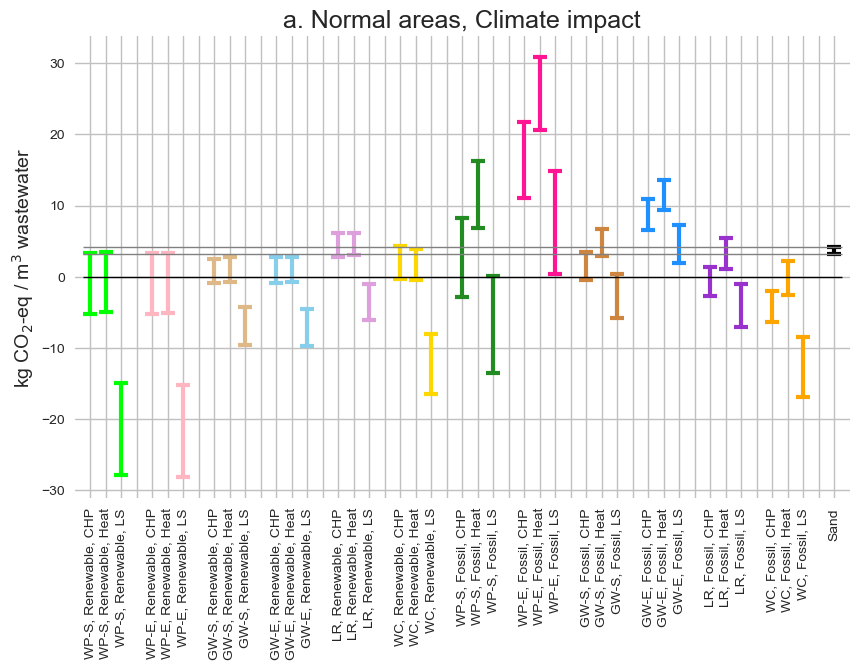

In [142]:
fig, ax = plt.subplots(figsize = (10,6))

# renewable
ax.errorbar(y=BN_C_WPS_R_CHP_med, x=1, yerr = BN_C_WPS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BN_C_WPS_R_Heat_med, x=2, yerr = BN_C_WPS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BN_C_WPS_R_LS_med, x=3, yerr = BN_C_WPS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')

ax.errorbar(y=BN_C_WPE_R_CHP_med, x=5, yerr = BN_C_WPE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BN_C_WPE_R_Heat_med, x=6, yerr = BN_C_WPE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BN_C_WPE_R_LS_med, x=7, yerr = BN_C_WPE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')

ax.errorbar(y=BN_C_GWS_R_CHP_med, x=9, yerr = BN_C_GWS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BN_C_GWS_R_Heat_med, x=10, yerr = BN_C_GWS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BN_C_GWS_R_LS_med, x=11, yerr = BN_C_GWS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')

ax.errorbar(y=BN_C_GWE_R_CHP_med, x=13, yerr = BN_C_GWE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BN_C_GWE_R_Heat_med, x=14, yerr = BN_C_GWE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BN_C_GWE_R_LS_med, x=15, yerr = BN_C_GWE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')

ax.errorbar(y=BN_C_LR_R_CHP_med, x=17, yerr = BN_C_LR_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BN_C_LR_R_Heat_med, x=18, yerr = BN_C_LR_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BN_C_LR_R_LS_med, x=19, yerr = BN_C_LR_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')

ax.errorbar(y=BN_C_WC_R_CHP_med, x=21, yerr = BN_C_WC_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BN_C_WC_R_Heat_med, x=22, yerr = BN_C_WC_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BN_C_WC_R_LS_med, x=23, yerr = BN_C_WC_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

# fossil
ax.errorbar(y=BN_C_WPS_F_CHP_med, x=25, yerr = BN_C_WPS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BN_C_WPS_F_Heat_med, x=26, yerr = BN_C_WPS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BN_C_WPS_F_LS_med, x=27, yerr = BN_C_WPS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BN_C_WPE_F_CHP_med, x=29, yerr = BN_C_WPE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BN_C_WPE_F_Heat_med, x=30, yerr = BN_C_WPE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BN_C_WPE_F_LS_med, x=31, yerr = BN_C_WPE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')

ax.errorbar(y=BN_C_GWS_F_CHP_med, x=33, yerr = BN_C_GWS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BN_C_GWS_F_Heat_med, x=34, yerr = BN_C_GWS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BN_C_GWS_F_LS_med, x=35, yerr = BN_C_GWS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_C_GWE_F_CHP_med, x=37, yerr = BN_C_GWE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BN_C_GWE_F_Heat_med, x=38, yerr = BN_C_GWE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BN_C_GWE_F_LS_med, x=39, yerr = BN_C_GWE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')

ax.errorbar(y=BN_C_LR_F_CHP_med, x=41, yerr = BN_C_LR_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BN_C_LR_F_Heat_med, x=42, yerr = BN_C_LR_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BN_C_LR_F_LS_med, x=43, yerr = BN_C_LR_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')

ax.errorbar(y=BN_C_WC_F_CHP_med, x=45, yerr = BN_C_WC_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BN_C_WC_F_Heat_med, x=46, yerr = BN_C_WC_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BN_C_WC_F_LS_med, x=47, yerr = BN_C_WC_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

# sand
ax.errorbar(y=SN_C_med, x=49, yerr = SN_C_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('a. Normal areas, Climate impact', fontsize=18)
ax.set_xticks((range(1,50)))
ax.set_xticklabels(('WP-S, Renewable, CHP','WP-S, Renewable, Heat','WP-S, Renewable, LS',
    '',
    'WP-E, Renewable, CHP','WP-E, Renewable, Heat','WP-E, Renewable, LS',
    '',
    'GW-S, Renewable, CHP','GW-S, Renewable, Heat','GW-S, Renewable, LS',
    '',
    'GW-E, Renewable, CHP','GW-E, Renewable, Heat','GW-E, Renewable, LS',
    '',
    'LR, Renewable, CHP','LR, Renewable, Heat','LR, Renewable, LS',
    '',
    'WC, Renewable, CHP','WC, Renewable, Heat','WC, Renewable, LS',
    '',
    'WP-S, Fossil, CHP', 'WP-S, Fossil, Heat', 'WP-S, Fossil, LS', 
    '',
    'WP-E, Fossil, CHP', 'WP-E, Fossil, Heat', 'WP-E, Fossil, LS',
    '',
    'GW-S, Fossil, CHP', 'GW-S, Fossil, Heat', 'GW-S, Fossil, LS',
    '',
    'GW-E, Fossil, CHP', 'GW-E, Fossil, Heat', 'GW-E, Fossil, LS',
    '',
    'LR, Fossil, CHP', 'LR, Fossil, Heat','LR, Fossil, LS', 
    '',
    'WC, Fossil, CHP','WC, Fossil, Heat','WC, Fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)

ax.set_ylabel(climate_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=49.5, linewidth=1, color='black')
ax.set_xlim(0,50)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=SN_C_med-SN_C_e[0], xmin=0.5, xmax=49.5, linewidth=1, color='grey')
ax.hlines(y=SN_C_med+SN_C_e[1], xmin=0.5, xmax=49.5, linewidth=1, color='grey')

In [84]:
fig.savefig('climate_scenarios_normal', dpi=600, bbox_inches='tight')

#### climate - sensitive areas

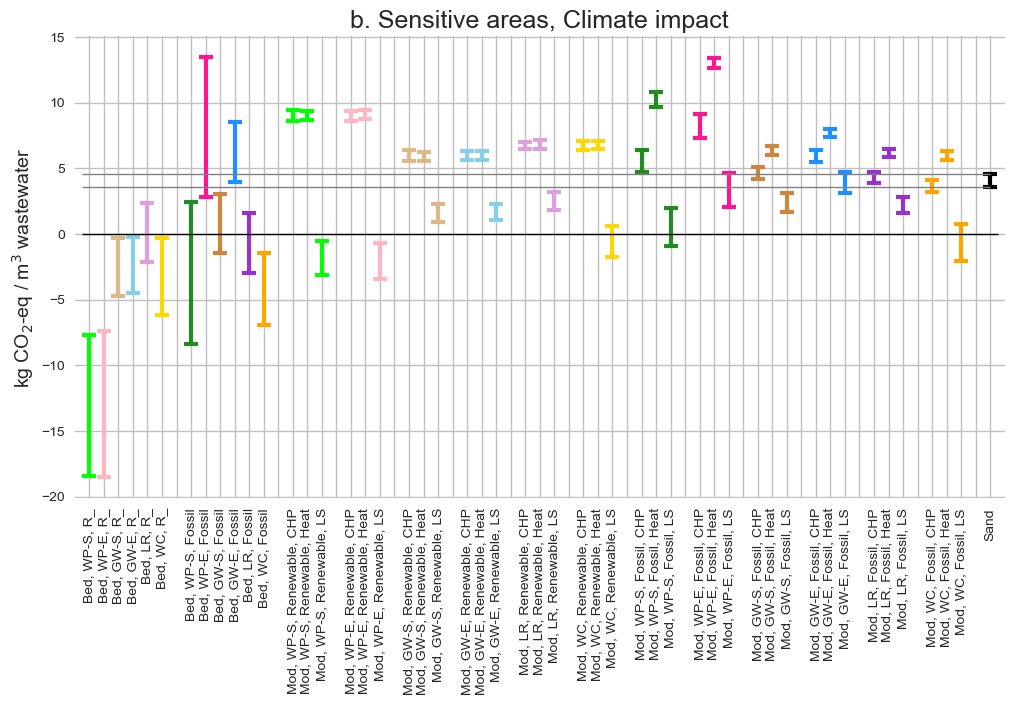

In [144]:
fig, ax = plt.subplots(figsize = (12,6))

# bed, renewable
ax.errorbar(y=BBS_C_WPS_R_med, x=1, yerr=BBS_C_WPS_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BBS_C_WPE_R_med, x=2, yerr=BBS_C_WPE_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BBS_C_GWS_R_med, x=3, yerr=BBS_C_GWS_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BBS_C_GWE_R_med, x=4, yerr=BBS_C_GWE_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BBS_C_LR_R_med, x=5, yerr=BBS_C_LR_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BBS_C_WC_R_med, x=6, yerr=BBS_C_WC_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

# bed, fossil
ax.errorbar(y=BBS_C_WPS_F_med, x=8, yerr=BBS_C_WPS_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BBS_C_WPE_F_med, x=9, yerr=BBS_C_WPE_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BBS_C_GWS_F_med, x=10, yerr=BBS_C_GWS_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BBS_C_GWE_F_med, x=11, yerr=BBS_C_GWE_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BBS_C_LR_F_med, x=12, yerr=BBS_C_LR_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BBS_C_WC_F_med, x=13, yerr=BBS_C_WC_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

## mod, renewable
ax.errorbar(y=BMS_C_WPS_R_CHP_med, x=15, yerr=BMS_C_WPS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BMS_C_WPS_R_Heat_med, x=16, yerr=BMS_C_WPS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BMS_C_WPS_R_LS_med, x=17, yerr=BMS_C_WPS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')

ax.errorbar(y=BMS_C_WPE_R_CHP_med, x=19, yerr=BMS_C_WPE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BMS_C_WPE_R_Heat_med, x=20, yerr=BMS_C_WPE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BMS_C_WPE_R_LS_med, x=21, yerr=BMS_C_WPE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')

ax.errorbar(y=BMS_C_GWS_R_CHP_med, x=23, yerr=BMS_C_GWS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BMS_C_GWS_R_Heat_med, x=24, yerr=BMS_C_GWS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BMS_C_GWS_R_LS_med, x=25, yerr=BMS_C_GWS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')

ax.errorbar(y=BMS_C_GWE_R_CHP_med, x=27, yerr=BMS_C_GWE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BMS_C_GWE_R_Heat_med, x=28, yerr=BMS_C_GWE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BMS_C_GWE_R_LS_med, x=29, yerr=BMS_C_GWE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')

ax.errorbar(y=BMS_C_LR_R_CHP_med, x=31, yerr=BMS_C_LR_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BMS_C_LR_R_Heat_med, x=32, yerr=BMS_C_LR_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BMS_C_LR_R_LS_med, x=33, yerr=BMS_C_LR_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')

ax.errorbar(y=BMS_C_WC_R_CHP_med, x=35, yerr=BMS_C_WC_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BMS_C_WC_R_Heat_med, x=36, yerr=BMS_C_WC_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BMS_C_WC_R_LS_med, x=37, yerr=BMS_C_WC_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

## mod, fossil

ax.errorbar(y=BMS_C_WPS_F_CHP_med, x=39, yerr=BMS_C_WPS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BMS_C_WPS_F_Heat_med, x=40, yerr=BMS_C_WPS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BMS_C_WPS_F_LS_med, x=41, yerr=BMS_C_WPS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_C_WPE_F_CHP_med, x=43, yerr=BMS_C_WPE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BMS_C_WPE_F_Heat_med, x=44, yerr=BMS_C_WPE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BMS_C_WPE_F_LS_med, x=45, yerr=BMS_C_WPE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')

ax.errorbar(y=BMS_C_GWS_F_CHP_med, x=47, yerr=BMS_C_GWS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BMS_C_GWS_F_Heat_med, x=48, yerr=BMS_C_GWS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BMS_C_GWS_F_LS_med, x=49, yerr=BMS_C_GWS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_C_GWE_F_CHP_med, x=51, yerr=BMS_C_GWE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BMS_C_GWE_F_Heat_med, x=52, yerr=BMS_C_GWE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BMS_C_GWE_F_LS_med, x=53, yerr=BMS_C_GWE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')

ax.errorbar(y=BMS_C_LR_F_CHP_med, x=55, yerr=BMS_C_LR_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BMS_C_LR_F_Heat_med, x=56, yerr=BMS_C_LR_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BMS_C_LR_F_LS_med, x=57, yerr=BMS_C_LR_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')

ax.errorbar(y=BMS_C_WC_F_CHP_med, x=59, yerr=BMS_C_WC_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BMS_C_WC_F_Heat_med, x=60, yerr=BMS_C_WC_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BMS_C_WC_F_LS_med, x=61, yerr=BMS_C_WC_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

## sand
ax.errorbar(y=SS_C_med, x=63, yerr = SS_C_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('b. Sensitive areas, Climate impact', fontsize=18)
ax.set_xticks((range(1,64)))
ax.set_xticklabels((
    'Bed, WP-S, R_','Bed, WP-E, R_','Bed, GW-S, R_','Bed, GW-E, R_',
    'Bed, LR, R_','Bed, WC, R_',
    '',
    'Bed, WP-S, Fossil', 'Bed, WP-E, Fossil', 'Bed, GW-S, Fossil', 'Bed, GW-E, Fossil', 'Bed, LR, Fossil', 'Bed, WC, Fossil',
    '',    
    'Mod, WP-S, Renewable, CHP','Mod, WP-S, Renewable, Heat','Mod, WP-S, Renewable, LS',
    '',
    'Mod, WP-E, Renewable, CHP','Mod, WP-E, Renewable, Heat','Mod, WP-E, Renewable, LS',
    '',
    'Mod, GW-S, Renewable, CHP','Mod, GW-S, Renewable, Heat','Mod, GW-S, Renewable, LS',
    '',
    'Mod, GW-E, Renewable, CHP','Mod, GW-E, Renewable, Heat','Mod, GW-E, Renewable, LS',
    '',
    'Mod, LR, Renewable, CHP','Mod, LR, Renewable, Heat','Mod, LR, Renewable, LS',
    '',
    'Mod, WC, Renewable, CHP','Mod, WC, Renewable, Heat','Mod, WC, Renewable, LS',
    '',
    'Mod, WP-S, Fossil, CHP', 'Mod, WP-S, Fossil, Heat', 'Mod, WP-S, Fossil, LS', 
    '',
    'Mod, WP-E, Fossil, CHP', 'Mod, WP-E, Fossil, Heat', 'Mod, WP-E, Fossil, LS',
    '',
    'Mod, GW-S, Fossil, CHP', 'Mod, GW-S, Fossil, Heat', 'Mod, GW-S, Fossil, LS',
    '',
    'Mod, GW-E, Fossil, CHP', 'Mod, GW-E, Fossil, Heat', 'Mod, GW-E, Fossil, LS',
    '',
    'Mod, LR, Fossil, CHP', 'Mod, LR, Fossil, Heat','Mod, LR, Fossil, LS', 
    '',
    'Mod, WC, Fossil, CHP','Mod, WC, Fossil, Heat','Mod, WC, Fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)
ax.set_ylabel(climate_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=63.5, linewidth=1, color='black')
ax.set_xlim(0,64)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=SS_C_med-SS_C_e[0], xmin=0.5, xmax=63, linewidth=1, color='grey')
ax.hlines(y=SS_C_med+SS_C_e[1], xmin=0.5, xmax=63, linewidth=1, color='grey')

In [96]:
fig.savefig('climate_scenarios_sensitive', dpi=600, bbox_inches='tight')

#### eutroph - normal areas

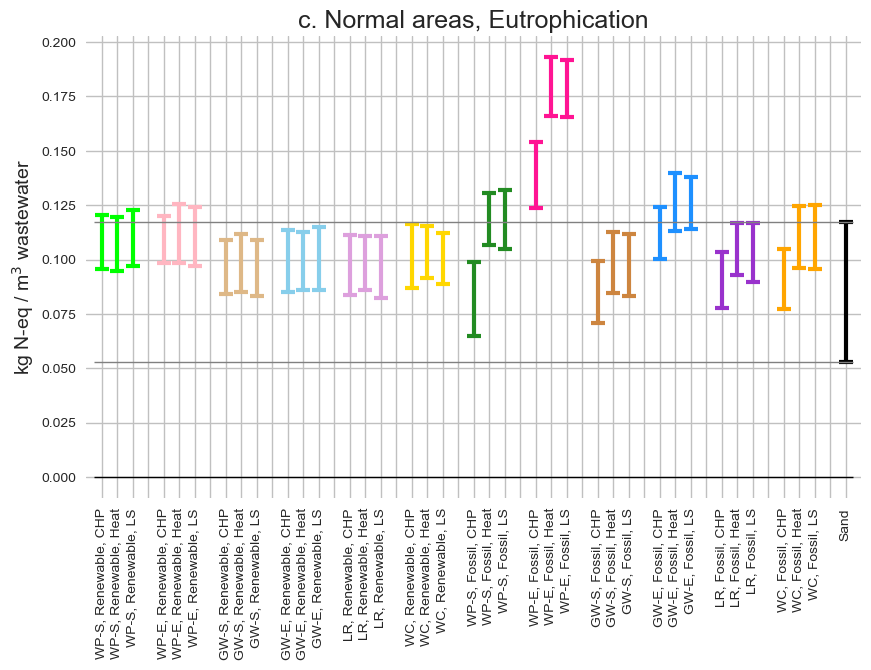

In [146]:
fig, ax = plt.subplots(figsize = (10,6))

# renewable
ax.errorbar(y=BN_E_WPS_R_CHP_med, x=1, yerr = BN_E_WPS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BN_E_WPS_R_Heat_med, x=2, yerr = BN_E_WPS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BN_E_WPS_R_LS_med, x=3, yerr = BN_E_WPS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')

ax.errorbar(y=BN_E_WPE_R_CHP_med, x=5, yerr = BN_E_WPE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BN_E_WPE_R_Heat_med, x=6, yerr = BN_E_WPE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BN_E_WPE_R_LS_med, x=7, yerr = BN_E_WPE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')

ax.errorbar(y=BN_E_GWS_R_CHP_med, x=9, yerr = BN_E_GWS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BN_E_GWS_R_Heat_med, x=10, yerr = BN_E_GWS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BN_E_GWS_R_LS_med, x=11, yerr = BN_E_GWS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')

ax.errorbar(y=BN_E_GWE_R_CHP_med, x=13, yerr = BN_E_GWE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BN_E_GWE_R_Heat_med, x=14, yerr = BN_E_GWE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BN_E_GWE_R_LS_med, x=15, yerr = BN_E_GWE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')

ax.errorbar(y=BN_E_LR_R_CHP_med, x=17, yerr = BN_E_LR_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BN_E_LR_R_Heat_med, x=18, yerr = BN_E_LR_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BN_E_LR_R_LS_med, x=19, yerr = BN_E_LR_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')

ax.errorbar(y=BN_E_WC_R_CHP_med, x=21, yerr = BN_E_WC_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BN_E_WC_R_Heat_med, x=22, yerr = BN_E_WC_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BN_E_WC_R_LS_med, x=23, yerr = BN_E_WC_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

# fossil
ax.errorbar(y=BN_E_WPS_F_CHP_med, x=25, yerr = BN_E_WPS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BN_E_WPS_F_Heat_med, x=26, yerr = BN_E_WPS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BN_E_WPS_F_LS_med, x=27, yerr = BN_E_WPS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BN_E_WPE_F_CHP_med, x=29, yerr = BN_E_WPE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BN_E_WPE_F_Heat_med, x=30, yerr = BN_E_WPE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BN_E_WPE_F_LS_med, x=31, yerr = BN_E_WPE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')

ax.errorbar(y=BN_E_GWS_F_CHP_med, x=33, yerr = BN_E_GWS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BN_E_GWS_F_Heat_med, x=34, yerr = BN_E_GWS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BN_E_GWS_F_LS_med, x=35, yerr = BN_E_GWS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_E_GWE_F_CHP_med, x=37, yerr = BN_E_GWE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BN_E_GWE_F_Heat_med, x=38, yerr = BN_E_GWE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BN_E_GWE_F_LS_med, x=39, yerr = BN_E_GWE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')

ax.errorbar(y=BN_E_LR_F_CHP_med, x=41, yerr = BN_E_LR_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BN_E_LR_F_Heat_med, x=42, yerr = BN_E_LR_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BN_E_LR_F_LS_med, x=43, yerr = BN_E_LR_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')

ax.errorbar(y=BN_E_WC_F_CHP_med, x=45, yerr = BN_E_WC_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BN_E_WC_F_Heat_med, x=46, yerr = BN_E_WC_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BN_E_WC_F_LS_med, x=47, yerr = BN_E_WC_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

# sand
ax.errorbar(y=SN_E_med, x=49, yerr = SN_E_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('c. Normal areas, Eutrophication', fontsize=18)
ax.set_xticks((range(1,50)))
ax.set_xticklabels(('WP-S, Renewable, CHP','WP-S, Renewable, Heat','WP-S, Renewable, LS',
    '',
    'WP-E, Renewable, CHP','WP-E, Renewable, Heat','WP-E, Renewable, LS',
    '',
    'GW-S, Renewable, CHP','GW-S, Renewable, Heat','GW-S, Renewable, LS',
    '',
    'GW-E, Renewable, CHP','GW-E, Renewable, Heat','GW-E, Renewable, LS',
    '',
    'LR, Renewable, CHP','LR, Renewable, Heat','LR, Renewable, LS',
    '',
    'WC, Renewable, CHP','WC, Renewable, Heat','WC, Renewable, LS',
    '',
    'WP-S, Fossil, CHP', 'WP-S, Fossil, Heat', 'WP-S, Fossil, LS', 
    '',
    'WP-E, Fossil, CHP', 'WP-E, Fossil, Heat', 'WP-E, Fossil, LS',
    '',
    'GW-S, Fossil, CHP', 'GW-S, Fossil, Heat', 'GW-S, Fossil, LS',
    '',
    'GW-E, Fossil, CHP', 'GW-E, Fossil, Heat', 'GW-E, Fossil, LS',
    '',
    'LR, Fossil, CHP', 'LR, Fossil, Heat','LR, Fossil, LS', 
    '',
    'WC, Fossil, CHP','WC, Fossil, Heat','WC, Fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)

ax.set_ylabel(eutroph_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=49.5, linewidth=1, color='black')
ax.set_xlim(0,50)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=SN_E_med-SN_E_e[0], xmin=0.5, xmax=49.5, linewidth=1, color='grey')
ax.hlines(y=SN_E_med+SN_E_e[1], xmin=0.5, xmax=49.5, linewidth=1, color='grey')

In [88]:
fig.savefig('eutroph_scenarios_normal', dpi=600, bbox_inches='tight')

#### eutroph - sensitive areas

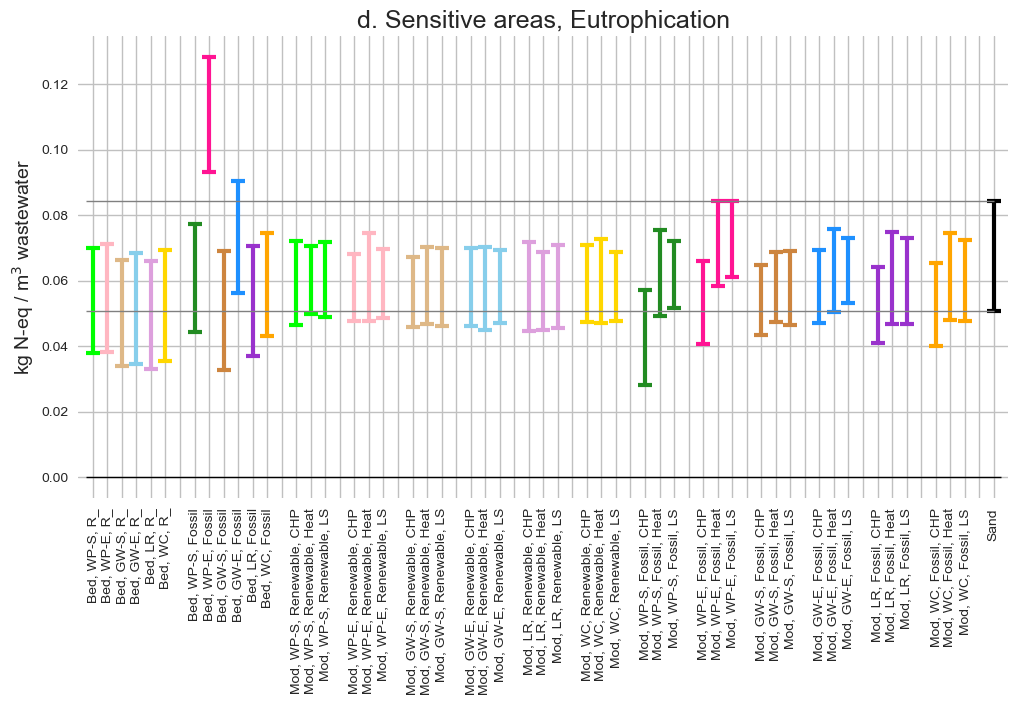

In [148]:
fig, ax = plt.subplots(figsize = (12,6))

# bed, renewable
ax.errorbar(y=BBS_E_WPS_R_med, x=1, yerr=BBS_E_WPS_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BBS_E_WPE_R_med, x=2, yerr=BBS_E_WPE_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BBS_E_GWS_R_med, x=3, yerr=BBS_E_GWS_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BBS_E_GWE_R_med, x=4, yerr=BBS_E_GWE_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BBS_E_LR_R_med, x=5, yerr=BBS_E_LR_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BBS_E_WC_R_med, x=6, yerr=BBS_E_WC_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

# bed, fossil
ax.errorbar(y=BBS_E_WPS_F_med, x=8, yerr=BBS_E_WPS_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BBS_E_WPE_F_med, x=9, yerr=BBS_E_WPE_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BBS_E_GWS_F_med, x=10, yerr=BBS_E_GWS_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BBS_E_GWE_F_med, x=11, yerr=BBS_E_GWE_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BBS_E_LR_F_med, x=12, yerr=BBS_E_LR_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BBS_E_WC_F_med, x=13, yerr=BBS_E_WC_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

## mod, renewable
ax.errorbar(y=BMS_E_WPS_R_CHP_med, x=15, yerr=BMS_E_WPS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BMS_E_WPS_R_Heat_med, x=16, yerr=BMS_E_WPS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BMS_E_WPS_R_LS_med, x=17, yerr=BMS_E_WPS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')

ax.errorbar(y=BMS_E_WPE_R_CHP_med, x=19, yerr=BMS_E_WPE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BMS_E_WPE_R_Heat_med, x=20, yerr=BMS_E_WPE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BMS_E_WPE_R_LS_med, x=21, yerr=BMS_E_WPE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')

ax.errorbar(y=BMS_E_GWS_R_CHP_med, x=23, yerr=BMS_E_GWS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BMS_E_GWS_R_Heat_med, x=24, yerr=BMS_E_GWS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BMS_E_GWS_R_LS_med, x=25, yerr=BMS_E_GWS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')

ax.errorbar(y=BMS_E_GWE_R_CHP_med, x=27, yerr=BMS_E_GWE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BMS_E_GWE_R_Heat_med, x=28, yerr=BMS_E_GWE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BMS_E_GWE_R_LS_med, x=29, yerr=BMS_E_GWE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')

ax.errorbar(y=BMS_E_LR_R_CHP_med, x=31, yerr=BMS_E_LR_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BMS_E_LR_R_Heat_med, x=32, yerr=BMS_E_LR_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BMS_E_LR_R_LS_med, x=33, yerr=BMS_E_LR_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')

ax.errorbar(y=BMS_E_WC_R_CHP_med, x=35, yerr=BMS_E_WC_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BMS_E_WC_R_Heat_med, x=36, yerr=BMS_E_WC_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BMS_E_WC_R_LS_med, x=37, yerr=BMS_E_WC_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

## mod, renewable
ax.errorbar(y=BMS_E_WPS_F_CHP_med, x=39, yerr=BMS_E_WPS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BMS_E_WPS_F_Heat_med, x=40, yerr=BMS_E_WPS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BMS_E_WPS_F_LS_med, x=41, yerr=BMS_E_WPS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_E_WPE_F_CHP_med, x=43, yerr=BMS_E_WPE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BMS_E_WPE_F_Heat_med, x=44, yerr=BMS_E_WPE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BMS_E_WPE_F_LS_med, x=45, yerr=BMS_E_WPE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')

ax.errorbar(y=BMS_E_GWS_F_CHP_med, x=47, yerr=BMS_E_GWS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BMS_E_GWS_F_Heat_med, x=48, yerr=BMS_E_GWS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BMS_E_GWS_F_LS_med, x=49, yerr=BMS_E_GWS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_E_GWE_F_CHP_med, x=51, yerr=BMS_E_GWE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BMS_E_GWE_F_Heat_med, x=52, yerr=BMS_E_GWE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BMS_E_GWE_F_LS_med, x=53, yerr=BMS_E_GWE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')

ax.errorbar(y=BMS_E_LR_F_CHP_med, x=55, yerr=BMS_E_LR_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BMS_E_LR_F_Heat_med, x=56, yerr=BMS_E_LR_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BMS_E_LR_F_LS_med, x=57, yerr=BMS_E_LR_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')

ax.errorbar(y=BMS_E_WC_F_CHP_med, x=59, yerr=BMS_E_WC_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BMS_E_WC_F_Heat_med, x=60, yerr=BMS_E_WC_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BMS_E_WC_F_LS_med, x=61, yerr=BMS_E_WC_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

## sand
ax.errorbar(y=SS_E_med, x=63, yerr = SS_E_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('d. Sensitive areas, Eutrophication', fontsize=18)
ax.set_xticks((range(1,64)))
ax.set_xticklabels(('Bed, WP-S, R_','Bed, WP-E, R_','Bed, GW-S, R_','Bed, GW-E, R_',
    'Bed, LR, R_','Bed, WC, R_',
    '',
    'Bed, WP-S, Fossil', 'Bed, WP-E, Fossil', 'Bed, GW-S, Fossil', 'Bed, GW-E, Fossil', 'Bed, LR, Fossil', 'Bed, WC, Fossil',
    '',
    'Mod, WP-S, Renewable, CHP','Mod, WP-S, Renewable, Heat','Mod, WP-S, Renewable, LS',
    '',
    'Mod, WP-E, Renewable, CHP','Mod, WP-E, Renewable, Heat','Mod, WP-E, Renewable, LS',
    '',
    'Mod, GW-S, Renewable, CHP','Mod, GW-S, Renewable, Heat','Mod, GW-S, Renewable, LS',
    '',
    'Mod, GW-E, Renewable, CHP','Mod, GW-E, Renewable, Heat','Mod, GW-E, Renewable, LS',
    '',
    'Mod, LR, Renewable, CHP','Mod, LR, Renewable, Heat','Mod, LR, Renewable, LS',
    '',
    'Mod, WC, Renewable, CHP','Mod, WC, Renewable, Heat','Mod, WC, Renewable, LS',
    '',
    'Mod, WP-S, Fossil, CHP', 'Mod, WP-S, Fossil, Heat', 'Mod, WP-S, Fossil, LS', 
    '',
    'Mod, WP-E, Fossil, CHP', 'Mod, WP-E, Fossil, Heat', 'Mod, WP-E, Fossil, LS',
    '',
    'Mod, GW-S, Fossil, CHP', 'Mod, GW-S, Fossil, Heat', 'Mod, GW-S, Fossil, LS',
    '',
    'Mod, GW-E, Fossil, CHP', 'Mod, GW-E, Fossil, Heat', 'Mod, GW-E, Fossil, LS',
    '',
    'Mod, LR, Fossil, CHP', 'Mod, LR, Fossil, Heat','Mod, LR, Fossil, LS', 
    '',
    'Mod, WC, Fossil, CHP','Mod, WC, Fossil, Heat','Mod, WC, Fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)
ax.set_ylabel(eutroph_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=63.5, linewidth=1, color='black')
ax.set_xlim(0,64)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=SS_E_med-SS_E_e[0], xmin=0.5, xmax=63, linewidth=1, color='grey')
ax.hlines(y=SS_E_med+SS_E_e[1], xmin=0.5, xmax=63, linewidth=1, color='grey')

In [98]:
fig.savefig('eutroph_scenarios_sensitive', dpi=600, bbox_inches='tight')

#### acidification - normal areas

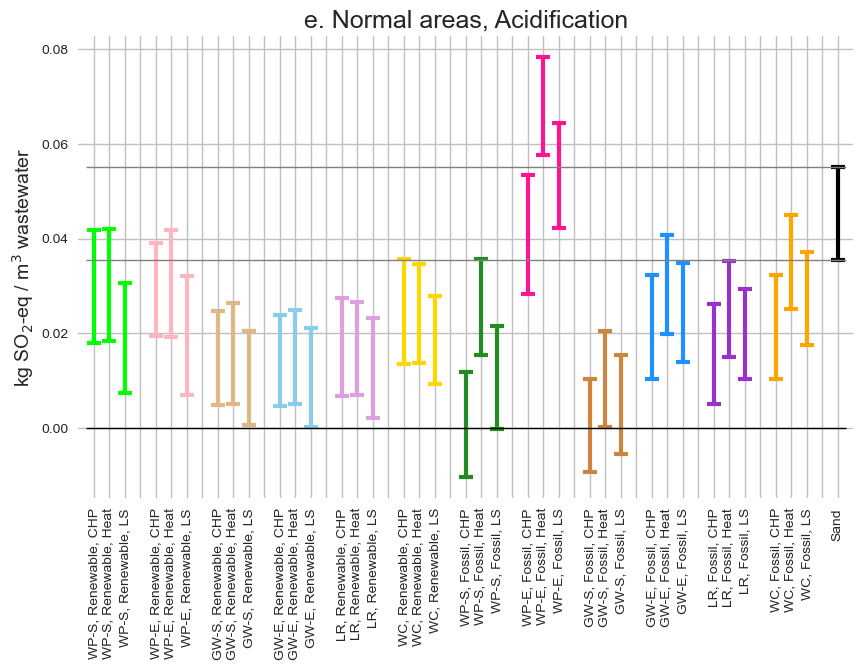

In [153]:
fig, ax = plt.subplots(figsize = (10,6))

# fossil
ax.errorbar(y=BN_A_WPS_R_CHP_med, x=1, yerr = BN_A_WPS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BN_A_WPS_R_Heat_med, x=2, yerr = BN_A_WPS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BN_A_WPS_R_LS_med, x=3, yerr = BN_A_WPS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')

ax.errorbar(y=BN_A_WPE_R_CHP_med, x=5, yerr = BN_A_WPE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BN_A_WPE_R_Heat_med, x=6, yerr = BN_A_WPE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BN_A_WPE_R_LS_med, x=7, yerr = BN_A_WPE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')

ax.errorbar(y=BN_A_GWS_R_CHP_med, x=9, yerr = BN_A_GWS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BN_A_GWS_R_Heat_med, x=10, yerr = BN_A_GWS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BN_A_GWS_R_LS_med, x=11, yerr = BN_A_GWS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')

ax.errorbar(y=BN_A_GWE_R_CHP_med, x=13, yerr = BN_A_GWE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BN_A_GWE_R_Heat_med, x=14, yerr = BN_A_GWE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BN_A_GWE_R_LS_med, x=15, yerr = BN_A_GWE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')

ax.errorbar(y=BN_A_LR_R_CHP_med, x=17, yerr = BN_A_LR_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BN_A_LR_R_Heat_med, x=18, yerr = BN_A_LR_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BN_A_LR_R_LS_med, x=19, yerr = BN_A_LR_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')

ax.errorbar(y=BN_A_WC_R_CHP_med, x=21, yerr = BN_A_WC_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BN_A_WC_R_Heat_med, x=22, yerr = BN_A_WC_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BN_A_WC_R_LS_med, x=23, yerr = BN_A_WC_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

# fossil
ax.errorbar(y=BN_A_WPS_F_CHP_med, x=25, yerr = BN_A_WPS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BN_A_WPS_F_Heat_med, x=26, yerr = BN_A_WPS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BN_A_WPS_F_LS_med, x=27, yerr = BN_A_WPS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BN_A_WPE_F_CHP_med, x=29, yerr = BN_A_WPE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BN_A_WPE_F_Heat_med, x=30, yerr = BN_A_WPE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BN_A_WPE_F_LS_med, x=31, yerr = BN_A_WPE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')

ax.errorbar(y=BN_A_GWS_F_CHP_med, x=33, yerr = BN_A_GWS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BN_A_GWS_F_Heat_med, x=34, yerr = BN_A_GWS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BN_A_GWS_F_LS_med, x=35, yerr = BN_A_GWS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_A_GWE_F_CHP_med, x=37, yerr = BN_A_GWE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BN_A_GWE_F_Heat_med, x=38, yerr = BN_A_GWE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BN_A_GWE_F_LS_med, x=39, yerr = BN_A_GWE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')

ax.errorbar(y=BN_A_LR_F_CHP_med, x=41, yerr = BN_A_LR_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BN_A_LR_F_Heat_med, x=42, yerr = BN_A_LR_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BN_A_LR_F_LS_med, x=43, yerr = BN_A_LR_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')

ax.errorbar(y=BN_A_WC_F_CHP_med, x=45, yerr = BN_A_WC_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BN_A_WC_F_Heat_med, x=46, yerr = BN_A_WC_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BN_A_WC_F_LS_med, x=47, yerr = BN_A_WC_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

# sand
ax.errorbar(y=SN_A_med, x=49, yerr = SN_A_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('e. Normal areas, Acidification', fontsize=18)
ax.set_xticks((range(1,50)))
ax.set_xticklabels(('WP-S, Renewable, CHP','WP-S, Renewable, Heat','WP-S, Renewable, LS',
    '',
    'WP-E, Renewable, CHP','WP-E, Renewable, Heat','WP-E, Renewable, LS',
    '',
    'GW-S, Renewable, CHP','GW-S, Renewable, Heat','GW-S, Renewable, LS',
    '',
    'GW-E, Renewable, CHP','GW-E, Renewable, Heat','GW-E, Renewable, LS',
    '',
    'LR, Renewable, CHP','LR, Renewable, Heat','LR, Renewable, LS',
    '',
    'WC, Renewable, CHP','WC, Renewable, Heat','WC, Renewable, LS',
    '',
    'WP-S, Fossil, CHP', 'WP-S, Fossil, Heat', 'WP-S, Fossil, LS', 
    '',
    'WP-E, Fossil, CHP', 'WP-E, Fossil, Heat', 'WP-E, Fossil, LS',
    '',
    'GW-S, Fossil, CHP', 'GW-S, Fossil, Heat', 'GW-S, Fossil, LS',
    '',
    'GW-E, Fossil, CHP', 'GW-E, Fossil, Heat', 'GW-E, Fossil, LS',
    '',
    'LR, Fossil, CHP', 'LR, Fossil, Heat','LR, Fossil, LS', 
    '',
    'WC, Fossil, CHP','WC, Fossil, Heat','WC, Fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)

ax.set_ylabel(acid_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=49.5, linewidth=1, color='black')
ax.set_xlim(0,50)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=SN_A_med-SN_A_e[0], xmin=0.5, xmax=49.5, linewidth=1, color='grey')
ax.hlines(y=SN_A_med+SN_A_e[1], xmin=0.5, xmax=49.5, linewidth=1, color='grey')

In [92]:
fig.savefig('acid_scenarios_normal', dpi=600, bbox_inches='tight')

#### acidification - sensitive areas

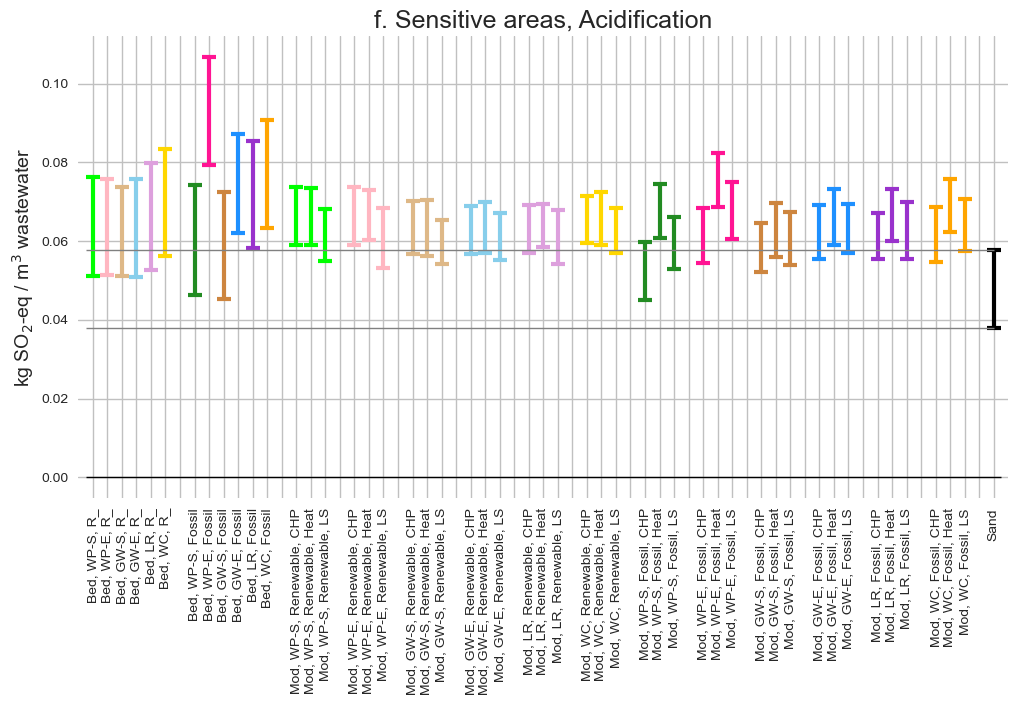

In [154]:
fig, ax = plt.subplots(figsize = (12,6))

# bed, renewable
ax.errorbar(y=BBS_A_WPS_R_med, x=1, yerr=BBS_A_WPS_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BBS_A_WPE_R_med, x=2, yerr=BBS_A_WPE_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BBS_A_GWS_R_med, x=3, yerr=BBS_A_GWS_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BBS_A_GWE_R_med, x=4, yerr=BBS_A_GWE_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BBS_A_LR_R_med, x=5, yerr=BBS_A_LR_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BBS_A_WC_R_med, x=6, yerr=BBS_A_WC_R_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

# bed, fossil
ax.errorbar(y=BBS_A_WPS_F_med, x=8, yerr=BBS_A_WPS_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BBS_A_WPE_F_med, x=9, yerr=BBS_A_WPE_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BBS_A_GWS_F_med, x=10, yerr=BBS_A_GWS_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BBS_A_GWE_F_med, x=11, yerr=BBS_A_GWE_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BBS_A_LR_F_med, x=12, yerr=BBS_A_LR_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BBS_A_WC_F_med, x=13, yerr=BBS_A_WC_F_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

## mod, renewable
ax.errorbar(y=BMS_A_WPS_R_CHP_med, x=15, yerr=BMS_A_WPS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BMS_A_WPS_R_Heat_med, x=16, yerr=BMS_A_WPS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')
ax.errorbar(y=BMS_A_WPS_R_LS_med, x=17, yerr=BMS_A_WPS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lime')

ax.errorbar(y=BMS_A_WPE_R_CHP_med, x=19, yerr=BMS_A_WPE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BMS_A_WPE_R_Heat_med, x=20, yerr=BMS_A_WPE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')
ax.errorbar(y=BMS_A_WPE_R_LS_med, x=21, yerr=BMS_A_WPE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='lightpink')

ax.errorbar(y=BMS_A_GWS_R_CHP_med, x=23, yerr=BMS_A_GWS_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BMS_A_GWS_R_Heat_med, x=24, yerr=BMS_A_GWS_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')
ax.errorbar(y=BMS_A_GWS_R_LS_med, x=25, yerr=BMS_A_GWS_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='burlywood')

ax.errorbar(y=BMS_A_GWE_R_CHP_med, x=27, yerr=BMS_A_GWE_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BMS_A_GWE_R_Heat_med, x=28, yerr=BMS_A_GWE_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')
ax.errorbar(y=BMS_A_GWE_R_LS_med, x=29, yerr=BMS_A_GWE_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='skyblue')

ax.errorbar(y=BMS_A_LR_R_CHP_med, x=31, yerr=BMS_A_LR_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BMS_A_LR_R_Heat_med, x=32, yerr=BMS_A_LR_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')
ax.errorbar(y=BMS_A_LR_R_LS_med, x=33, yerr=BMS_A_LR_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='plum')

ax.errorbar(y=BMS_A_WC_R_CHP_med, x=35, yerr=BMS_A_WC_R_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BMS_A_WC_R_Heat_med, x=36, yerr=BMS_A_WC_R_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')
ax.errorbar(y=BMS_A_WC_R_LS_med, x=37, yerr=BMS_A_WC_R_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='gold')

## mod, fossil
ax.errorbar(y=BMS_A_WPS_F_CHP_med, x=39, yerr=BMS_A_WPS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BMS_A_WPS_F_Heat_med, x=40, yerr=BMS_A_WPS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')
ax.errorbar(y=BMS_A_WPS_F_LS_med, x=41, yerr=BMS_A_WPS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_A_WPE_F_CHP_med, x=43, yerr=BMS_A_WPE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BMS_A_WPE_F_Heat_med, x=44, yerr=BMS_A_WPE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')
ax.errorbar(y=BMS_A_WPE_F_LS_med, x=45, yerr=BMS_A_WPE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='deeppink')

ax.errorbar(y=BMS_A_GWS_F_CHP_med, x=47, yerr=BMS_A_GWS_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BMS_A_GWS_F_Heat_med, x=48, yerr=BMS_A_GWS_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')
ax.errorbar(y=BMS_A_GWS_F_LS_med, x=49, yerr=BMS_A_GWS_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_A_GWE_F_CHP_med, x=51, yerr=BMS_A_GWE_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BMS_A_GWE_F_Heat_med, x=52, yerr=BMS_A_GWE_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')
ax.errorbar(y=BMS_A_GWE_F_LS_med, x=53, yerr=BMS_A_GWE_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='dodgerblue')

ax.errorbar(y=BMS_A_LR_F_CHP_med, x=55, yerr=BMS_A_LR_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BMS_A_LR_F_Heat_med, x=56, yerr=BMS_A_LR_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')
ax.errorbar(y=BMS_A_LR_F_LS_med, x=57, yerr=BMS_A_LR_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='darkorchid')

ax.errorbar(y=BMS_A_WC_F_CHP_med, x=59, yerr=BMS_A_WC_F_CHP_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BMS_A_WC_F_Heat_med, x=60, yerr=BMS_A_WC_F_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')
ax.errorbar(y=BMS_A_WC_F_LS_med, x=61, yerr=BMS_A_WC_F_LS_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orange')

## sand
ax.errorbar(y=SS_A_med, x=63, yerr = SS_A_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.set_title('f. Sensitive areas, Acidification', fontsize=18)
ax.set_xticks((range(1,64)))
ax.set_xticklabels((
    'Bed, WP-S, R_','Bed, WP-E, R_','Bed, GW-S, R_','Bed, GW-E, R_',
    'Bed, LR, R_','Bed, WC, R_',
    '',
    'Bed, WP-S, Fossil', 'Bed, WP-E, Fossil', 'Bed, GW-S, Fossil', 'Bed, GW-E, Fossil', 'Bed, LR, Fossil', 'Bed, WC, Fossil',
    '',
    'Mod, WP-S, Renewable, CHP','Mod, WP-S, Renewable, Heat','Mod, WP-S, Renewable, LS',
    '',
    'Mod, WP-E, Renewable, CHP','Mod, WP-E, Renewable, Heat','Mod, WP-E, Renewable, LS',
    '',
    'Mod, GW-S, Renewable, CHP','Mod, GW-S, Renewable, Heat','Mod, GW-S, Renewable, LS',
    '',
    'Mod, GW-E, Renewable, CHP','Mod, GW-E, Renewable, Heat','Mod, GW-E, Renewable, LS',
    '',
    'Mod, LR, Renewable, CHP','Mod, LR, Renewable, Heat','Mod, LR, Renewable, LS',
    '',
    'Mod, WC, Renewable, CHP','Mod, WC, Renewable, Heat','Mod, WC, Renewable, LS',
    '',
    'Mod, WP-S, Fossil, CHP', 'Mod, WP-S, Fossil, Heat', 'Mod, WP-S, Fossil, LS', 
    '',
    'Mod, WP-E, Fossil, CHP', 'Mod, WP-E, Fossil, Heat', 'Mod, WP-E, Fossil, LS',
    '',
    'Mod, GW-S, Fossil, CHP', 'Mod, GW-S, Fossil, Heat', 'Mod, GW-S, Fossil, LS',
    '',
    'Mod, GW-E, Fossil, CHP', 'Mod, GW-E, Fossil, Heat', 'Mod, GW-E, Fossil, LS',
    '',
    'Mod, LR, Fossil, CHP', 'Mod, LR, Fossil, Heat','Mod, LR, Fossil, LS', 
    '',
    'Mod, WC, Fossil, CHP','Mod, WC, Fossil, Heat','Mod, WC, Fossil, LS',
    '',
    'Sand'), fontsize=10, rotation=90)
ax.set_ylabel(acid_label, fontsize=14)
ax.hlines(y=0, xmin=0.5, xmax=63.5, linewidth=1, color='black')
ax.set_xlim(0,64)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=SS_A_med-SS_A_e[0], xmin=0.5, xmax=63, linewidth=1, color='grey')
ax.hlines(y=SS_A_med+SS_A_e[1], xmin=0.5, xmax=63, linewidth=1, color='grey')

In [100]:
fig.savefig('acid_scenarios_sensitive', dpi=600, bbox_inches='tight')

## CA

### Import functions, setting up

In this section we will resuse code and functions from Elias, this section is just running through and defining functions etc that we will use later 

In [155]:
from __future__ import print_function, unicode_literals
from eight import *

from bw2data import databases, methods, get_activity, Method
from bw2calc import LCA

In [156]:
fg = 'wwt_db'
fu1 = {('wwt_db', '4936df1f1c8d470380b02907bf2002c5'):1} # bc bed, normal
fu2 = {('wwt_db', '0fbe01da943e4d4aa7c3d39337be5ddf'):1} # sandfilter, normal
fu3 = {('wwt_db', '478174ce5a594287a039bdc23757b240'):1} # bc bed, sensitive
fu4 = {('wwt_db', '4c5d9a125cd84265a68dd09858eac9f4'):1} # bc mod, sensitive
fu5 = {('wwt_db', 'c4401064ed20418084f86b84ddf6bb93'):1} # sand, sensitive

In [157]:
def traverse_tagged_databases(
    functional_unit, method, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):

    """
    ESA : allows to perform grouping as in SimaPro 
    Traverse a functional unit throughout its foreground database(s) or the    
    listed databses in fg_databses, and group impacts by tag label.

    Contribution analysis work by linking impacts to individual activities.
    However, you also might want to group impacts in other ways. For example,
    give individual biosphere exchanges their own grouping, or aggregate two
    activities together.
    
    Consider this example system, where the letters are the tag labels, and the
    numbers are exchange amounts. The functional unit is one unit of the tree
    root.

    .. image:: images/tagged-traversal.png
       :alt: Example tagged supply chain

    In this supply chain, tags are applied to activities and biosphere exchanges.
    If a biosphere exchange is not tagged, it inherits the tag of its producing
    activity. Similarly, links to other databases are assessed with the usual
    LCA machinery, and the total LCA score is tagged according to its consuming
    activity. If an activity does not have a tag, a default tag is applied.

    We can change our visualization to show the use of the default tags:
    
    .. image:: images/tagged-traversal-2.png
       :alt: Example tagged supply chain

    And then we can manually calculate the tagged impacts. Normally we would
    need to know the actual biosphere flows and their respective
    characterization factors (CF), but in this example we assume that each
    CF is one. Our result, group by tags, would therefore be:

        * **A**: :math:`6 + 27 = 33`

        * **B**: :math:`30 + 44 = 74`

        * **C**: :math:`5 + 16 + 48 = 69`

        * **D**: :math:`14`

    This function will only traverse the foreground database, i.e. the
    database of the functional unit activity. A functional unit can have
    multiple starting nodes; in this case, all foreground databases are
    traversed.

    Input arguments:
        * ``functional_unit``: A functional unit dictionary, e.g. ``{("foo", "bar"): 42}``.
        * ``method``: A method name, e.g. ``("foo", "bar")``
        * ``label``: The label of the tag classifier. Default is ``"tag"``
        * ``default_tag``: The tag classifier to use if none was given. Default is ``"other"``
        * ``secondary_tags``: List of tuples in the format (secondary_label, secondary_default_tag). Default is empty list.      
        * ``fg_databases``: a list of foreground databases to be traversed, e.g. ['foreground', 'biomass', 'machinery']
                            It's not recommended to include all databases of a project in the list to be traversed, especially not ecoinvent itself

    Returns:
        Aggregated tags dictionary from ``aggregate_tagged_graph``, and tagged supply chain graph from ``recurse_tagged_database``.


    """

    lca = LCA(functional_unit, method)
    lca.lci(factorize=True)
    lca.lcia()
    method_dict = {o[0]: o[1] for o in Method(method).load()}
    
    graph = [
        recurse_tagged_database(
            key, amount, method_dict, lca, label, default_tag, secondary_tags, fg_databases, parent4other
        )
        for key, amount in functional_unit.items()
    ]

    return aggregate_tagged_graph(graph, bio2tech), graph

In [158]:
def aggregate_tagged_graph(graph, bio2tech=False,):
    """Aggregate a graph produced by ``recurse_tagged_database`` by the provided tags.

    Outputs a dictionary with keys of tags and numeric values.
    
    If bio2tech is set to True, then biosphere exchanges are added to the tag of the parent activity (instead of direct emissions)

    .. code-block:: python

        {'a tag': summed LCIA scores}

    """

    def recursor(obj, scores):
        scores[obj["tag"]] += obj["impact"]
        if bio2tech:
            for flow in obj["biosphere"]:
                scores[obj["tag"]] += flow["impact"]
        else: # default behavior
            for flow in obj["biosphere"]:
                scores[flow["tag"]] += flow["impact"]
        for exc in obj["technosphere"]:
            scores = recursor(exc, scores)
        return scores

    scores = defaultdict(int)
    for obj in graph:
        scores = recursor(obj, scores)
    return scores

In [159]:
def recurse_tagged_database(
    activity, amount, method_dict, lca, label, default_tag, secondary_tags=[], fg_databases=None, parent4other=False
):

    """Traverse a foreground database and assess activities and biosphere flows by tags.


    Input arguments:


        * ``activity``: Activity tuple or object
        * ``amount``: float
        * ``method_dict``: Dictionary of biosphere flow tuples to CFs, e.g. ``{("biosphere", "foo"): 3}``
        * ``lca``: An ``LCA`` object that is already initialized, i.e. has already calculated LCI and LCIA with same method as in ``method_dict``
        * ``label``: string
        * ``default_tag``: string
        * ``secondary_tags``: List of tuples in the format (secondary_label, secondary_default_tag). Default is empty list.     
        * ``fg_databases``: a list of foreground databases to be traversed, e.g. ['foreground', 'biomass', 'machinery']
                            It's not recommended to include all databases of a project in the list to be traversed, especially not ecoinvent itself
        * parent4other=False : if True, untagged technosphere exchanges are aggregated with their parent .. become "outside"

  Returns:
    .. code-block:: python

        {
            'activity': activity object,
            'amount': float,
            'tag': string,
            'secondary_tags': [list of strings],
            'impact': float (impact of inputs from outside foreground database),
            'biosphere': [{
                'amount': float,
                'impact': float,
                'tag': string,
                'secondary_tags': [list of strings]
            }],
            'technosphere': [this data structure]
        }

    """

    if isinstance(activity, tuple):
        activity = get_activity(activity)
        
    if fg_databases == None: # then set the list equal to the database of the functional unit 
    
        fg_databases = [activity['database']] # list, single item
    
    elif fg_databases == list(bw2.Database(activity['database']).find_graph_dependents()): 
        # check that the list fg_databases does not include all the databases involved in the FU 
        # (otherwise, it would mean we are likely to have to recurse through ecoinvent... not funny)
        # ideally, should only on first call of recurse_tagged_database
        raise Exception('The list of databases to traverse fg_databases should not be equal to the all databases involved in the project. You risk to attempt to traverse a background database like ecoinvent - it would take too much time')

    inputs = list(activity.technosphere())
    #print('activity', activity['name'])
    #print('inputs', inputs)
    
    production = list(activity.production())
    if len(production) == 1:
        scale = production[0]["amount"]
    elif not production:
        # Assume production amount of 1
        scale = 1
    else:
        raise ValueError("Can't scale by production exchange")

    inside = [exc for exc in inputs if exc["input"][0] in fg_databases] # inside = activities in fg_databases
    #print('inside', inside)
    
    outside = {
        exc["input"]: exc["amount"] / scale * amount
        for exc in inputs
        if exc["input"][0] not in fg_databases ## calculates impacts for activities outside of fg_databases
    } # this is a dict of functional units, ready for lca score calculation

    if outside:
        lca.redo_lcia(outside)
        outside_score = lca.score

    else:
        outside_score = 0

    if parent4other:
        #if this option is set to True, will change default_tag's value to the tag
        # of the parent activity if itself was not empty 
        if activity.get(label) != None:
            default_tag = activity.get(label)
    
    #print(default_tag)
    return {
        "activity": activity,
        "amount": amount,
        "tag": activity.get(label) or default_tag,
        "secondary_tags": [activity.get(t[0]) or t[1] for t in secondary_tags],
        "impact": outside_score,
        "biosphere": [
            {
                "amount": exc["amount"] / scale * amount,
                "impact": exc["amount"]
                / scale
                * amount
                * method_dict.get(exc["input"], 0),
                "tag": exc.get(label) or activity.get(label) or default_tag,
                "secondary_tags": [
                    exc.get(t[0]) or activity.get(t[0]) or t[1] for t in secondary_tags
                ],
            }
            for exc in activity.biosphere()
        ],
        "technosphere": [
            recurse_tagged_database(
                exc.input,
                exc["amount"] / scale * amount,
                method_dict,
                lca,
                label,
                default_tag,
                secondary_tags,
                fg_databases,
                parent4other
            )
            for exc in inside
        ],
    }


In [160]:
def rewrite_tagged_database(fg_db_to_tag, new_data):
    '''
    fg_db_to_dag : name of database to be re-written in bw2
    new_data : the newly tagged database
    bw2 will raise error if new data does not correspond to target database
    '''
    val = input("Do you want to proceed (Y/N) ? ")
    if val != 'Y':
        print('Okay, we stop here')
    else:
        db = bw2.Database(fg_db_to_tag)
        db.write(new_data)

In [161]:
def conveniently_tag_database_v2(fg_db_to_tag = '', label='', ):
    '''
    Auxiliary function to conveniently assign new tag labels to a foreground database, for group analysis.
    Select a forground database to tag, via fg_db_to_tag;
    Then define the label name, via label
    Then, loop through all activities, and assign directly new attributes, using peewee functions to save

    Does not return anything. Changes are directly saved to database. Should avoid running into bugs of re-writing database. 
    
    Usage: conveniently_tag_database('fg_database', 'label_name')
    '''
    db = bw2.Database(fg_db_to_tag)
    print('There are %i items to be tagged, one by one' %(len(db)) )
    val = input("Do you want to proceed (Y/N) ? ")
    n=0
    r=0
    if val != 'Y':
        print('Okay, we stop here')
    else:
        print("Lets proceed! Type 'skip' in order to not tag the given activity or remove existing tag")
        for act in db:
            val = input(act['name'] + "... to be in the group called... ? ")
            
            if val == 'skip':
                # need to pop the key if it was defined previously
                act.pop(label, 'label was not present')
                r+=1
            if val != 'skip':
                act[label] = val
                n+=1
            
            act.save() # save back to db
    print("Number of activities tagged: %i" %(n))
    print("Number of activities skipped: %i" %(r))

In [162]:
# this we need to do only once, and I have already done it, so no need
#new_data = conveniently_tag_database_v2(fg, 'label_name')

In [163]:
def run_graphTaggedTraversal(fus, methods, methods_units, label, default_tag, fg_dbs, bio2tech=True, parent4other=True):
    '''
    For a set of functional units, and a set of impact assessment method (but slow)
    '''
    
    result_pds = pd.DataFrame()
    for fu in fus:
        #lci, lcia
        a = bw2.get_activity( list(fu.items())[0][0] ) # tuple of activity
        print(a['name'], str(list(fu.items())[0][1]))
        scores = []
        for n, m in enumerate(methods): # inefficient on methods, should use multi-method version with switch lcia
            agg_graph, graph = traverse_tagged_databases(fu, m, 
                                                         label=label, default_tag=default_tag,
                                                         fg_databases=fg_dbs,
                                                         bio2tech=bio2tech,
                                                         parent4other=parent4other
                                                        )

            result_pd = pd.DataFrame(agg_graph, index=[0])

            result_pd['Impact'] = [m]
            result_pd['Units'] = [methods_units[n]]
                       
            result_pd['FU'] = [ a['name'] ]
            result_pd['FU_amount'] = [ str(list(fu.items())[0][1]) ]
            # list(fu.items())[0][0]+'-'+str(list(fu.items())[0][1]) 

            result_pds = result_pds.append(result_pd, sort=False)

    result_pds.set_index(['FU','FU_amount', 'Impact', 'Units'], inplace=True)
    
    return result_pds

In [164]:
## contribution analysis functions, adapted for lca_agebraic, with multiple impact categories & tags
def runAlgebraicGraphTraversal(fus, methods, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):
    '''
    Loop around multi_algebraic_traverse_tagged_databases, to perform analysis for multiple functional units at once.
    - fus : a list of fu dictionaries or a single fu dict
    - methods: a list of method tuples
    - label: name of label for grouping
    '''
    all_graphs = {}
    if(not isinstance(fus, list)):
        fus = [fus]
    for fu in fus:
        agg_graph, graph = multi_algebraic_traverse_tagged_databases(fu, methods, label, default_tag, secondary_tags, fg_databases, bio2tech, parent4other)
        all_graphs[next(iter(fu))] = {'agg_graph': agg_graph, 'graph': graph}
    return all_graphs

def multi_algebraic_traverse_tagged_databases(
    functional_unit, methods, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):
    # is this really needed?
    lca = bw2.LCA(functional_unit, methods[0])
    lca.lci(factorize=True)
    lca.lcia()
    ###
    
    method_dicts = [{o[0]: o[1] for o in bw2.Method(method).load()} for method in methods]
    graph = [multi_algebraic_recurse_tagged_database(key, amount, methods, method_dicts, lca, label, default_tag, secondary_tags, fg_databases, parent4other)
             for key, amount in functional_unit.items()]
             
    return multi_algebraic_aggregate_tagged_graph(graph, bio2tech), graph
    
def multi_algebraic_aggregate_tagged_graph(graph, bio2tech=False):
    """Aggregate a graph produced by ``recurse_tagged_database`` by the provided tags.
    Outputs a dictionary with keys of tags and numeric values.  
    If bio2tech is set to True, then biosphere exchanges are added to the tag of the parent activity (instead of direct emissions)
    .. code-block:: python
        {'a tag': summed LCIA scores}
    """

    def recursor(obj, scores):
        if not scores.get(obj['tag']):
            scores[obj['tag']] = [x for x in obj['impact']]
        else:
            scores[obj['tag']] = [sum(x) for x in zip(scores[obj['tag']], obj['impact'])]
        
        if bio2tech:
            for flow in obj["biosphere"]:
                if not scores.get(flow['tag']):
                    scores[obj["tag"]] = [x for x in flow["impact"] ] 
                else:
                    scores[obj["tag"]] = [sum(x) for x in zip(scores[flow['tag']], flow['impact'])]
                    
        else: # default behavior
            for flow in obj["biosphere"]:
                if not scores.get(flow['tag']):
                    scores[flow['tag']] = [x for x in flow['impact']]
                else:
                    scores[flow['tag']] = [sum(x) for x in zip(scores[flow['tag']], flow['impact'])]
        
        for exc in obj["technosphere"]:
            scores = recursor(exc, scores)
            
        return scores

    scores = defaultdict(int)
    for obj in graph:
        scores = recursor(obj, scores)
    return scores


def _getAmountOrFormula(ex):
    """ Return either a fixed float value or an expression for the amount of this exchange"""
    if 'formula' in ex: # ?
        if not 'CORINE' in ex['formula']:
            try:
                return parse_expr(ex['formula'])
            except:
                error("Error while parsing formula '%s' : backing to amount" % ex['formula'])
    return ex['amount']

def multi_algebraic_recurse_tagged_database(
    activity, amount, methods, method_dicts, lca,
    label, default_tag, secondary_tags=[], fg_databases=None, parent4other=False
):
    if isinstance(activity, tuple):
        activity = bw2.get_activity(activity)
        
    if fg_databases == None: # then set the list equal to the database of the functional unit 
        fg_databases = [activity['database']] # list, single item
    elif fg_databases == list(bw2.Database(activity['database']).find_graph_dependents()): 
        # check that the list fg_databases does not include all the databases involved in the FU 
        # (otherwise, it would mean we are likely to have to recurse through ecoinvent... not funny)
        # ideally, should only on first call of recurse_tagged_database
        raise Exception('The list of databases to traverse fg_databases should not be equal to the all databases involved in the project. You risk to attempt to traverse a background database like ecoinvent - it would take too much time')

    inputs = list(activity.technosphere())  
    production = list(activity.production())
    if len(production) == 1:
        scale = production[0]["amount"]
    elif not production:
        # Assume production amount of 1
        scale = 1
    else:
        raise ValueError("Can't scale by production exchange")

    inside = [exc for exc in inputs if exc["input"][0] in fg_databases] # inside = activities in fg_databases
    
    
    outside_exch = []
    for exc in inputs:
        if exc["input"][0] not in fg_databases:
            outside_exch.append(
                {'exch': exc["input"],
                 'formula': _getAmountOrFormula(exc) / scale * amount,
                 'EFs': []}
            )
    
    outside_scores = [0]*len(methods) 
    if outside_exch:
        for out in outside_exch:
            for n,m in enumerate(methods):
                #print("Switching to method ", n)
                lca.switch_method(m)
                lca.redo_lcia( {out['exch']:1} )
                out['EFs'].append(lca.score)
        
        for i,m in enumerate(methods):
            outside_scores[i] = 0
            for out in outside_exch:
                outside_scores[i] += out['EFs'][i]*out['formula']
    else:
        outside_scores = [0]*len(methods)

    ## To be more efficient in outside_scores calculation:
    ## save background EFs and cache them
    ## for each method
    ## calc background impacts
#    def _multiLCA(activities, methods):
#        """Simple wrapper around brightway API"""
#        bw2.calculation_setups['process'] = {'inv': activities, 'ia': methods}
#        lca = bw2.MultiLCA('process')
#        
#        cols = [act for act_amount in activities for act, amount in act_amount.items()]
#        return pd.DataFrame(lca.results.T, index=[method_name(method) for method in methods], columns=cols)
#
#    bg_lca = _multiLCA(bg_act_fu, methods) # returns a df
#    # convert df to a nice useable dictionary here         
#    bg_scores = {}
#    for imethod, method in enumerate(methods) :
#        for iact, act in enumerate(bg_act_fu) :
#            col = self.A_NS_columns[list(act)[0]]
#            bg_scores[(col, list(act)[0], method)] = bg_lca.iloc[imethod, iact]
#            
#            EFs[imethod, col] = bg_lca.iloc[imethod, iact]


    if parent4other:
        #if this option is set to True, will change default_tag's value to the tag
        # of the parent activity if itself was not empty 
        if activity.get(label) != None:
            default_tag = activity.get(label)
    
   # if default_tag == 'Other':
   #    print(default_tag, amount, activity, outside_scores)
   # for exc in activity.biosphere():
   #     print(exc)
   #     print(_getAmountOrFormula(exc))
   #     print([_getAmountOrFormula(exc) / scale
   #             * amount
   #             * method_dict.get(exc["input"], 0) for method_dict in method_dicts]
   #             )
        
    return {
        "activity": activity,
        "amount": amount,
        "tag": activity.get(label) or default_tag,
        "secondary_tags": [activity.get(t[0]) or t[1] for t in secondary_tags],
        "impact": outside_scores, ## ESA
        "biosphere": [
            {
                "amount": _getAmountOrFormula(exc) / scale * amount, # 2/5 2023 need to modify?
                "impact": [ _getAmountOrFormula(exc)
                / scale
                * amount
                * method_dict.get(exc["input"], 0) for method_dict in method_dicts],
                "tag": exc.get(label) or activity.get(label) or default_tag,
                "secondary_tags": [
                    exc.get(t[0]) or activity.get(t[0]) or t[1] for t in secondary_tags
                ],
            }
            for exc in activity.biosphere()
        ],
        "technosphere": [
            multi_algebraic_recurse_tagged_database(
                exc.input,
                _getAmountOrFormula(exc) / scale * amount,
                methods,
                method_dicts,
                lca,
                label,
                default_tag,
                secondary_tags,
                fg_databases,
                parent4other
            )
            for exc in inside
        ],
    }

In [165]:
def createLambda(expr):
    '''
    Returns a lambda from a **scalar** sympy expression
    '''
    expr_symbols = [str(k) for k in expr.free_symbols]
    # params_in_use need to have the correct name for enumeration Parameters
    params_in_use = {}
    for param in lca._param_registry().values():
        for name in param.names(): # one 1 name if not enumParam, several if enumParam
            if name in expr_symbols:
                params_in_use[param.name] = param  # get the name of the enumParam or Param

    return lca.LambdaWithParamNames(expr,
                                    expanded_params=None, # is automatically created in the init via: _expand_param_names(self.params)
                                    params=params_in_use,
                                    sobols=None)

### results

KEY

fu1 = {('wwt_db', '4936df1f1c8d470380b02907bf2002c5'):1} # bc bed, normal

fu2 = {('wwt_db', '0fbe01da943e4d4aa7c3d39337be5ddf'):1} # sandfilter, normal

fu3 = {('wwt_db', '478174ce5a594287a039bdc23757b240'):1} # bc bed, sensitive

fu4 = {('wwt_db', '4c5d9a125cd84265a68dd09858eac9f4'):1} # bc mod, sensitive

fu5 = {('wwt_db', 'c4401064ed20418084f86b84ddf6bb93'):1} # sand, sensitive

#### BC Bed Normal

##### climate

In [36]:
BN_C = runAlgebraicGraphTraversal([fu1], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [37]:
BN_C_Prod = BN_C[list(fu1.keys())[0]]['agg_graph']['Prod'][0]
BN_C_BCProd = BN_C[list(fu1.keys())[0]]['agg_graph']['BC prod'][0]
BN_C_Heat = BN_C[list(fu1.keys())[0]]['agg_graph']['Heat sub'][0]
BN_C_Tr = BN_C[list(fu1.keys())[0]]['agg_graph']['Transport'][0]
BN_C_BCEOL = BN_C[list(fu1.keys())[0]]['agg_graph']['BC EOL'][0]
BN_C_LS = BN_C[list(fu1.keys())[0]]['agg_graph']['LS sub'][0]
BN_C_Cseq = BN_C[list(fu1.keys())[0]]['agg_graph']['C seq'][0]
BN_C_Elec = BN_C[list(fu1.keys())[0]]['agg_graph']['Elec sub'][0]
BN_C_Wwt = BN_C[list(fu1.keys())[0]]['agg_graph']['Treatment'][0]

In [38]:
# create lambdas
BN_C_Prod_L = createLambda(BN_C_Prod)
BN_C_BCProd_L = createLambda(BN_C_BCProd)
BN_C_Heat_L = createLambda(BN_C_Heat)
BN_C_Tr_L = createLambda(BN_C_Tr)
BN_C_BCEOL_L = createLambda(BN_C_BCEOL)
BN_C_LS_L = createLambda(BN_C_LS)
BN_C_Cseq_L = createLambda(BN_C_Cseq)
BN_C_Elec_L = createLambda(BN_C_Elec)
BN_C_Wwt_L = createLambda(BN_C_Wwt)

In [ ]:
# compute with params from before (this might take a while)
BN_C_Prod_Y = _compute_stochastics([BN_C_Prod_L], IPCC, params)
BN_C_BCProd_Y = _compute_stochastics([BN_C_BCProd_L], IPCC, params)
BN_C_Heat_Y = _compute_stochastics([BN_C_Heat_L], IPCC, params)
BN_C_Tr_Y = _compute_stochastics([BN_C_Tr_L], IPCC, params)
BN_C_BCEOL_Y = _compute_stochastics([BN_C_BCEOL_L], IPCC, params)
BN_C_LS_Y = _compute_stochastics([BN_C_LS_L], IPCC, params)
BN_C_Cseq_Y  = _compute_stochastics([BN_C_Cseq_L], IPCC, params)
BN_C_Elec_Y = _compute_stochastics([BN_C_Elec_L], IPCC, params)
BN_C_Wwt_Y = _compute_stochastics([BN_C_Wwt_L], IPCC, params)

In [ ]:
BN_C_Prod_min, BN_C_Prod_max, BN_C_Prod_med, BN_C_Prod_e = calcMinMaxMedianError(BN_C_Prod_Y, c_string)
BN_C_BCProd_min, BN_C_BCProd_max, BN_C_BCProd_med, BN_C_BCProd_e = calcMinMaxMedianError(BN_C_BCProd_Y, c_string)
BN_C_Heat_min, BN_C_Heat_max, BN_C_Heat_med, BN_C_Heat_e = calcMinMaxMedianError(BN_C_Heat_Y, c_string)
BN_C_Tr_min, BN_C_Tr_max, BN_C_Tr_med, BN_C_Tr_e = calcMinMaxMedianError(BN_C_Tr_Y, c_string)
BN_C_BCEOL_min, BN_C_BCEOL_max, BN_C_BCEOL_med, BN_C_BCEOL_e = calcMinMaxMedianError(BN_C_BCEOL_Y, c_string)
BN_C_LS_min, BN_C_LS_max, BN_C_LS_med, BN_C_LS_e = calcMinMaxMedianError(BN_C_LS_Y, c_string)
BN_C_Cseq_min, BN_C_Cseq_max, BN_C_Cseq_med, BN_C_Cseq_e = calcMinMaxMedianError(BN_C_Cseq_Y, c_string)
BN_C_Elec_min, BN_C_Elec_max, BN_C_Elec_med, BN_C_Elec_e = calcMinMaxMedianError(BN_C_Elec_Y, c_string)
BN_C_Wwt_min, BN_C_Wwt_max, BN_C_Wwt_med, BN_C_Wwt_e = calcMinMaxMedianError(BN_C_Wwt_Y, c_string)

In [ ]:
xlabels = ('Total', 'BC prod.', 'BC EOL', 'Wwt', 'Transport', 'Other prod.', 'LS sub.','Elec sub.', 'Heat sub.', 'C seq.')

fig, ax = plt.subplots()

ax.errorbar(y=BN_C_med, x=1, yerr = BN_C_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BN_C_BCProd_med, x=2, yerr = BN_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_C_BCEOL_med, x=3, yerr = BN_C_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BN_C_Wwt_med, x=4, yerr = BN_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BN_C_Tr_med, x=5, yerr = BN_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BN_C_Prod_med, x=6, yerr = BN_C_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BN_C_LS_med, x=7, yerr = BN_C_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BN_C_Elec_med, x=8, yerr = BN_C_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.errorbar(y=BN_C_Heat_med, x=9, yerr = BN_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BN_C_Cseq_med, x=10, yerr = BN_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=10.5, linewidth=1, color='black')

ax.set_title('BC Bed, Normal area, Climate impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9,10))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(climate_label)

In [74]:
#fig.savefig('CA-BCBed-Normal-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [ ]:
BN_E = runAlgebraicGraphTraversal([fu1], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [ ]:
BN_E_Prod = BN_E[list(fu1.keys())[0]]['agg_graph']['Prod'][0]
BN_E_BCProd = BN_E[list(fu1.keys())[0]]['agg_graph']['BC prod'][0]
BN_E_Heat = BN_E[list(fu1.keys())[0]]['agg_graph']['Heat sub'][0]
BN_E_Tr = BN_E[list(fu1.keys())[0]]['agg_graph']['Transport'][0]
BN_E_BCEOL = BN_E[list(fu1.keys())[0]]['agg_graph']['BC EOL'][0]
BN_E_LS = BN_E[list(fu1.keys())[0]]['agg_graph']['LS sub'][0]
BN_E_Elec = BN_E[list(fu1.keys())[0]]['agg_graph']['Elec sub'][0]
BN_E_Wwt = BN_E[list(fu1.keys())[0]]['agg_graph']['Treatment'][0]

In [ ]:
BN_E_Prod_L = createLambda(BN_E_Prod)
BN_E_BCProd_L = createLambda(BN_E_BCProd)
BN_E_Heat_L = createLambda(BN_E_Heat)
BN_E_Tr_L = createLambda(BN_E_Tr)
BN_E_BCEOL_L = createLambda(BN_E_BCEOL)
BN_E_LS_L = createLambda(BN_E_LS)
BN_E_Elec_L = createLambda(BN_E_Elec)
BN_E_Wwt_L = createLambda(BN_E_Wwt)

BN_E_Prod_Y = _compute_stochastics([BN_E_Prod_L], TRACI_eut, params)
BN_E_BCProd_Y = _compute_stochastics([BN_E_BCProd_L], TRACI_eut, params)
BN_E_Heat_Y = _compute_stochastics([BN_E_Heat_L], TRACI_eut, params)
BN_E_Tr_Y = _compute_stochastics([BN_E_Tr_L], TRACI_eut, params)
BN_E_BCEOL_Y = _compute_stochastics([BN_E_BCEOL_L], TRACI_eut, params)
BN_E_LS_Y = _compute_stochastics([BN_E_LS_L], TRACI_eut, params)
BN_E_Elec_Y = _compute_stochastics([BN_E_Elec_L], TRACI_eut, params)
BN_E_Wwt_Y = _compute_stochastics([BN_E_Wwt_L], TRACI_eut, params)

In [ ]:
BN_E_Prod_min, BN_E_Prod_max, BN_E_Prod_med, BN_E_Prod_e = calcMinMaxMedianError(BN_E_Prod_Y, e_string)
BN_E_BCProd_min, BN_E_BCProd_max, BN_E_BCProd_med, BN_E_BCProd_e = calcMinMaxMedianError(BN_E_BCProd_Y, e_string)
BN_E_Heat_min, BN_E_Heat_max, BN_E_Heat_med, BN_E_Heat_e = calcMinMaxMedianError(BN_E_Heat_Y, e_string)
BN_E_Tr_min, BN_E_Tr_max, BN_E_Tr_med, BN_E_Tr_e = calcMinMaxMedianError(BN_E_Tr_Y, e_string)
BN_E_BCEOL_min, BN_E_BCEOL_max, BN_E_BCEOL_med, BN_E_BCEOL_e = calcMinMaxMedianError(BN_E_BCEOL_Y, e_string)
BN_E_LS_min, BN_E_LS_max, BN_E_LS_med, BN_E_LS_e = calcMinMaxMedianError(BN_E_LS_Y, e_string)
BN_E_Elec_min, BN_E_Elec_max, BN_E_Elec_med, BN_E_Elec_e = calcMinMaxMedianError(BN_E_Elec_Y, e_string)
BN_E_Wwt_min, BN_E_Wwt_max, BN_E_Wwt_med, BN_E_Wwt_e = calcMinMaxMedianError(BN_E_Wwt_Y, e_string)

In [ ]:
xlabels = ('Total', 'Wwt', 'BC prod.', 'Transport', 'BC EOL', 'Other prod.', 'LS sub.', 'Elec sub.', 'Heat sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BN_E_med, x=1, yerr = BN_E_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BN_E_Wwt_med, x=2, yerr = BN_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BN_E_BCProd_med, x=3, yerr = BN_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_E_Tr_med, x=4, yerr = BN_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BN_E_BCEOL_med, x=5, yerr = BN_E_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BN_E_Prod_med, x=6, yerr = BN_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BN_E_LS_med, x=7, yerr = BN_E_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BN_E_Heat_med, x=8, yerr = BN_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BN_E_Elec_med, x=9, yerr = BN_E_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_title('BC Bed, Normal area, Eutrophication impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(eutroph_label)

In [ ]:
#fig.savefig('CA-BCBed-Normal-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [ ]:
BN_A= runAlgebraicGraphTraversal([fu1], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [ ]:
BN_A_Prod = BN_A[list(fu1.keys())[0]]['agg_graph']['Prod'][0]
BN_A_BCProd = BN_A[list(fu1.keys())[0]]['agg_graph']['BC prod'][0]
BN_A_Heat = BN_A[list(fu1.keys())[0]]['agg_graph']['Heat sub'][0]
BN_A_Tr = BN_A[list(fu1.keys())[0]]['agg_graph']['Transport'][0]
BN_A_BCEOL = BN_A[list(fu1.keys())[0]]['agg_graph']['BC EOL'][0]
BN_A_LS = BN_A[list(fu1.keys())[0]]['agg_graph']['LS sub'][0]
BN_A_Elec = BN_A[list(fu1.keys())[0]]['agg_graph']['Elec sub'][0]
BN_A_Wwt = BN_A[list(fu1.keys())[0]]['agg_graph']['Treatment'][0]

In [ ]:
BN_A_Prod_L = createLambda(BN_A_Prod)
BN_A_BCProd_L = createLambda(BN_A_BCProd)
BN_A_Heat_L = createLambda(BN_A_Heat)
BN_A_Tr_L = createLambda(BN_A_Tr)
BN_A_BCEOL_L = createLambda(BN_A_BCEOL)
BN_A_LS_L = createLambda(BN_A_LS)
BN_A_Elec_L = createLambda(BN_A_Elec)
BN_A_Wwt_L = createLambda(BN_A_Wwt)

BN_A_Prod_Y = _compute_stochastics([BN_A_Prod_L], CML_acid, params)
BN_A_BCProd_Y = _compute_stochastics([BN_A_BCProd_L], CML_acid, params)
BN_A_Heat_Y = _compute_stochastics([BN_A_Heat_L], CML_acid, params)
BN_A_Tr_Y = _compute_stochastics([BN_A_Tr_L], CML_acid, params)
BN_A_BCEOL_Y = _compute_stochastics([BN_A_BCEOL_L], CML_acid, params)
BN_A_LS_Y = _compute_stochastics([BN_A_LS_L], CML_acid, params)
BN_A_Elec_Y = _compute_stochastics([BN_A_Elec_L], CML_acid, params)
BN_A_Wwt_Y = _compute_stochastics([BN_A_Wwt_L], CML_acid, params)

In [ ]:
BN_A_Prod_min, BN_A_Prod_max, BN_A_Prod_med, BN_A_Prod_e = calcMinMaxMedianError(BN_A_Prod_Y, a_string)
BN_A_BCProd_min, BN_A_BCProd_max, BN_A_BCProd_med, BN_A_BCProd_e = calcMinMaxMedianError(BN_A_BCProd_Y, a_string)
BN_A_Heat_min, BN_A_Heat_max, BN_A_Heat_med, BN_A_Heat_e = calcMinMaxMedianError(BN_A_Heat_Y, a_string)
BN_A_Tr_min, BN_A_Tr_max, BN_A_Tr_med, BN_A_Tr_e = calcMinMaxMedianError(BN_A_Tr_Y, a_string)
BN_A_BCEOL_min, BN_A_BCEOL_max, BN_A_BCEOL_med, BN_A_BCEOL_e = calcMinMaxMedianError(BN_A_BCEOL_Y, a_string)
BN_A_LS_min, BN_A_LS_max, BN_A_LS_med, BN_A_LS_e = calcMinMaxMedianError(BN_A_LS_Y, a_string)
BN_A_Elec_min, BN_A_Elec_max, BN_A_Elec_med, BN_A_Elec_e = calcMinMaxMedianError(BN_A_Elec_Y, a_string)
BN_A_Wwt_min, BN_A_Wwt_max, BN_A_Wwt_med, BN_A_Wwt_e = calcMinMaxMedianError(BN_A_Wwt_Y, a_string)

In [ ]:
xlabels = ('Total','BC prod.', 'Wwt','BC EOL', 'Transport', 'Other prod.','LS sub.','Heat sub.','Elec sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BN_A_med, x=1, yerr = BN_A_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BN_A_BCProd_med, x=2, yerr = BN_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_A_Wwt_med, x=3, yerr = BN_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BN_A_BCEOL_med, x=4, yerr = BN_A_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BN_A_Tr_med, x=5, yerr = BN_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BN_A_Prod_med, x=6, yerr = BN_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BN_A_LS_med, x=7, yerr = BN_A_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BN_A_Heat_med, x=8, yerr = BN_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BN_A_Elec_med, x=9, yerr = BN_A_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_title('BC Bed, Normal area, Acidification impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(acid_label)

In [ ]:
#fig.savefig('CA-BCBed-Normal-Acid', dpi=600, bbox_inches='tight')

#### Sand normal

##### climate

In [ ]:
SN_C = runAlgebraicGraphTraversal([fu2], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [ ]:
SN_C_Prod = SN_C[list(fu2.keys())[0]]['agg_graph']['Prod'][0]
SN_C_SandProd = SN_C[list(fu2.keys())[0]]['agg_graph']['Sand prod'][0]
SN_C_Tr = SN_C[list(fu2.keys())[0]]['agg_graph']['Transport'][0]
SN_C_Wwt = SN_C[list(fu2.keys())[0]]['agg_graph']['Treatment'][0]

In [ ]:
SN_C_Prod_L = createLambda(SN_C_Prod)
SN_C_SandProd_L = createLambda(SN_C_SandProd)
SN_C_Tr_L = createLambda(SN_C_Tr)
SN_C_Wwt_L = createLambda(SN_C_Wwt)

In [ ]:
SN_C_Prod_Y = _compute_stochastics([SN_C_Prod_L], IPCC, params)
SN_C_SandProd_Y = _compute_stochastics([SN_C_SandProd_L], IPCC, params)
SN_C_Tr_Y = _compute_stochastics([SN_C_Tr_L], IPCC, params)
SN_C_Wwt_Y = _compute_stochastics([SN_C_Wwt_L], IPCC, params)

In [ ]:
SN_C_Prod_min, SN_C_Prod_max, SN_C_Prod_med, SN_C_Prod_e = calcMinMaxMedianError(SN_C_Prod_Y, c_string)
SN_C_SandProd_min, SN_C_SandProd_max, SN_C_SandProd_med, SN_C_SandProd_e = calcMinMaxMedianError(SN_C_SandProd_Y, c_string)
SN_C_Tr_min, SN_C_Tr_max, SN_C_Tr_med, SN_C_Tr_e = calcMinMaxMedianError(SN_C_Tr_Y, c_string)
SN_C_Wwt_min, SN_C_Wwt_max, SN_C_Wwt_med, SN_C_Wwt_e = calcMinMaxMedianError(SN_C_Wwt_Y, c_string)

In [ ]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=SN_C_med, x=1, yerr = SN_C_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SN_C_Wwt_med, x=2, yerr = SN_C_Wwt_e, capsize=10,
    elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SN_C_Prod_med, x=3, yerr = SN_C_Prod_e, capsize=10,
    elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SN_C_SandProd_med, x=4, yerr = SN_C_SandProd_e, capsize=10,
    elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SN_C_Tr_med, x=5, yerr = SN_C_Tr_e, capsize=10,
    elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Normal area, Climate impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(climate_label)

In [79]:
#fig.savefig('CA-Sand-Normal-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [135]:
SN_E= runAlgebraicGraphTraversal([fu2], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [140]:
SN_E_Prod = SN_E[list(fu2.keys())[0]]['agg_graph']['Prod'][0]
SN_E_SandProd = SN_E[list(fu2.keys())[0]]['agg_graph']['Sand prod'][0]
SN_E_Tr = SN_E[list(fu2.keys())[0]]['agg_graph']['Transport'][0]
SN_E_Wwt = SN_E[list(fu2.keys())[0]]['agg_graph']['Treatment'][0]

In [144]:
SN_E_Prod_L = createLambda(SN_E_Prod)
SN_E_SandProd_L = createLambda(SN_E_SandProd)
SN_E_Tr_L = createLambda(SN_E_Tr)
SN_E_Wwt_L = createLambda(SN_E_Wwt)

In [145]:
SN_E_Prod_Y = _compute_stochastics([SN_E_Prod_L], TRACI_eut, params)
SN_E_SandProd_Y = _compute_stochastics([SN_E_SandProd_L], TRACI_eut, params)
SN_E_Tr_Y = _compute_stochastics([SN_E_Tr_L], TRACI_eut, params)
SN_E_Wwt_Y = _compute_stochastics([SN_E_Wwt_L], TRACI_eut, params)

In [146]:
SN_E_Prod_min, SN_E_Prod_max, SN_E_Prod_med, SN_E_Prod_e = calcMinMaxMedianError(SN_E_Prod_Y, e_string)
SN_E_SandProd_min, SN_E_SandProd_max, SN_E_SandProd_med, SN_E_SandProd_e = calcMinMaxMedianError(SN_E_SandProd_Y, e_string)
SN_E_Tr_min, SN_E_Tr_max, SN_E_Tr_med, SN_E_Tr_e = calcMinMaxMedianError(SN_E_Tr_Y, e_string)
SN_E_Wwt_min, SN_E_Wwt_max, SN_E_Wwt_med, SN_E_Wwt_e = calcMinMaxMedianError(SN_E_Wwt_Y, e_string)

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

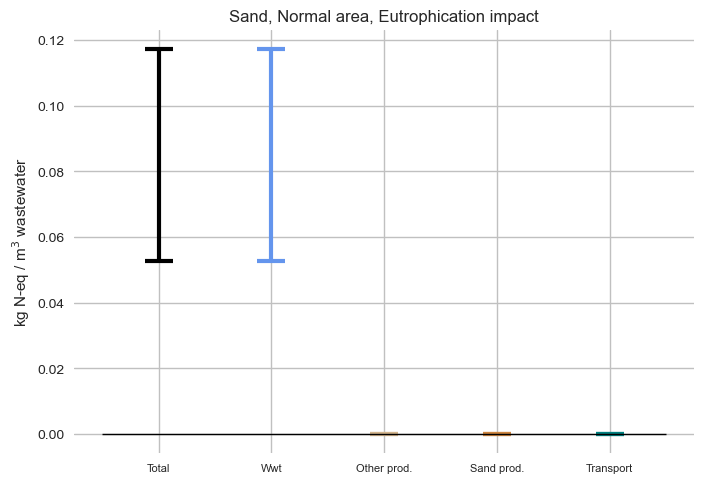

In [148]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=SN_E_med, x=1, yerr = SN_E_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SN_E_Wwt_med, x=2, yerr = SN_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SN_E_Prod_med, x=3, yerr = SN_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SN_E_SandProd_med, x=4, yerr = SN_E_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SN_E_Tr_med, x=5, yerr = SN_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Normal area, Eutrophication impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(eutroph_label)

In [89]:
#fig.savefig('CA-Sand-Normal-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [149]:
SN_A= runAlgebraicGraphTraversal([fu2], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [152]:
SN_A_Prod = SN_A[list(fu2.keys())[0]]['agg_graph']['Prod'][0]
SN_A_SandProd = SN_A[list(fu2.keys())[0]]['agg_graph']['Sand prod'][0]
SN_A_Tr = SN_A[list(fu2.keys())[0]]['agg_graph']['Transport'][0]
SN_A_Wwt = SN_A[list(fu2.keys())[0]]['agg_graph']['Treatment'][0]

In [153]:
SN_A_Prod_L = createLambda(SN_A_Prod)
SN_A_SandProd_L = createLambda(SN_A_SandProd)
SN_A_Tr_L = createLambda(SN_A_Tr)
SN_A_Wwt_L = createLambda(SN_A_Wwt)

In [154]:
SN_A_Prod_Y = _compute_stochastics([SN_A_Prod_L], CML_acid, params)
SN_A_SandProd_Y = _compute_stochastics([SN_A_SandProd_L], CML_acid, params)
SN_A_Tr_Y = _compute_stochastics([SN_A_Tr_L], CML_acid, params)
SN_A_Wwt_Y = _compute_stochastics([SN_A_Wwt_L], CML_acid, params)

In [155]:
SN_A_Prod_min, SN_A_Prod_max, SN_A_Prod_med, SN_A_Prod_e = calcMinMaxMedianError(SN_A_Prod_Y, a_string)
SN_A_SandProd_min, SN_A_SandProd_max, SN_A_SandProd_med, SN_A_SandProd_e = calcMinMaxMedianError(SN_A_SandProd_Y, a_string)
SN_A_Tr_min, SN_A_Tr_max, SN_A_Tr_med, SN_A_Tr_e = calcMinMaxMedianError(SN_A_Tr_Y, a_string)
SN_A_Wwt_min, SN_A_Wwt_max, SN_A_Wwt_med, SN_A_Wwt_e = calcMinMaxMedianError(SN_A_Wwt_Y, a_string)

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

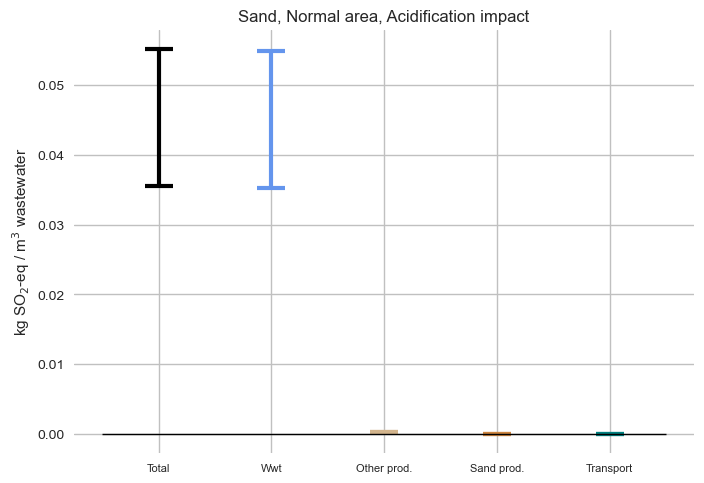

In [157]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=SN_A_med, x=1, yerr = SN_A_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SN_A_Wwt_med, x=2, yerr = SN_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SN_A_Prod_med, x=3, yerr = SN_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SN_A_SandProd_med, x=4, yerr = SN_A_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SN_A_Tr_med, x=5, yerr = SN_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Normal area, Acidification impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(acid_label)

In [98]:
#fig.savefig('CA-Sand-Normal-Acid', dpi=600, bbox_inches='tight')

#### Bc Bed Sensitive

##### Climate

In [158]:
BBS_C = runAlgebraicGraphTraversal([fu3], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [159]:
BBS_C_Prod = BBS_C[list(fu3.keys())[0]]['agg_graph']['Prod'][0]
BBS_C_BCProd = BBS_C[list(fu3.keys())[0]]['agg_graph']['BC prod'][0]
BBS_C_Heat = BBS_C[list(fu3.keys())[0]]['agg_graph']['Heat sub'][0]
BBS_C_Tr = BBS_C[list(fu3.keys())[0]]['agg_graph']['Transport'][0]
BBS_C_Cseq = BBS_C[list(fu3.keys())[0]]['agg_graph']['C seq'][0]
BBS_C_Wwt = BBS_C[list(fu3.keys())[0]]['agg_graph']['Treatment'][0]

In [160]:
BBS_C_Prod_L = createLambda(BBS_C_Prod)
BBS_C_BCProd_L = createLambda(BBS_C_BCProd)
BBS_C_Heat_L = createLambda(BBS_C_Heat)
BBS_C_Tr_L = createLambda(BBS_C_Tr)
BBS_C_Cseq_L = createLambda(BBS_C_Cseq)
BBS_C_Wwt_L = createLambda(BBS_C_Wwt)

In [161]:
BBS_C_Prod_Y = _compute_stochastics([BBS_C_Prod_L], IPCC, params)
BBS_C_BCProd_Y = _compute_stochastics([BBS_C_BCProd_L], IPCC, params)
BBS_C_Heat_Y = _compute_stochastics([BBS_C_Heat_L], IPCC, params)
BBS_C_Tr_Y = _compute_stochastics([BBS_C_Tr_L], IPCC, params)
BBS_C_Cseq_Y  = _compute_stochastics([BBS_C_Cseq_L], IPCC, params)
BBS_C_Wwt_Y = _compute_stochastics([BBS_C_Wwt_L], IPCC, params)

In [295]:
BBS_C_Prod_min, BBS_C_Prod_max, BBS_C_Prod_med, BBS_C_Prod_e = calcMinMaxMedianError(BBS_C_Prod_Y, c_string)
BBS_C_BCProd_min, BBS_C_BCProd_max, BBS_C_BCProd_med, BBS_C_BCProd_e = calcMinMaxMedianError(BBS_C_BCProd_Y, c_string)
BBS_C_Heat_min, BBS_C_Heat_max, BBS_C_Heat_med, BBS_C_Heat_e = calcMinMaxMedianError(BBS_C_Heat_Y, c_string)
BBS_C_Tr_min, BBS_C_Tr_max, BBS_C_Tr_med, BBS_C_Tr_e = calcMinMaxMedianError(BBS_C_Tr_Y, c_string)
BBS_C_Cseq_min, BBS_C_Cseq_max, BBS_C_Cseq_med, BBS_C_Cseq_e = calcMinMaxMedianError(BBS_C_Cseq_Y, c_string)
BBS_C_Wwt_min, BBS_C_Wwt_max, BBS_C_Wwt_med, BBS_C_Wwt_e = calcMinMaxMedianError(BBS_C_Wwt_Y, c_string)

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

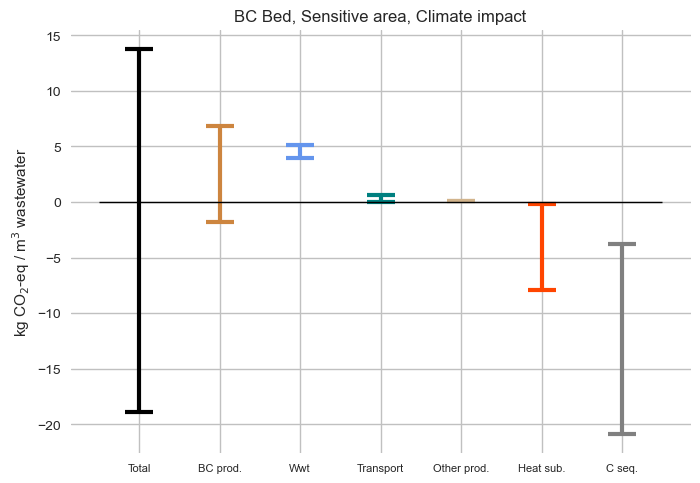

In [164]:
xlabelsBedSensitive = ('Total', 'BC prod.', 'Wwt','Transport','Other prod.','Heat sub.', 'C seq.')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_C_med, x=1, yerr = BBS_C_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_C_BCProd_med, x=2, yerr = BBS_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_C_Wwt_med, x=3, yerr = BBS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_C_Tr_med, x=4, yerr = BBS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_C_Prod_med, x=5, yerr = BBS_C_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_C_Heat_med, x=6, yerr = BBS_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BBS_C_Cseq_med, x=7, yerr = BBS_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=7.5, linewidth=1, color='black')
ax.set_title('BC Bed, Sensitive area, Climate impact')
ax.set_xticks((1,2,3,4,5,6,7))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=8)
ax.set_ylabel(climate_label)

In [111]:
#fig.savefig('CA-BCBed-Sens-Climate', dpi=600, bbox_inches='tight')

##### Eutroph - PROBLEM

In [165]:
BBS_E = runAlgebraicGraphTraversal([fu3], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [170]:
BBS_E_Prod = BBS_E[list(fu3.keys())[0]]['agg_graph']['Prod'][0]
BBS_E_BCProd = BBS_E[list(fu3.keys())[0]]['agg_graph']['BC prod'][0]
BBS_E_Heat = BBS_E[list(fu3.keys())[0]]['agg_graph']['Heat sub'][0]
BBS_E_Tr = BBS_E[list(fu3.keys())[0]]['agg_graph']['Transport'][0]
BBS_E_Wwt = BBS_E[list(fu3.keys())[0]]['agg_graph']['Treatment'][0]

In [171]:
BBS_E_Prod_L = createLambda(BBS_E_Prod)
BBS_E_BCProd_L = createLambda(BBS_E_BCProd)
BBS_E_Heat_L = createLambda(BBS_E_Heat)
BBS_E_Tr_L = createLambda(BBS_E_Tr)
BBS_E_Wwt_L = createLambda(BBS_E_Wwt)

In [168]:
BBS_E_Prod_Y = _compute_stochastics([BBS_E_Prod_L], TRACI_eut, params)
BBS_E_BCProd_Y = _compute_stochastics([BBS_E_BCProd_L], TRACI_eut, params)
BBS_E_Heat_Y = _compute_stochastics([BBS_E_Heat_L], TRACI_eut, params)
BBS_E_Tr_Y = _compute_stochastics([BBS_E_Tr_L], TRACI_eut, params)
BBS_E_Wwt_Y = _compute_stochastics([BBS_E_Wwt_L], TRACI_eut, params)

In [172]:
BBS_E_Prod_min, BBS_E_Prod_max, BBS_E_Prod_med, BBS_E_Prod_e = calcMinMaxMedianError(BBS_E_Prod_Y, e_string)
BBS_E_BCProd_min, BBS_E_BCProd_max, BBS_E_BCProd_med, BBS_E_BCProd_e = calcMinMaxMedianError(BBS_E_BCProd_Y, e_string)
BBS_E_Heat_min, BBS_E_Heat_max, BBS_E_Heat_med, BBS_E_Heat_e = calcMinMaxMedianError(BBS_E_Heat_Y, e_string)
BBS_E_Tr_min, BBS_E_Tr_max, BBS_E_Tr_med, BBS_E_Tr_e = calcMinMaxMedianError(BBS_E_Tr_Y, e_string)
BBS_E_Wwt_min, BBS_E_Wwt_max, BBS_E_Wwt_med, BBS_E_Wwt_e = calcMinMaxMedianError(BBS_E_Wwt_Y, e_string)

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

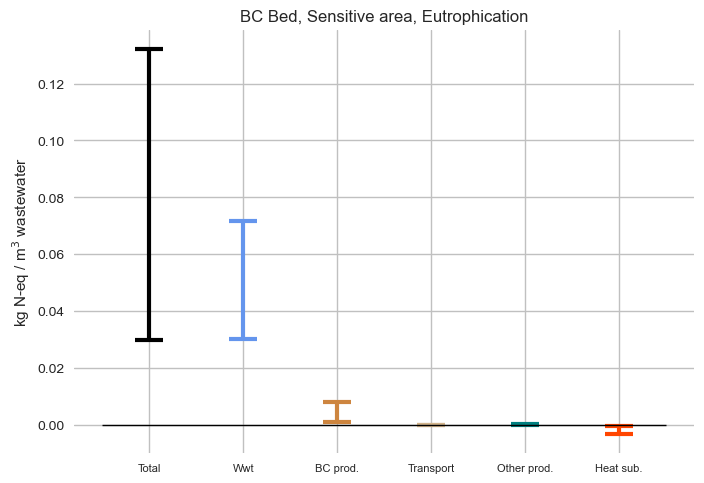

In [174]:
xlabelsBedSensitive = ('Total','Wwt', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_E_med, x=1, yerr = BBS_E_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_E_Wwt_med, x=2, yerr = BBS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_E_BCProd_med, x=3, yerr = BBS_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_E_Prod_med, x=4, yerr = BBS_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_E_Tr_med, x=5, yerr = BBS_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_E_Heat_med, x=6, yerr = BBS_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_title('BC Bed, Sensitive area, Eutrophication')
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=8)
ax.set_ylabel(eutroph_label)

In [119]:
#fig.savefig('CA-BCBed-Sens-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [175]:
BBS_A = runAlgebraicGraphTraversal([fu3], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [176]:
BBS_A_Prod = BBS_A[list(fu3.keys())[0]]['agg_graph']['Prod'][0]
BBS_A_BCProd = BBS_A[list(fu3.keys())[0]]['agg_graph']['BC prod'][0]
BBS_A_Heat = BBS_A[list(fu3.keys())[0]]['agg_graph']['Heat sub'][0]
BBS_A_Tr = BBS_A[list(fu3.keys())[0]]['agg_graph']['Transport'][0]
BBS_A_Wwt = BBS_A[list(fu3.keys())[0]]['agg_graph']['Treatment'][0]

In [177]:
BBS_A_Prod_L = createLambda(BBS_A_Prod)
BBS_A_BCProd_L = createLambda(BBS_A_BCProd)
BBS_A_Heat_L = createLambda(BBS_A_Heat)
BBS_A_Tr_L = createLambda(BBS_A_Tr)
BBS_A_Wwt_L = createLambda(BBS_A_Wwt)

In [178]:
BBS_A_Prod_Y = _compute_stochastics([BBS_A_Prod_L], CML_acid, params)
BBS_A_BCProd_Y = _compute_stochastics([BBS_A_BCProd_L], CML_acid, params)
BBS_A_Heat_Y = _compute_stochastics([BBS_A_Heat_L], CML_acid, params)
BBS_A_Tr_Y = _compute_stochastics([BBS_A_Tr_L], CML_acid, params)
BBS_A_Wwt_Y = _compute_stochastics([BBS_A_Wwt_L], CML_acid, params)

In [179]:
BBS_A_Prod_min, BBS_A_Prod_max, BBS_A_Prod_med, BBS_A_Prod_e = calcMinMaxMedianError(BBS_A_Prod_Y, a_string)
BBS_A_BCProd_min, BBS_A_BCProd_max, BBS_A_BCProd_med, BBS_A_BCProd_e = calcMinMaxMedianError(BBS_A_BCProd_Y, a_string)
BBS_A_Heat_min, BBS_A_Heat_max, BBS_A_Heat_med, BBS_A_Heat_e = calcMinMaxMedianError(BBS_A_Heat_Y, a_string)
BBS_A_Tr_min, BBS_A_Tr_max, BBS_A_Tr_med, BBS_A_Tr_e = calcMinMaxMedianError(BBS_A_Tr_Y, a_string)
BBS_A_Wwt_min, BBS_A_Wwt_max, BBS_A_Wwt_med, BBS_A_Wwt_e = calcMinMaxMedianError(BBS_A_Wwt_Y, a_string)

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

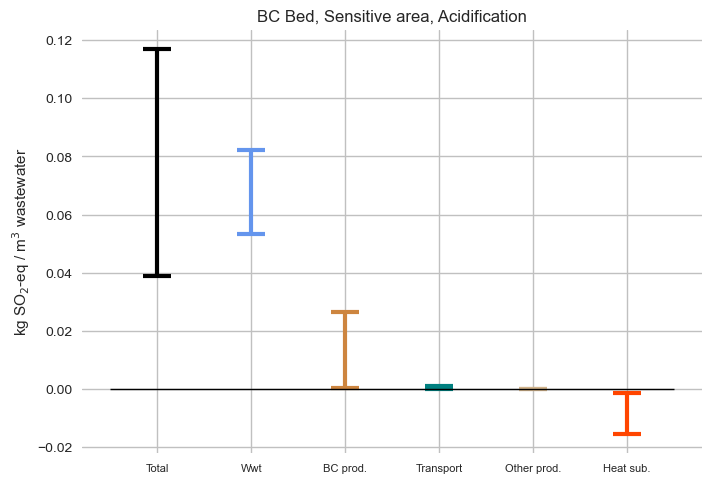

In [182]:
xlabelsBedSensitive = ('Total','Wwt', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_A_med, x=1, yerr = BBS_A_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_A_Wwt_med, x=2, yerr = BBS_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_A_BCProd_med, x=3, yerr = BBS_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_A_Tr_med, x=4, yerr = BBS_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_A_Prod_med, x=5, yerr = BBS_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_A_Heat_med, x=6, yerr = BBS_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_title('BC Bed, Sensitive area, Acidification')
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=8)
ax.set_ylabel(acid_label)

In [127]:
#fig.savefig('CA-BCBed-Sens-Acid', dpi=600, bbox_inches='tight')

#### BC Mod Sensitive

##### climate

In [166]:
BMS_C = runAlgebraicGraphTraversal([fu4], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [167]:
BMS_C_BCProd = BMS_C[list(fu4.keys())[0]]['agg_graph']['BC prod'][0]
BMS_C_Heat = BMS_C[list(fu4.keys())[0]]['agg_graph']['Heat sub'][0]
BMS_C_Tr = BMS_C[list(fu4.keys())[0]]['agg_graph']['Transport'][0]
BMS_C_BCEOL = BMS_C[list(fu4.keys())[0]]['agg_graph']['BC EOL'][0]
BMS_C_LS = BMS_C[list(fu4.keys())[0]]['agg_graph']['LS sub'][0]
BMS_C_Cseq = BMS_C[list(fu4.keys())[0]]['agg_graph']['C seq'][0]
BMS_C_Elec = BMS_C[list(fu4.keys())[0]]['agg_graph']['Elec sub'][0]
BMS_C_Wwt = BMS_C[list(fu4.keys())[0]]['agg_graph']['Treatment'][0]

In [168]:
BMS_C_BCProd_L = createLambda(BMS_C_BCProd)
BMS_C_Heat_L = createLambda(BMS_C_Heat)
BMS_C_Tr_L = createLambda(BMS_C_Tr)
BMS_C_BCEOL_L = createLambda(BMS_C_BCEOL)
BMS_C_LS_L = createLambda(BMS_C_LS)
BMS_C_Cseq_L = createLambda(BMS_C_Cseq)
BMS_C_Elec_L = createLambda(BMS_C_Elec)
BMS_C_Wwt_L = createLambda(BMS_C_Wwt)

In [169]:
BMS_C_BCProd_Y = _compute_stochastics([BMS_C_BCProd_L], IPCC, params)
BMS_C_Heat_Y = _compute_stochastics([BMS_C_Heat_L], IPCC, params)
BMS_C_Tr_Y = _compute_stochastics([BMS_C_Tr_L], IPCC, params)
BMS_C_BCEOL_Y = _compute_stochastics([BMS_C_BCEOL_L], IPCC, params)
BMS_C_LS_Y = _compute_stochastics([BMS_C_LS_L], IPCC, params)
BMS_C_Cseq_Y  = _compute_stochastics([BMS_C_Cseq_L], IPCC, params)
BMS_C_Elec_Y = _compute_stochastics([BMS_C_Elec_L], IPCC, params)
BMS_C_Wwt_Y = _compute_stochastics([BMS_C_Wwt_L], IPCC, params)

In [188]:
BMS_C_BCProd_min, BMS_C_BCProd_max, BMS_C_BCProd_med, BMS_C_BCProd_e = calcMinMaxMedianError(BMS_C_BCProd_Y, c_string)
BMS_C_Heat_min, BMS_C_Heat_max, BMS_C_Heat_med, BMS_C_Heat_e = calcMinMaxMedianError(BMS_C_Heat_Y, c_string)
BMS_C_Tr_min, BMS_C_Tr_max, BMS_C_Tr_med, BMS_C_Tr_e = calcMinMaxMedianError(BMS_C_Tr_Y, c_string)
BMS_C_BCEOL_min, BMS_C_BCEOL_max, BMS_C_BCEOL_med, BMS_C_BCEOL_e = calcMinMaxMedianError(BMS_C_BCEOL_Y, c_string)
BMS_C_LS_min, BMS_C_LS_max, BMS_C_LS_med, BMS_C_LS_e = calcMinMaxMedianError(BMS_C_LS_Y, c_string)
BMS_C_Cseq_min, BMS_C_Cseq_max, BMS_C_Cseq_med, BMS_C_Cseq_e = calcMinMaxMedianError(BMS_C_Cseq_Y, c_string)
BMS_C_Elec_min, BMS_C_Elec_max, BMS_C_Elec_med, BMS_C_Elec_e = calcMinMaxMedianError(BMS_C_Elec_Y, c_string)
BMS_C_Wwt_min, BMS_C_Wwt_max, BMS_C_Wwt_med, BMS_C_Wwt_e = calcMinMaxMedianError(BMS_C_Wwt_Y, c_string)

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

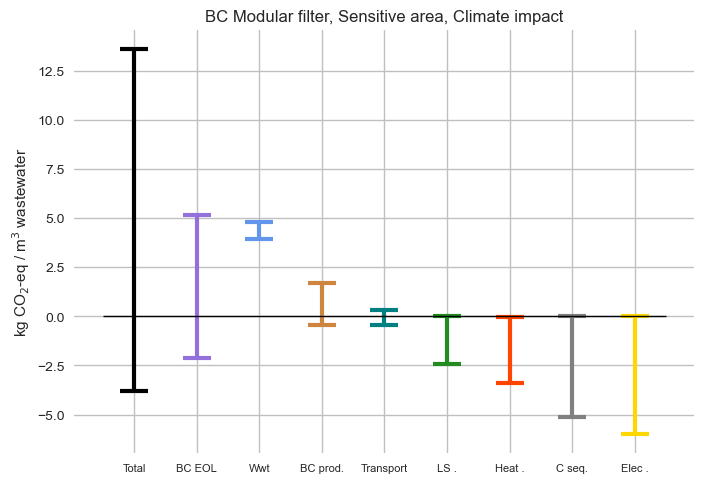

In [190]:
xlabels = ('Total','BC EOL','Wwt','BC prod.','Transport','LS .', 'Heat .', 'C seq.','Elec .')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_C_med, x=1, yerr = BMS_C_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_C_BCEOL_med, x=2, yerr = BMS_C_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_C_Wwt_med, x=3, yerr = BMS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_C_BCProd_med, x=4, yerr = BMS_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_C_Tr_med, x=5, yerr = BMS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_C_LS_med, x=6, yerr = BMS_C_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_C_Heat_med, x=7, yerr = BMS_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_C_Cseq_med, x=8, yerr = BMS_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.errorbar(y=BMS_C_Elec_med, x=9, yerr = BMS_C_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_title('BC Modular filter, Sensitive area, Climate impact')
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(climate_label)

In [135]:
#fig.savefig('CA-BCMod-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [170]:
BMS_E = runAlgebraicGraphTraversal([fu4], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [171]:
BMS_E_BCProd = BMS_E[list(fu4.keys())[0]]['agg_graph']['BC prod'][0]
BMS_E_Heat = BMS_E[list(fu4.keys())[0]]['agg_graph']['Heat sub'][0]
BMS_E_Tr = BMS_E[list(fu4.keys())[0]]['agg_graph']['Transport'][0]
BMS_E_BCEOL = BMS_E[list(fu4.keys())[0]]['agg_graph']['BC EOL'][0]
BMS_E_LS = BMS_E[list(fu4.keys())[0]]['agg_graph']['LS sub'][0]
BMS_E_Elec = BMS_E[list(fu4.keys())[0]]['agg_graph']['Elec sub'][0]
BMS_E_Wwt = BMS_E[list(fu4.keys())[0]]['agg_graph']['Treatment'][0]

In [172]:
BMS_E_BCProd_L = createLambda(BMS_E_BCProd)
BMS_E_Heat_L = createLambda(BMS_E_Heat)
BMS_E_Tr_L = createLambda(BMS_E_Tr)
BMS_E_BCEOL_L = createLambda(BMS_E_BCEOL)
BMS_E_LS_L = createLambda(BMS_E_LS)
BMS_E_Elec_L = createLambda(BMS_E_Elec)
BMS_E_Wwt_L = createLambda(BMS_E_Wwt)

In [173]:
BMS_E_BCProd_Y = _compute_stochastics([BMS_E_BCProd_L], TRACI_eut, params)
BMS_E_Heat_Y = _compute_stochastics([BMS_E_Heat_L], TRACI_eut, params)
BMS_E_Tr_Y = _compute_stochastics([BMS_E_Tr_L], TRACI_eut, params)
BMS_E_BCEOL_Y = _compute_stochastics([BMS_E_BCEOL_L], TRACI_eut, params)
BMS_E_LS_Y = _compute_stochastics([BMS_E_LS_L], TRACI_eut, params)
BMS_E_Elec_Y = _compute_stochastics([BMS_E_Elec_L], TRACI_eut, params)
BMS_E_Wwt_Y = _compute_stochastics([BMS_E_Wwt_L], TRACI_eut, params)

In [174]:
BMS_E_BCProd_min, BMS_E_BCProd_max, BMS_E_BCProd_med, BMS_E_BCProd_e = calcMinMaxMedianError(BMS_E_BCProd_Y, e_string)
BMS_E_Heat_min, BMS_E_Heat_max, BMS_E_Heat_med, BMS_E_Heat_e = calcMinMaxMedianError(BMS_E_Heat_Y, e_string)
BMS_E_Tr_min, BMS_E_Tr_max, BMS_E_Tr_med, BMS_E_Tr_e = calcMinMaxMedianError(BMS_E_Tr_Y, e_string)
BMS_E_BCEOL_min, BMS_E_BCEOL_max, BMS_E_BCEOL_med, BMS_E_BCEOL_e = calcMinMaxMedianError(BMS_E_BCEOL_Y, e_string)
BMS_E_LS_min, BMS_E_LS_max, BMS_E_LS_med, BMS_E_LS_e = calcMinMaxMedianError(BMS_E_LS_Y, e_string)
BMS_E_Elec_min, BMS_E_Elec_max, BMS_E_Elec_med, BMS_E_Elec_e = calcMinMaxMedianError(BMS_E_Elec_Y, e_string)
BMS_E_Wwt_min, BMS_E_Wwt_max, BMS_E_Wwt_med, BMS_E_Wwt_e = calcMinMaxMedianError(BMS_E_Wwt_Y, e_string)

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

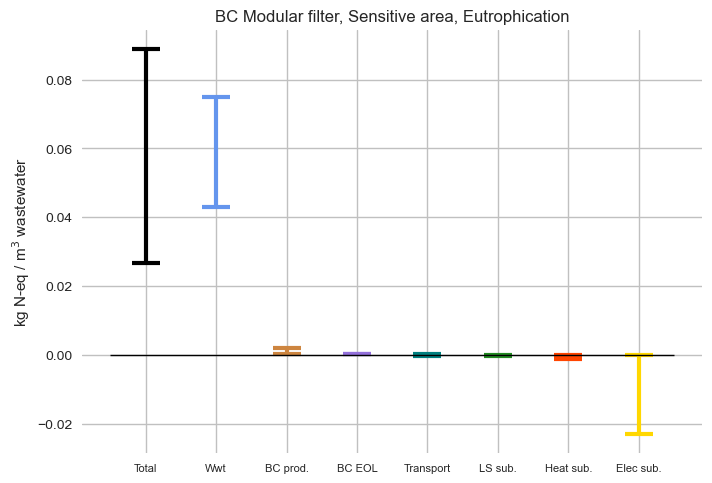

In [197]:
xlabels = ('Total','Wwt','BC prod.','BC EOL','Transport','LS sub.', 'Heat sub.', 'Elec sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_E_med, x=1, yerr = BMS_E_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_E_Wwt_med, x=2, yerr = BMS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_E_BCProd_med, x=3, yerr = BMS_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_E_BCEOL_med, x=4, yerr = BMS_E_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_E_Tr_med, x=5, yerr = BMS_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_E_LS_med, x=6, yerr = BMS_E_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_E_Heat_med, x=7, yerr = BMS_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_E_Elec_med, x=8, yerr = BMS_E_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_title('BC Modular filter, Sensitive area, Eutrophication')
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(eutroph_label)

In [143]:
#fig.savefig('CA-BCMod-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [175]:
BMS_A = runAlgebraicGraphTraversal([fu4], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [176]:
BMS_A_BCProd = BMS_A[list(fu4.keys())[0]]['agg_graph']['BC prod'][0]
BMS_A_Heat = BMS_A[list(fu4.keys())[0]]['agg_graph']['Heat sub'][0]
BMS_A_Tr = BMS_A[list(fu4.keys())[0]]['agg_graph']['Transport'][0]
BMS_A_BCEOL = BMS_A[list(fu4.keys())[0]]['agg_graph']['BC EOL'][0]
BMS_A_LS = BMS_A[list(fu4.keys())[0]]['agg_graph']['LS sub'][0]
BMS_A_Elec = BMS_A[list(fu4.keys())[0]]['agg_graph']['Elec sub'][0]
BMS_A_Wwt = BMS_A[list(fu4.keys())[0]]['agg_graph']['Treatment'][0]

In [177]:
BMS_A_BCProd_L = createLambda(BMS_A_BCProd)
BMS_A_Heat_L = createLambda(BMS_A_Heat)
BMS_A_Tr_L = createLambda(BMS_A_Tr)
BMS_A_BCEOL_L = createLambda(BMS_A_BCEOL)
BMS_A_LS_L = createLambda(BMS_A_LS)
BMS_A_Elec_L = createLambda(BMS_A_Elec)
BMS_A_Wwt_L = createLambda(BMS_A_Wwt)

In [178]:
BMS_A_BCProd_Y = _compute_stochastics([BMS_A_BCProd_L], CML_acid, params)
BMS_A_Heat_Y = _compute_stochastics([BMS_A_Heat_L], CML_acid, params)
BMS_A_Tr_Y = _compute_stochastics([BMS_A_Tr_L], CML_acid, params)
BMS_A_BCEOL_Y = _compute_stochastics([BMS_A_BCEOL_L], CML_acid, params)
BMS_A_LS_Y = _compute_stochastics([BMS_A_LS_L], CML_acid, params)
BMS_A_Elec_Y = _compute_stochastics([BMS_A_Elec_L], CML_acid, params)
BMS_A_Wwt_Y = _compute_stochastics([BMS_A_Wwt_L], CML_acid, params)

In [179]:
BMS_A_BCProd_min, BMS_A_BCProd_max, BMS_A_BCProd_med, BMS_A_BCProd_e = calcMinMaxMedianError(BMS_A_BCProd_Y, a_string)
BMS_A_Heat_min, BMS_A_Heat_max, BMS_A_Heat_med, BMS_A_Heat_e = calcMinMaxMedianError(BMS_A_Heat_Y, a_string)
BMS_A_Tr_min, BMS_A_Tr_max, BMS_A_Tr_med, BMS_A_Tr_e = calcMinMaxMedianError(BMS_A_Tr_Y, a_string)
BMS_A_BCEOL_min, BMS_A_BCEOL_max, BMS_A_BCEOL_med, BMS_A_BCEOL_e = calcMinMaxMedianError(BMS_A_BCEOL_Y, a_string)
BMS_A_LS_min, BMS_A_LS_max, BMS_A_LS_med, BMS_A_LS_e = calcMinMaxMedianError(BMS_A_LS_Y, a_string)
BMS_A_Elec_min, BMS_A_Elec_max, BMS_A_Elec_med, BMS_A_Elec_e = calcMinMaxMedianError(BMS_A_Elec_Y, a_string)
BMS_A_Wwt_min, BMS_A_Wwt_max, BMS_A_Wwt_med, BMS_A_Wwt_e = calcMinMaxMedianError(BMS_A_Wwt_Y, a_string)

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

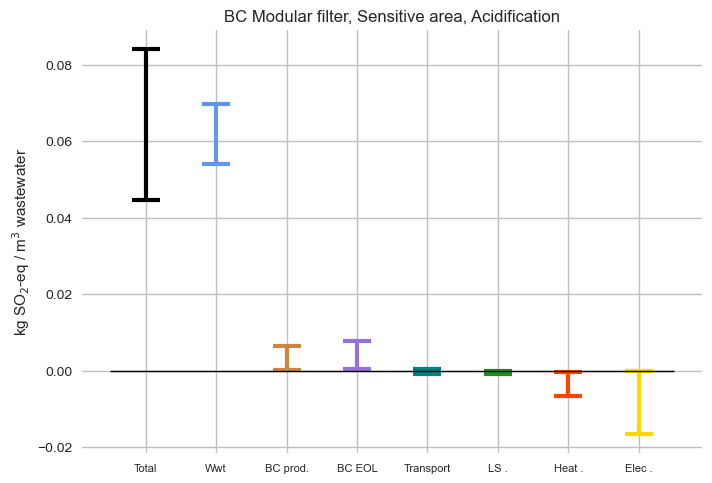

In [204]:
xlabels = ('Total','Wwt', 'BC prod.','BC EOL', 'Transport','LS .', 'Heat .', 'Elec .')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_A_med, x=1, yerr = BMS_A_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_A_Wwt_med, x=2, yerr = BMS_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_A_BCProd_med, x=3, yerr = BMS_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_A_BCEOL_med, x=4, yerr = BMS_A_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_A_Tr_med, x=5, yerr = BMS_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_A_LS_med, x=6, yerr = BMS_A_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_A_Heat_med, x=7, yerr = BMS_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_A_Elec_med, x=8, yerr = BMS_A_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_title('BC Modular filter, Sensitive area, Acidification')
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=8)
ax.set_ylabel(acid_label)

In [151]:
#fig.savefig('CA-BCMod-Acid', dpi=600, bbox_inches='tight')

#### Sand sensitive

##### climate

In [199]:
SS_C = runAlgebraicGraphTraversal([fu5], IPCC, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [205]:
SS_C_Prod = SS_C[list(fu5.keys())[0]]['agg_graph']['Prod'][0]
SS_C_SandProd = SS_C[list(fu5.keys())[0]]['agg_graph']['Sand prod'][0]
SS_C_Tr = SS_C[list(fu5.keys())[0]]['agg_graph']['Transport'][0]
SS_C_Wwt = SS_C[list(fu5.keys())[0]]['agg_graph']['Treatment'][0]

In [206]:
SS_C_Prod_L = createLambda(SS_C_Prod)
SS_C_SandProd_L = createLambda(SS_C_SandProd)
SS_C_Tr_L = createLambda(SS_C_Tr)
SS_C_Wwt_L = createLambda(SS_C_Wwt)

In [207]:
SS_C_Prod_Y = _compute_stochastics([SS_C_Prod_L], IPCC, params)
SS_C_SandProd_Y = _compute_stochastics([SS_C_SandProd_L], IPCC, params)
SS_C_Tr_Y = _compute_stochastics([SS_C_Tr_L], IPCC, params)
SS_C_Wwt_Y = _compute_stochastics([SS_C_Wwt_L], IPCC, params)

In [208]:
SS_C_Prod_min, SS_C_Prod_max, SS_C_Prod_med, SS_C_Prod_e = calcMinMaxMedianError(SS_C_Prod_Y, c_string)
SS_C_SandProd_min, SS_C_SandProd_max, SS_C_SandProd_med, SS_C_SandProd_e = calcMinMaxMedianError(SS_C_SandProd_Y, c_string)
SS_C_Tr_min, SS_C_Tr_max, SS_C_Tr_med, SS_C_Tr_e = calcMinMaxMedianError(SS_C_Tr_Y, c_string)
SS_C_Wwt_min, SS_C_Wwt_max, SS_C_Wwt_med, SS_C_Wwt_e = calcMinMaxMedianError(SS_C_Wwt_Y, c_string)

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

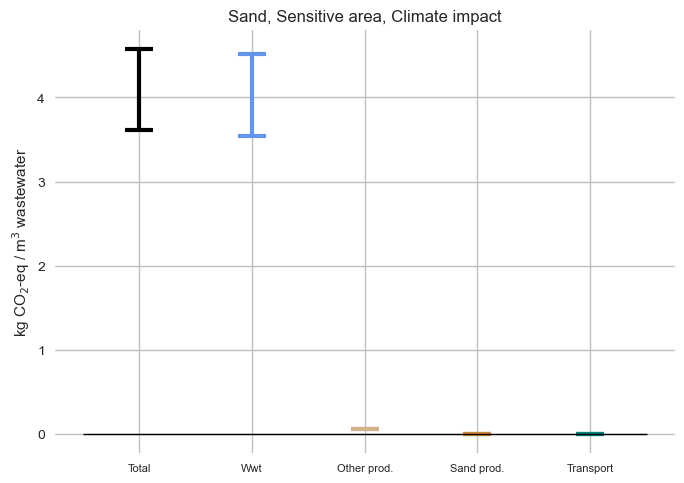

In [209]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=SS_C_med, x=1, yerr = SS_C_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_C_Wwt_med, x=2, yerr = SS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_C_Prod_med, x=3, yerr = SS_C_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_C_SandProd_med, x=4, yerr = SS_C_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_C_Tr_med, x=5, yerr = SS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Sensitive area, Climate impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(climate_label)

In [162]:
#fig.savefig('CA-Sand-Sensitive-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [210]:
SS_E = runAlgebraicGraphTraversal([fu5], TRACI_eut, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [211]:
SS_E_Prod = SS_E[list(fu5.keys())[0]]['agg_graph']['Prod'][0]
SS_E_SandProd = SS_E[list(fu5.keys())[0]]['agg_graph']['Sand prod'][0]
SS_E_Tr = SS_E[list(fu5.keys())[0]]['agg_graph']['Transport'][0]
SS_E_Wwt = SS_E[list(fu5.keys())[0]]['agg_graph']['Treatment'][0]

In [212]:
SS_E_Prod_L = createLambda(SS_E_Prod)
SS_E_SandProd_L = createLambda(SS_E_SandProd)
SS_E_Tr_L = createLambda(SS_E_Tr)
SS_E_Wwt_L = createLambda(SS_E_Wwt)

In [213]:
SS_E_Prod_Y = _compute_stochastics([SS_E_Prod_L], TRACI_eut, params)
SS_E_SandProd_Y = _compute_stochastics([SS_E_SandProd_L], TRACI_eut, params)
SS_E_Tr_Y = _compute_stochastics([SS_E_Tr_L], TRACI_eut, params)
SS_E_Wwt_Y = _compute_stochastics([SS_E_Wwt_L], TRACI_eut, params)

In [214]:
SS_E_Prod_min, SS_E_Prod_max, SS_E_Prod_med, SS_E_Prod_e = calcMinMaxMedianError(SS_E_Prod_Y, e_string)
SS_E_SandProd_min, SS_E_SandProd_max, SS_E_SandProd_med, SS_E_SandProd_e = calcMinMaxMedianError(SS_E_SandProd_Y, e_string)
SS_E_Tr_min, SS_E_Tr_max, SS_E_Tr_med, SS_E_Tr_e = calcMinMaxMedianError(SS_E_Tr_Y, e_string)
SS_E_Wwt_min, SS_E_Wwt_max, SS_E_Wwt_med, SS_E_Wwt_e = calcMinMaxMedianError(SS_E_Wwt_Y, e_string)

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

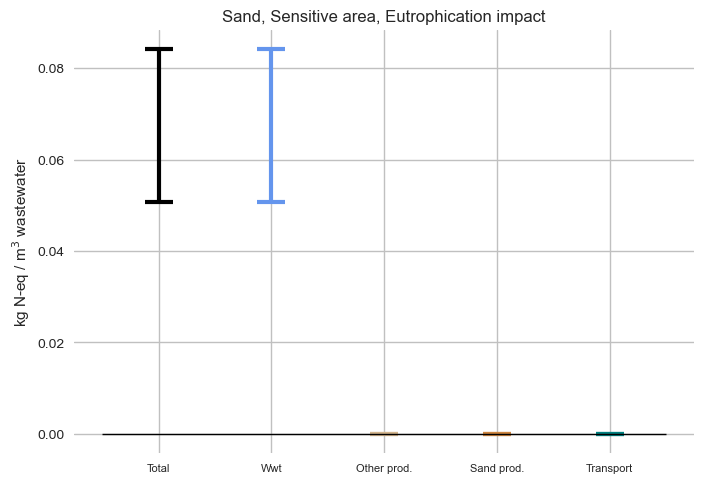

In [215]:
xlabelsSand = ('Total', 'Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=SS_E_med, x=1, yerr = SS_E_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_E_Wwt_med, x=2, yerr = SS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_E_Prod_med, x=3, yerr = SS_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_E_SandProd_med, x=4, yerr = SS_E_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_E_Tr_med, x=5, yerr = SS_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Sensitive area, Eutrophication impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(eutroph_label)

In [170]:
#fig.savefig('CA-Sand-Sensitive-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [216]:
SS_A = runAlgebraicGraphTraversal([fu5], CML_acid, label="label_name", default_tag="other",
    fg_databases=[fg], bio2tech=True, parent4other=True)

In [217]:
SS_A_Prod = SS_A[list(fu5.keys())[0]]['agg_graph']['Prod'][0]
SS_A_SandProd = SS_A[list(fu5.keys())[0]]['agg_graph']['Sand prod'][0]
SS_A_Tr = SS_A[list(fu5.keys())[0]]['agg_graph']['Transport'][0]
SS_A_Wwt = SS_A[list(fu5.keys())[0]]['agg_graph']['Treatment'][0]

In [220]:
SS_A_Prod_L = createLambda(SS_A_Prod)
SS_A_SandProd_L = createLambda(SS_A_SandProd)
SS_A_Tr_L = createLambda(SS_A_Tr)
SS_A_Wwt_L = createLambda(SS_A_Wwt)

In [ ]:
SS_A_Prod_Y = _compute_stochastics([SS_A_Prod_L], CML_acid, params)
SS_A_SandProd_Y = _compute_stochastics([SS_A_SandProd_L], CML_acid, params)
SS_A_Tr_Y = _compute_stochastics([SS_A_Tr_L], CML_acid, params)
SS_A_Wwt_Y = _compute_stochastics([SS_A_Wwt_L], CML_acid, params)

In [223]:
SS_A_Prod_min, SS_A_Prod_max, SS_A_Prod_med, SS_A_Prod_e = calcMinMaxMedianError(SS_A_Prod_Y, a_string)
SS_A_SandProd_min, SS_A_SandProd_max, SS_A_SandProd_med, SS_A_SandProd_e = calcMinMaxMedianError(SS_A_SandProd_Y, a_string)
SS_A_Tr_min, SS_A_Tr_max, SS_A_Tr_med, SS_A_Tr_e = calcMinMaxMedianError(SS_A_Tr_Y, a_string)
SS_A_Wwt_min, SS_A_Wwt_max, SS_A_Wwt_med, SS_A_Wwt_e = calcMinMaxMedianError(SS_A_Wwt_Y, a_string)

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

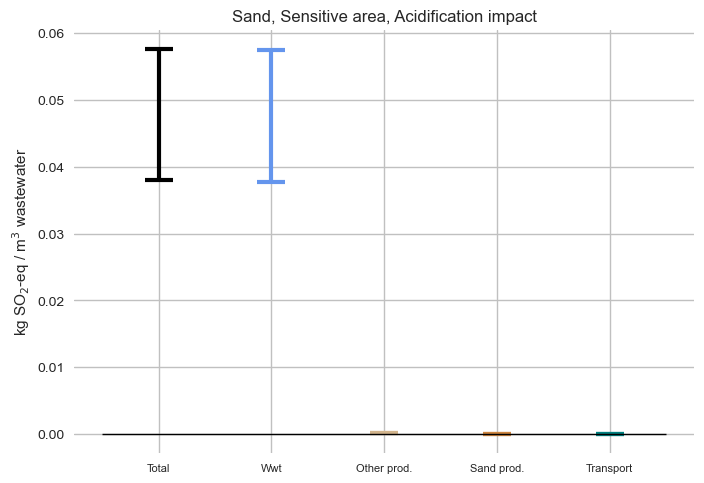

In [224]:
xlabelsSand = ('Total','Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=SS_A_med, x=1, yerr = SS_A_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_A_Wwt_med, x=2, yerr = SS_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_A_Prod_med, x=3, yerr = SS_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_A_SandProd_med, x=4, yerr = SS_A_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_A_Tr_med, x=5, yerr = SS_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=5.5, linewidth=1, color='black')
ax.set_title('Sand, Sensitive area, Acidification impact')
ax.set_xticks((1,2,3,4,5))
ax.set_xticklabels(xlabelsSand, fontsize=8)
ax.set_ylabel(acid_label)

In [178]:
#fig.savefig('CA-Sand-Sensitive-Acid', dpi=600, bbox_inches='tight')

### scenario results (fig 6, good examples)

Before we run this - define Y:s for each bc system and impact cat (not sands though we already have them)

sc = scenario

Which scenarios are interesting?

- BC Bed, normal, renewable, LS, LR (100% climate, 0.52% eutroph, 88.19% acid)
- BC Bed, sensitive, GW-S, fossil. (100% climate, 91.42% eutroph, 9.63% acid)
- BC Mod, fossil, LS, GW-S (100% climate, 96.45% eutroph, 0% acid)

#### BC Bed Normal

In [225]:
BN_sc = pd.DataFrame.from_dict(params)

In [229]:
BN_sc['Climate'] = Y1['Climate'].values
BN_sc['Eutroph.'] = Y1['Eutroph.'].values
BN_sc['Acid.'] = Y1['Acid.'].values

In [230]:
BN_sc['BN_C_Prod'] = BN_C_Prod_Y[c_string].values
BN_sc['BN_C_BCProd'] = BN_C_BCProd_Y[c_string].values
BN_sc['BN_C_Heat'] = BN_C_Heat_Y[c_string].values
BN_sc['BN_C_Tr'] = BN_C_Tr_Y[c_string].values
BN_sc['BN_C_BCEOL'] = BN_C_BCEOL_Y[c_string].values
BN_sc['BN_C_Cseq'] = BN_C_Cseq_Y[c_string].values
BN_sc['BN_C_Elec'] = BN_C_Elec_Y[c_string].values
BN_sc['BN_C_Wwt'] = BN_C_Wwt_Y[c_string].values

BN_sc['BN_E_Prod'] = BN_E_Prod_Y[e_string].values
BN_sc['BN_E_BCProd'] = BN_E_BCProd_Y[e_string].values
BN_sc['BN_E_Heat'] = BN_E_Heat_Y[e_string].values
BN_sc['BN_E_Tr'] = BN_E_Tr_Y[e_string].values
BN_sc['BN_E_BCEOL'] = BN_E_BCEOL_Y[e_string].values
BN_sc['BN_E_Elec'] = BN_E_Elec_Y[e_string].values
BN_sc['BN_E_Wwt'] = BN_E_Wwt_Y[e_string].values

BN_sc['BN_A_Prod'] = BN_A_Prod_Y[a_string].values
BN_sc['BN_A_BCProd'] = BN_A_BCProd_Y[a_string].values
BN_sc['BN_A_Heat'] = BN_A_Heat_Y[a_string].values
BN_sc['BN_A_Tr'] = BN_A_Tr_Y[a_string].values
BN_sc['BN_A_BCEOL'] = BN_A_BCEOL_Y[a_string].values
BN_sc['BN_A_Elec'] = BN_A_Elec_Y[a_string].values
BN_sc['BN_A_Wwt'] = BN_A_Wwt_Y[a_string].values

In [233]:
# bc7 (WC), fossil energy, EOL = CHP
BN_sc = BN_sc.loc[(BN_sc['bc_HLswitch_param'] == 'bc7HL') & 
                     (BN_sc['bc_Seqswitch_param'] == 'bc7Seq') &
                     (BN_sc['heat_switch_param'] == 'heatNaturalGas') &
                     (BN_sc['elec_switch_param'] == 'elecCoal') &
                     (BN_sc['EOL7_switch_param'] == 'CHP4')]

In [235]:
BN_sc['C_sum'] = BN_sc['BN_C_Prod'] + BN_sc['BN_C_BCProd'] + BN_sc['BN_C_Heat'] +BN_sc['BN_C_Tr'] + BN_sc['BN_C_BCEOL'] + BN_sc['BN_C_LS'] + BN_sc['BN_C_Cseq'] +BN_sc['BN_C_Elec'] + BN_sc['BN_C_Wwt']
BN_sc['E_sum'] = BN_sc['BN_E_Prod'] + BN_sc['BN_E_BCProd'] + BN_sc['BN_E_Heat'] +BN_sc['BN_E_Tr'] + BN_sc['BN_E_BCEOL'] + BN_sc['BN_E_LS'] +BN_sc['BN_E_Elec'] + BN_sc['BN_E_Wwt']
BN_sc['A_sum'] = BN_sc['BN_A_Prod'] + BN_sc['BN_A_BCProd'] + BN_sc['BN_A_Heat'] +BN_sc['BN_A_Tr'] + BN_sc['BN_A_BCEOL'] + BN_sc['BN_A_LS'] +BN_sc['BN_A_Elec'] + BN_sc['BN_A_Wwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_9680\1419319711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BN_sc['C_sum'] = BN_sc['BN_C_Prod'] + BN_sc['BN_C_BCProd'] + BN_sc['BN_C_Heat'] +BN_sc['BN_C_Tr'] + BN_sc['BN_C_BCEOL'] + BN_sc['BN_C_LS'] + BN_sc['BN_C_Cseq'] +BN_sc['BN_C_Elec'] + BN_sc['BN_C_Wwt']
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_9680\1419319711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BN_sc['E_sum'] = BN_sc['BN_E_Prod'] + BN_sc['BN_E_BCProd'] + BN_sc['BN_E_Heat'] +B

##### climate

In [247]:
BN_C_Tot_min, BN_C_Tot_max, BN_C_Tot_med, BN_C_Tot_e = calcMinMaxMedianError(BN_sc, 'C_sum')
BN_C_Prod_min, BN_C_Prod_max, BN_C_Prod_med, BN_C_Prod_e = calcMinMaxMedianError(BN_sc, 'BN_C_Prod')
BN_C_BCProd_min, BN_C_BCProd_max, BN_C_BCProd_med, BN_C_BCProd_e = calcMinMaxMedianError(BN_sc, 'BN_C_BCProd')
BN_C_Heat_min, BN_C_Heat_max, BN_C_Heat_med, BN_C_Heat_e = calcMinMaxMedianError(BN_sc, 'BN_C_Heat')
BN_C_Tr_min, BN_C_Tr_max, BN_C_Tr_med, BN_C_Tr_e = calcMinMaxMedianError(BN_sc, 'BN_C_Tr')
BN_C_BCEOL_min, BN_C_BCEOL_max, BN_C_BCEOL_med, BN_C_BCEOL_e = calcMinMaxMedianError(BN_sc, 'BN_C_BCEOL')
BN_C_Cseq_min, BN_C_Cseq_max, BN_C_Cseq_med, BN_C_Cseq_e = calcMinMaxMedianError(BN_sc, 'BN_C_Cseq')
BN_C_Elec_min, BN_C_Elec_max, BN_C_Elec_med, BN_C_Elec_e = calcMinMaxMedianError(BN_sc, 'BN_C_Elec')
BN_C_Wwt_min, BN_C_Wwt_max, BN_C_Wwt_med, BN_C_Wwt_e = calcMinMaxMedianError(BN_sc, 'BN_C_Wwt')

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

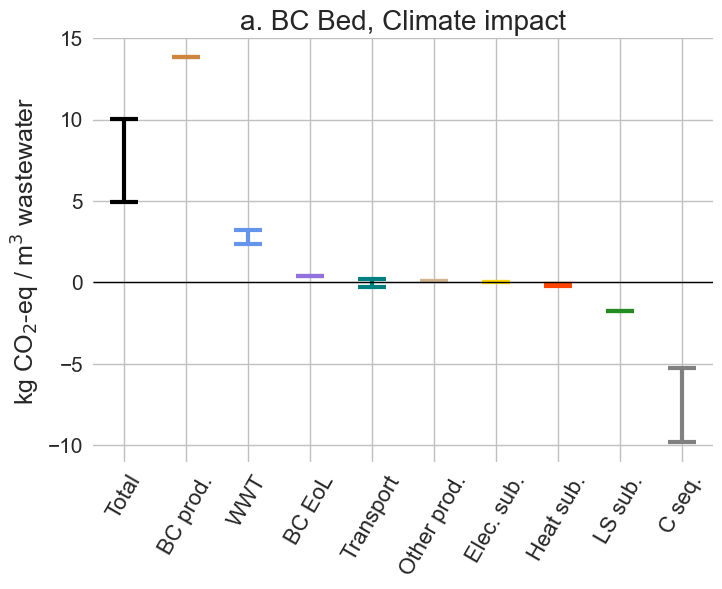

In [250]:
fig, ax = plt.subplots()

xlabels = ('Total', 'BC prod.', 'BC EoL', 'WWT', 'Transport', 'Other prod.', 'Heat sub.', 'Elec. sub.', 'C seq.')

ax.errorbar(y=BN_C_Tot_med, x=1, yerr = BN_C_Tot_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BN_C_BCProd_med, x=2, yerr = BN_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_C_BCEOL_med, x=3, yerr = BN_C_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BN_C_Wwt_med, x=4, yerr = BN_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BN_C_Tr_med, x=5, yerr = BN_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BN_C_Prod_med, x=6, yerr = BN_C_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BN_C_Heat_med, x=7, yerr = BN_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BN_C_Elec_med, x=8, yerr = BN_C_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.errorbar(y=BN_C_Cseq_med, x=9, yerr = BN_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_xlim(0.5,9.5)

ax.set_facecolor('white')
ax.grid(color='silver')

ax.set_title('a. BC Bed, Climate impact', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(climate_label, fontsize=18)

In [256]:
#fig.savefig('Scenario-BCBed-Normal-Climate', dpi=600, bbox_inches='tight')

##### eutroph

In [254]:
BN_E_Tot_min, BN_E_Tot_max, BN_E_Tot_med, BN_E_Tot_e = calcMinMaxMedianError(BN_sc, 'E_sum')
BN_E_Prod_min, BN_E_Prod_max, BN_E_Prod_med, BN_E_Prod_e = calcMinMaxMedianError(BN_sc, 'BN_E_Prod')
BN_E_BCProd_min, BN_E_BCProd_max, BN_E_BCProd_med, BN_E_BCProd_e = calcMinMaxMedianError(BN_sc, 'BN_E_BCProd')
BN_E_Heat_min, BN_E_Heat_max, BN_E_Heat_med, BN_E_Heat_e = calcMinMaxMedianError(BN_sc, 'BN_E_Heat')
BN_E_Tr_min, BN_E_Tr_max, BN_E_Tr_med, BN_E_Tr_e = calcMinMaxMedianError(BN_sc, 'BN_E_Tr')
BN_E_BCEOL_min, BN_E_BCEOL_max, BN_E_BCEOL_med, BN_E_BCEOL_e = calcMinMaxMedianError(BN_sc, 'BN_E_BCEOL')
BN_E_Elec_min, BN_E_Elec_max, BN_E_Elec_med, BN_E_Elec_e = calcMinMaxMedianError(BN_sc, 'BN_E_Elec')
BN_E_Wwt_min, BN_E_Wwt_max, BN_E_Wwt_med, BN_E_Wwt_e = calcMinMaxMedianError(BN_sc, 'BN_E_Wwt')

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

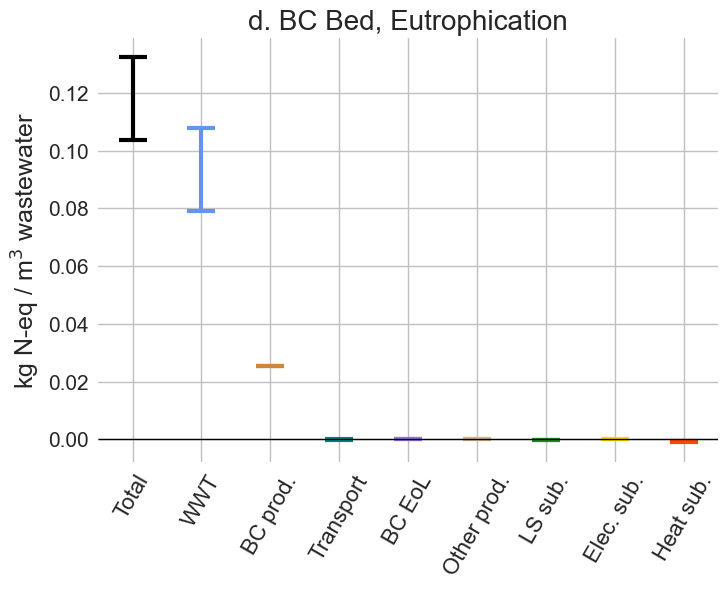

In [255]:
fig, ax = plt.subplots()

xlabels = ('Total', 'WWT', 'BC prod.', 'Transport', 'BC EoL', 'Other prod.', 'Heat sub.', 'Elec. sub.')

ax.errorbar(y=BN_E_Tot_med, x=1, yerr = BN_E_Tot_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BN_E_Wwt_med, x=2, yerr = BN_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BN_E_BCProd_med, x=3, yerr = BN_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_E_Tr_med, x=4, yerr = BN_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BN_E_BCEOL_med, x=5, yerr = BN_E_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BN_E_Prod_med, x=6, yerr = BN_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BN_E_Heat_med, x=7, yerr = BN_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BN_E_Elec_med, x=8, yerr = BN_E_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_xlim(0.5,8.5)
ax.set_title('d. BC Bed, Eutrophication',fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(eutroph_label,fontsize=18)

In [258]:
#fig.savefig('Scenario-BCBed-Normal-Eutroph', dpi=600, bbox_inches='tight')

##### acid

In [256]:
BN_A_Tot_min, BN_A_Tot_max, BN_A_Tot_med, BN_A_Tot_e = calcMinMaxMedianError(BN_sc, 'A_sum')
BN_A_Prod_min, BN_A_Prod_max, BN_A_Prod_med, BN_A_Prod_e = calcMinMaxMedianError(BN_sc, 'BN_A_Prod')
BN_A_BCProd_min, BN_A_BCProd_max, BN_A_BCProd_med, BN_A_BCProd_e = calcMinMaxMedianError(BN_sc, 'BN_A_BCProd')
BN_A_Heat_min, BN_A_Heat_max, BN_A_Heat_med, BN_A_Heat_e = calcMinMaxMedianError(BN_sc, 'BN_A_Heat')
BN_A_Tr_min, BN_A_Tr_max, BN_A_Tr_med, BN_A_Tr_e = calcMinMaxMedianError(BN_sc, 'BN_A_Tr')
BN_A_BCEOL_min, BN_A_BCEOL_max, BN_A_BCEOL_med, BN_A_BCEOL_e = calcMinMaxMedianError(BN_sc, 'BN_A_BCEOL')
BN_A_Elec_min, BN_A_Elec_max, BN_A_Elec_med, BN_A_Elec_e = calcMinMaxMedianError(BN_sc, 'BN_A_Elec')
BN_A_Wwt_min, BN_A_Wwt_max, BN_A_Wwt_med, BN_A_Wwt_e = calcMinMaxMedianError(BN_sc, 'BN_A_Wwt')

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

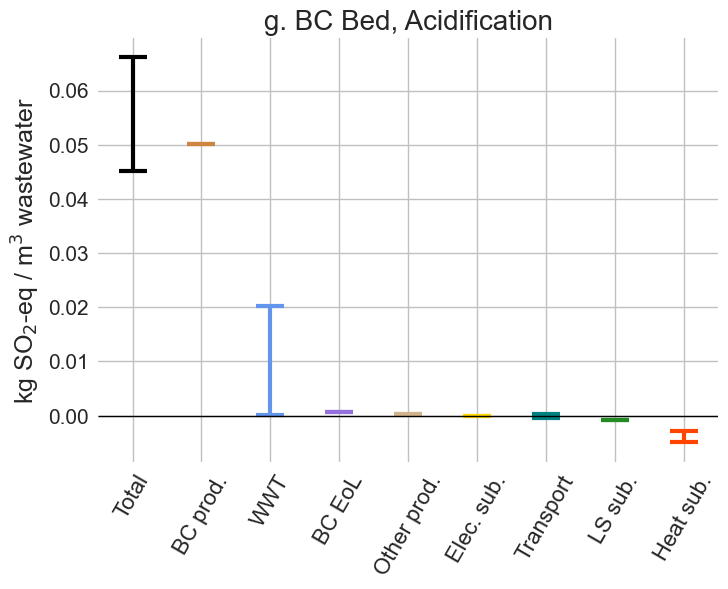

In [257]:
xlabels = ('Total','BC prod.', 'WWT', 'BC EoL', 'Transport', 'Other prod.', 'Heat sub.', 'Elec. sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BN_A_Tot_med, x=1, yerr = BN_A_Tot_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BN_A_BCProd_med, x=2, yerr = BN_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BN_A_Wwt_med, x=3, yerr = BN_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BN_A_BCEOL_med, x=4, yerr = BN_A_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BN_A_Tr_med, x=5, yerr = BN_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BN_A_Prod_med, x=6, yerr = BN_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BN_A_Heat_med, x=7, yerr = BN_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BN_A_Elec_med, x=8, yerr = BN_A_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_xlim(0.5,8.5)
ax.set_title('g. BC Bed, Acidification',fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(acid_label,fontsize=18)

In [260]:
#fig.savefig('Scenario-BCBed-Normal-Acid', dpi=600, bbox_inches='tight')

#### BC Bed Sensitive - PROBLEM

In [277]:
BBS_sc = pd.DataFrame.from_dict(params)

In [278]:
BBS_sc['Climate'] = Y3['Climate'].values
BBS_sc['Eutroph'] = Y3['Eutroph.'].values
BBS_sc['Acid'] = Y3['Acid.'].values

In [300]:
BBS_sc['BBS_C_Prod'] = BBS_C_Prod_Y[c_string].values
BBS_sc['BBS_C_BCProd'] = BBS_C_BCProd_Y[c_string].values
BBS_sc['BBS_C_Heat'] = BBS_C_Heat_Y[c_string].values
BBS_sc['BBS_C_Tr'] = BBS_C_Tr_Y[c_string].values
BBS_sc['BBS_C_Cseq'] = BBS_C_Cseq_Y[c_string].values
BBS_sc['BBS_C_Wwt'] = BBS_C_Wwt_Y[c_string].values

BBS_sc['BBS_E_Prod'] = BBS_E_Prod_Y[e_string].values
BBS_sc['BBS_E_BCProd'] = BBS_E_BCProd_Y[e_string].values
BBS_sc['BBS_E_Heat'] = BBS_E_Heat_Y[e_string].values
BBS_sc['BBS_E_Tr'] = BBS_E_Tr_Y[e_string].values
BBS_sc['BBS_E_Wwt'] = BBS_E_Wwt_Y[e_string].values

BBS_sc['BBS_A_Prod'] = BBS_A_Prod_Y[a_string].values
BBS_sc['BBS_A_BCProd'] = BBS_A_BCProd_Y[a_string].values
BBS_sc['BBS_A_Heat'] = BBS_A_Heat_Y[a_string].values
BBS_sc['BBS_A_Tr'] = BBS_A_Tr_Y[a_string].values
BBS_sc['BBS_A_Wwt'] = BBS_A_Wwt_Y[a_string].values

In [301]:
# bc3 (only BCseq applicable), fossil energy (No EOL)
BBS_sc = BBS_sc.loc[(BBS_sc['bc_Seqswitch_param'] == 'bc3Seq') &
                     (BBS_sc['heat_switch_param'] == 'heatNaturalGas') &
                     (BBS_sc['elec_switch_param'] == 'elecCoal')]

In [302]:
BBS_sc['C_sum'] = BBS_sc['BBS_C_Prod'] + BBS_sc['BBS_C_BCProd'] + BBS_sc['BBS_C_Heat'] +BBS_sc['BBS_C_Tr'] + BBS_sc['BBS_C_Cseq'] + BBS_sc['BBS_C_Wwt']
BBS_sc['E_sum'] = BBS_sc['BBS_E_Prod'] + BBS_sc['BBS_E_BCProd'] + BBS_sc['BBS_E_Heat'] +BBS_sc['BBS_E_Tr'] + BBS_sc['BBS_E_Wwt']
BBS_sc['A_sum'] = BBS_sc['BBS_A_Prod'] + BBS_sc['BBS_A_BCProd'] + BBS_sc['BBS_A_Heat'] +BBS_sc['BBS_A_Tr'] + BBS_sc['BBS_A_Wwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_9680\1617376666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BBS_sc['C_sum'] = BBS_sc['BBS_C_Prod'] + BBS_sc['BBS_C_BCProd'] + BBS_sc['BBS_C_Heat'] +BBS_sc['BBS_C_Tr'] + BBS_sc['BBS_C_Cseq'] + BBS_sc['BBS_C_Wwt']
C:\Users\lizn0001\AppData\Local\Temp\ipykernel_9680\1617376666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BBS_sc['E_sum'] = BBS_sc['BBS_E_Prod'] + BBS_sc['BBS_E_BCProd'] + BBS_sc['BBS_E_Heat'] +BBS_sc['BBS_E_Tr'] + BBS_sc['BBS_E_Wwt']
C

##### climate

In [303]:
BBS_C_Tot_min, BBS_C_Tot_max, BBS_C_Tot_med, BBS_C_Tot_e = calcMinMaxMedianError(BBS_sc, 'C_sum')
BBS_C_Prod_min, BBS_C_Prod_max, BBS_C_Prod_med, BBS_C_Prod_e = calcMinMaxMedianError(BBS_sc, 'BBS_C_Prod')
BBS_C_BCProd_min, BBS_C_BCProd_max, BBS_C_BCProd_med, BBS_C_BCProd_e = calcMinMaxMedianError(BBS_sc, 'BBS_C_BCProd')
BBS_C_Heat_min, BBS_C_Heat_max, BBS_C_Heat_med, BBS_C_Heat_e = calcMinMaxMedianError(BBS_sc, 'BBS_C_Heat')
BBS_C_Tr_min, BBS_C_Tr_max, BBS_C_Tr_med, BBS_C_Tr_e = calcMinMaxMedianError(BBS_sc, 'BBS_C_Tr')
BBS_C_Cseq_min, BBS_C_Cseq_max, BBS_C_Cseq_med, BBS_C_Cseq_e = calcMinMaxMedianError(BBS_sc, 'BBS_C_Cseq')
BBS_C_Wwt_min, BBS_C_Wwt_max, BBS_C_Wwt_med, BBS_C_Wwt_e = calcMinMaxMedianError(BBS_sc, 'BBS_C_Wwt')

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

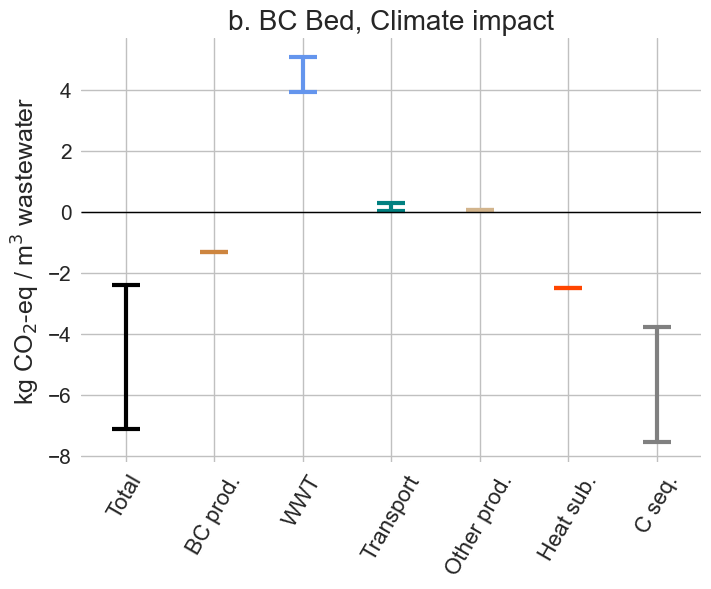

In [304]:
xlabelsBedSensitive = ('Total', 'BC prod.', 'WWT','Transport','Other prod.', 'Heat sub.', 'C seq.')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_C_Tot_med, x=1, yerr = BBS_C_Tot_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_C_BCProd_med, x=2, yerr = BBS_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_C_Wwt_med, x=3, yerr = BBS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_C_Tr_med, x=4, yerr = BBS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_C_Prod_med, x=5, yerr = BBS_C_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_C_Heat_med, x=6, yerr = BBS_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BBS_C_Cseq_med, x=7, yerr = BBS_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=7.5, linewidth=1, color='black')
ax.set_xlim(0.5,7.5)
ax.set_title('b. BC Bed, Climate impact', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(climate_label, fontsize=18)

In [262]:
#fig.savefig('Scenario-BCBed-Sens-Climate', dpi=600, bbox_inches='tight')

##### with sand - PROBLEM

(0.5, 12.5)

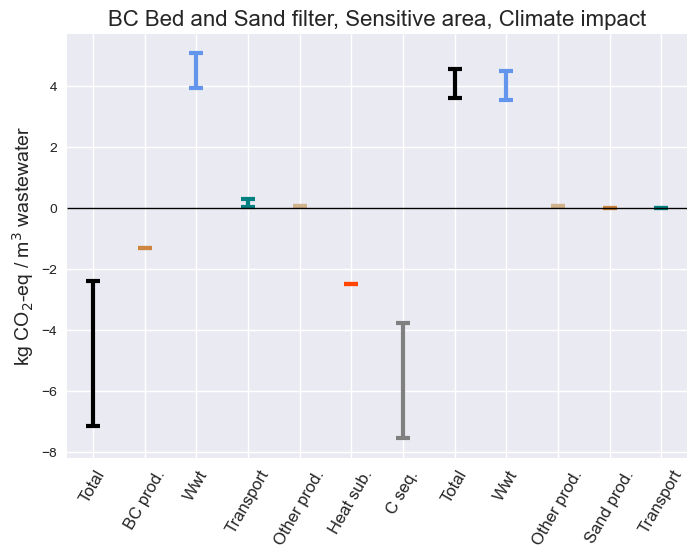

In [382]:
xlabels = ('Total', 'BC prod.', 'Wwt','Transport','Other prod.', 'Heat sub.', 'C seq.', 
           'Total', 'Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_C_Tot_med, x=1, yerr = BBS_C_Tot_e, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_C_BCProd_med, x=2, yerr = BBS_C_BCProd_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_C_Wwt_med, x=3, yerr = BBS_C_Wwt_e, capsize=5, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_C_Tr_med, x=4, yerr = BBS_C_Tr_e, capsize=5, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_C_Prod_med, x=5, yerr = BBS_C_Prod_e, capsize=5, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_C_Heat_med, x=6, yerr = BBS_C_Heat_e, capsize=5, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BBS_C_Cseq_med, x=7, yerr = BBS_C_Cseq_e, capsize=5, elinewidth=3, markeredgewidth=3, color='grey')

ax.errorbar(y=SS_medC, x=8, yerr = SS_eC, capsize=5, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_C_Wwt_med, x=9, yerr = SS_C_Wwt_e, capsize=5, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_C_Prod_med, x=10, yerr = SS_C_Prod_e, capsize=5, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_C_SandProd_med, x=11, yerr = SS_C_SandProd_e, capsize=5, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_C_Tr_med, x=12, yerr = SS_C_Tr_e, capsize=5, elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=12.5, linewidth=1, color='black')
ax.set_title('BC Bed and Sand filter, Sensitive area, Climate impact',fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12))
ax.set_xticklabels(xlabels, fontsize=12, rotation=60)
ax.set_ylabel(climate_label,fontsize=14)
ax.set_xlim(0.5,12.5)

In [379]:
#fig.savefig('Scenario-BCBed-Sens-Climate-wSand', dpi=600, bbox_inches='tight')

##### eutrophication - PROBLEM

In [383]:
BBS_E_Tot_min, BBS_E_Tot_max, BBS_E_Tot_med, BBS_E_Tot_e = calcMinMaxMedianError(BBS_sc, 'E_sum')
BBS_E_Prod_min, BBS_E_Prod_max, BBS_E_Prod_med, BBS_E_Prod_e = calcMinMaxMedianError(BBS_sc, 'BBS_E_Prod')
BBS_E_BCProd_min, BBS_E_BCProd_max, BBS_E_BCProd_med, BBS_E_BCProd_e = calcMinMaxMedianError(BBS_sc, 'BBS_E_BCProd')
BBS_E_Heat_min, BBS_E_Heat_max, BBS_E_Heat_med, BBS_E_Heat_e = calcMinMaxMedianError(BBS_sc, 'BBS_E_Heat')
BBS_E_Tr_min, BBS_E_Tr_max, BBS_E_Tr_med, BBS_E_Tr_e = calcMinMaxMedianError(BBS_sc, 'BBS_E_Tr')
BBS_E_Wwt_min, BBS_E_Wwt_max, BBS_E_Wwt_med, BBS_E_Wwt_e = calcMinMaxMedianError(BBS_sc, 'BBS_E_Wwt')

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

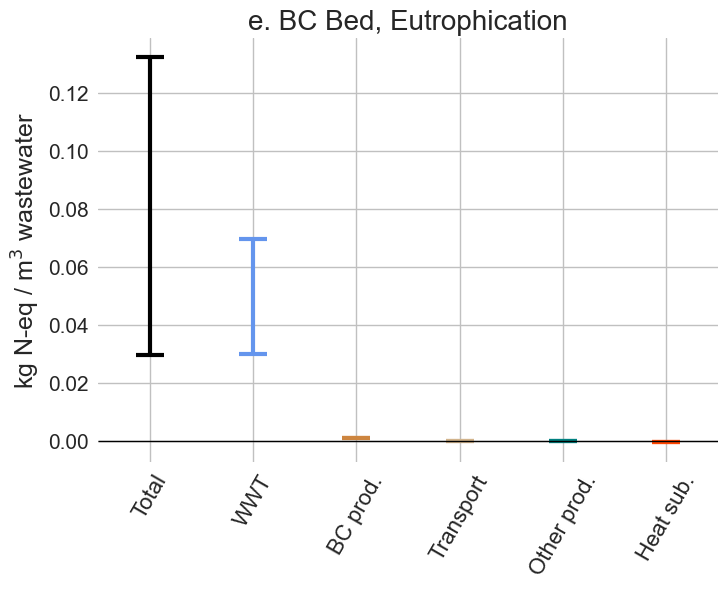

In [386]:
xlabelsBedSensitive = ('Total','WWT', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_medE, x=1, yerr = BBS_eE, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_E_Wwt_med, x=2, yerr = BBS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_E_BCProd_med, x=3, yerr = BBS_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_E_Prod_med, x=4, yerr = BBS_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_E_Tr_med, x=5, yerr = BBS_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_E_Heat_med, x=6, yerr = BBS_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_xlim(0.5,6.5)
ax.set_title('e. BC Bed, Eutrophication', fontsize=20)
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(eutroph_label, fontsize=18)

In [264]:
#fig.savefig('Scenario-BCBed-Sens-Eutroph', dpi=600, bbox_inches='tight')

##### acid - PROBLEM

In [387]:
BBS_A_Tot_min, BBS_A_Tot_max, BBS_A_Tot_med, BBS_A_Tot_e = calcMinMaxMedianError(BBS_sc, 'A_sum')
BBS_A_Prod_min, BBS_A_Prod_max, BBS_A_Prod_med, BBS_A_Prod_e = calcMinMaxMedianError(BBS_sc, 'BBS_A_Prod')
BBS_A_BCProd_min, BBS_A_BCProd_max, BBS_A_BCProd_med, BBS_A_BCProd_e = calcMinMaxMedianError(BBS_sc, 'BBS_A_BCProd')
BBS_A_Heat_min, BBS_A_Heat_max, BBS_A_Heat_med, BBS_A_Heat_e = calcMinMaxMedianError(BBS_sc, 'BBS_A_Heat')
BBS_A_Tr_min, BBS_A_Tr_max, BBS_A_Tr_med, BBS_A_Tr_e = calcMinMaxMedianError(BBS_sc, 'BBS_A_Tr')
BBS_A_Wwt_min, BBS_A_Wwt_max, BBS_A_Wwt_med, BBS_A_Wwt_e = calcMinMaxMedianError(BBS_sc, 'BBS_A_Wwt')

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

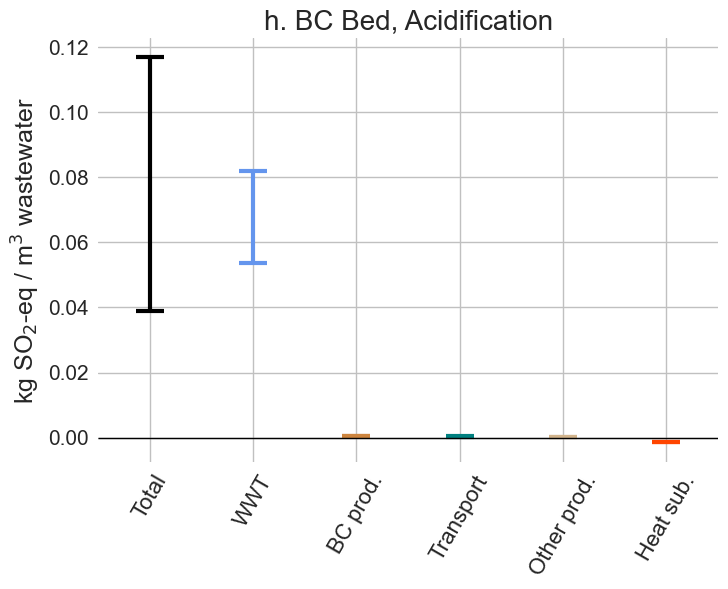

In [389]:
xlabelsBedSensitive = ('Total','WWT', 'BC prod.', 'Transport','Other prod.', 'Heat sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BBS_medA, x=1, yerr = BBS_eA, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BBS_A_Wwt_med, x=2, yerr = BBS_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BBS_A_BCProd_med, x=3, yerr = BBS_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BBS_A_Tr_med, x=4, yerr = BBS_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BBS_A_Prod_med, x=5, yerr = BBS_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=BBS_A_Heat_med, x=6, yerr = BBS_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=6.5, linewidth=1, color='black')
ax.set_xlim(0.5,6.5)
ax.set_title('h. BC Bed, Acidification', fontsize=20)
ax.set_xticks((1,2,3,4,5,6))
ax.set_xticklabels(xlabelsBedSensitive, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(acid_label, fontsize=18)

In [266]:
#fig.savefig('Scenario-BCBed-Sens-Acid', dpi=600, bbox_inches='tight')

#### BC Mod

In [ ]:
BMS_sc = pd.DataFrame.from_dict(params)

In [ ]:
BMS_sc['Climate'] = Y4['Climate'].values
BMS_sc['Eutroph.'] = Y4['Eutroph.'].values
BMS_sc['Acid.'] = Y4['Acid.'].values

In [ ]:
BMS_sc['BMS_C_BCProd'] = BMS_C_BCProd_Y[c_string].values
BMS_sc['BMS_C_Heat'] = BMS_C_Heat_Y[c_string].values
BMS_sc['BMS_C_Tr'] = BMS_C_Tr_Y[c_string].values
BMS_sc['BMS_C_BCEOL'] = BMS_C_BCEOL_Y[c_string].values
BMS_sc['BMS_C_LS'] = BMS_C_LS_Y[c_string].values
BMS_sc['BMS_C_Cseq'] = BMS_C_Cseq_Y[c_string].values
BMS_sc['BMS_C_Elec'] = BMS_C_Elec_Y[c_string].values
BMS_sc['BMS_C_Wwt'] = BMS_C_Wwt_Y[c_string].values

BMS_sc['BMS_E_BCProd'] = BMS_E_BCProd_Y[e_string].values
BMS_sc['BMS_E_Heat'] = BMS_E_Heat_Y[e_string].values
BMS_sc['BMS_E_Tr'] = BMS_E_Tr_Y[e_string].values
BMS_sc['BMS_E_BCEOL'] = BMS_E_BCEOL_Y[e_string].values
BMS_sc['BMS_E_LS'] = BMS_E_LS_Y[e_string].values
BMS_sc['BMS_E_Elec'] = BMS_E_Elec_Y[e_string].values
BMS_sc['BMS_E_Wwt'] = BMS_E_Wwt_Y[e_string].values

BMS_sc['BMS_A_BCProd'] = BMS_A_BCProd_Y[a_string].values
BMS_sc['BMS_A_Heat'] = BMS_A_Heat_Y[a_string].values
BMS_sc['BMS_A_Tr'] = BMS_A_Tr_Y[a_string].values
BMS_sc['BMS_A_BCEOL'] = BMS_A_BCEOL_Y[a_string].values
BMS_sc['BMS_A_LS'] = BMS_A_LS_Y[a_string].values
BMS_sc['BMS_A_Elec'] = BMS_A_Elec_Y[a_string].values
BMS_sc['BMS_A_Wwt'] = BMS_A_Wwt_Y[a_string].values

In [ ]:
# bc3, fossil energy, EOL LS
BMS_sc = BMS_sc.loc[(BMS_sc['bc_Seqswitch_param'] == 'bc3Seq') &
                    (BMS_sc['bc_HLswitch_param'] == 'bc3HL') &
                    (BMS_sc['bc_switch_param'] == 'bc3') &
                    (BMS_sc['heat_switch_param'] == 'heatNaturalGas') &
                    (BMS_sc['elec_switch_param'] == 'elecCoal') & 
                    (BMS_sc['EOL3and4_switch_param'] == 'LS2')]

In [243]:
BMS_sc['C_sum'] = BMS_sc['BMS_C_BCProd'] + BMS_sc['BMS_C_Heat'] +BMS_sc['BMS_C_Tr'] + BMS_sc['BMS_C_BCEOL'] + BMS_sc['BMS_C_LS'] + BMS_sc['BMS_C_Cseq'] +BMS_sc['BMS_C_Elec'] + BMS_sc['BMS_C_Wwt']
BMS_sc['E_sum'] = BMS_sc['BMS_E_BCProd'] + BMS_sc['BMS_E_Heat'] +BMS_sc['BMS_E_Tr'] + BMS_sc['BMS_E_BCEOL'] + BMS_sc['BMS_E_LS']+BMS_sc['BMS_E_Elec'] + BMS_sc['BMS_E_Wwt']
BMS_sc['A_sum'] = BMS_sc['BMS_A_BCProd'] + BMS_sc['BMS_A_Heat'] +BMS_sc['BMS_A_Tr'] + BMS_sc['BMS_A_BCEOL'] + BMS_sc['BMS_A_LS']+BMS_sc['BMS_A_Elec'] + BMS_sc['BMS_A_Wwt']

C:\Users\lizn0001\AppData\Local\Temp\ipykernel_20268\1362443036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BCMod_scenario['Climate_sum'] = BCMod_scenario['BCModClimateBCProd'] + BCMod_scenario['BCModClimateHeatSub'] +BCMod_scenario['BCModClimateTransport'] + BCMod_scenario['BCModClimateBCEOL'] + BCMod_scenario['BCModClimateLSSub'] + BCMod_scenario['BCModClimateCseq'] +BCMod_scenario['BCModClimateElecSub'] + BCMod_scenario['BCModClimateWwt']


##### climate

In [ ]:
BMS_C_Tot_min, BMS_C_Tot_max, BMS_C_Tot_med, BMS_C_Tot_e = calcMinMaxMedianError(BMS_sc, 'C_sum')
BMS_C_BCProd_min, BMS_C_BCProd_max, BMS_C_BCProd_med, BMS_C_BCProd_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_BCProd')
BMS_C_BCEOL_min, BMS_C_BCEOL_max, BMS_C_BCEOL_med, BMS_C_BCEOL_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_BCEOL')
BMS_C_Heat_min, BMS_C_Heat_max, BMS_C_Heat_med, BMS_C_Heat_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_Heat')
BMS_C_Elec_min, BMS_C_Elec_max, BMS_C_Elec_med, BMS_C_Elec_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_Elec')
BMS_C_Tr_min, BMS_C_Tr_max, BMS_C_Tr_med, BMS_C_Tr_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_Tr')
BMS_C_LS_min, BMS_C_LS_max, BMS_C_LS_med, BMS_C_LS_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_LS')
BMS_C_Cseq_min, BMS_C_Cseq_max, BMS_C_Cseq_med, BMS_C_Cseq_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_Cseq')
BMS_C_Wwt_min, BMS_C_Wwt_max, BMS_C_Wwt_med, BMS_C_Wwt_e = calcMinMaxMedianError(BMS_sc, 'BMS_C_Wwt')

Text(0, 0.5, 'kg CO$_{2}$-eq / m$^{3}$ wastewater')

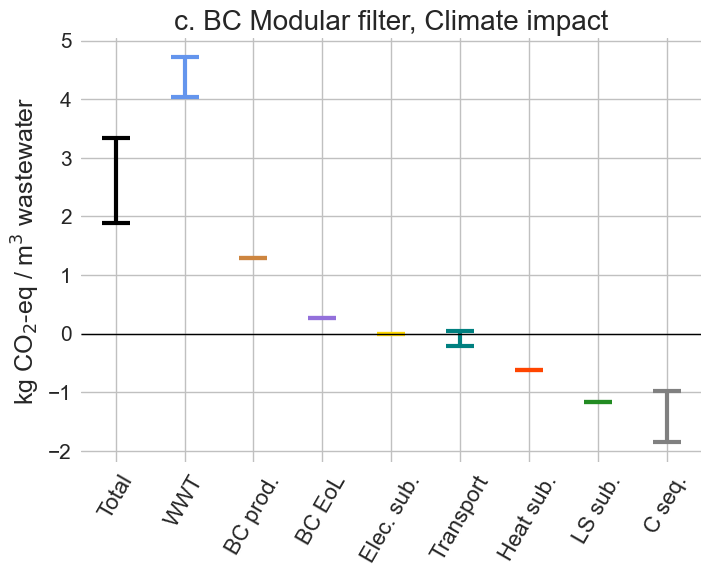

In [267]:
xlabels = ('Total','WWT','BC prod.','BC EoL','Elec. sub.','Transport','Heat sub.','LS sub.', 'C seq.')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_medC, x=1, yerr = BMS_eC, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_C_Wwt_med, x=2, yerr = BMS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_C_BCProd_med, x=3, yerr = BMS_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_C_BCEOL_med, x=4, yerr = BMS_C_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_C_Elec_med, x=5, yerr = BMS_C_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.errorbar(y=BMS_C_Tr_med, x=6, yerr = BMS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_C_Heat_med, x=7, yerr = BMS_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_C_LS_med, x=8, yerr = BMS_C_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_C_Cseq_med, x=9, yerr = BMS_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=9.5, linewidth=1, color='black')
ax.set_xlim(0.5,9.5)
ax.set_title('c. BC Modular filter, Climate impact', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8,9))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(climate_label,fontsize=18)

In [268]:
#fig.savefig('Scenario-BCMod-Climate', dpi=600, bbox_inches='tight')

##### with sand

(-2.0, 5.0)

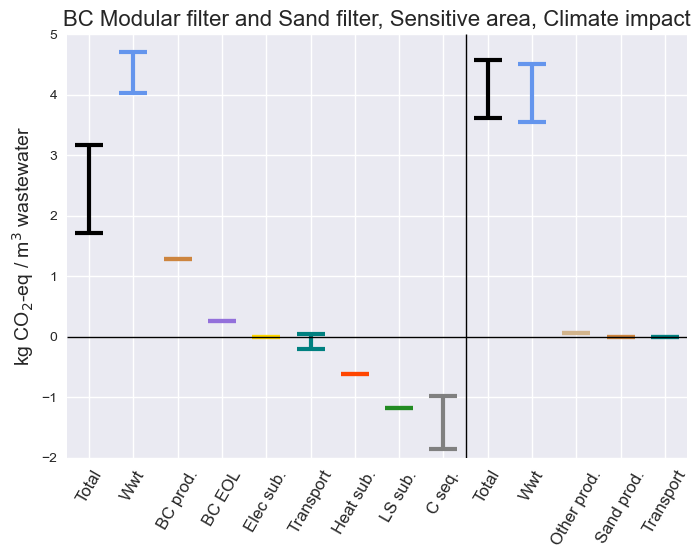

In [401]:
xlabels = ('Total', 'Wwt', 'BC prod.', 'BC EOL', 'Elec sub.', 'Transport','Heat sub.','LS sub.', 'C seq.',
           'Total', 'Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_medC, x=1, yerr = BMS_eC, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_C_Wwt_med, x=2, yerr = BMS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_C_BCProd_med, x=3, yerr = BMS_C_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_C_BCEOL_med, x=4, yerr = BMS_C_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_C_Elec_med, x=5, yerr = BMS_C_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.errorbar(y=BMS_C_Tr_med, x=6, yerr = BMS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_C_Heat_med, x=7, yerr = BMS_C_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_C_LS_med, x=8, yerr = BMS_C_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_C_Cseq_med, x=9, yerr = BMS_C_Cseq_e, capsize=10, elinewidth=3, markeredgewidth=3, color='grey')

ax.errorbar(y=SS_medC, x=10, yerr = SS_eC, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_C_Wwt_med, x=11, yerr = SS_C_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_C_Prod_med, x=12, yerr = SS_C_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_C_SandProd_med, x=13, yerr = SS_C_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_C_Tr_med, x=14, yerr = SS_C_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=14.5, linewidth=1, color='black')
ax.vlines(x=9.5, ymin=-2, ymax=5, linewidth=1, color='black')
ax.set_title('BC Modular filter and Sand filter, Sensitive area, Climate impact', fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13,14))
ax.set_xticklabels(xlabels, fontsize=12,rotation=60)
ax.set_ylabel(climate_label,fontsize=14)
ax.set_xlim(0.5,14.5)
ax.set_ylim(-2,5)

In [402]:
#fig.savefig('Scenario-BCMod-Climate-sand', dpi=600, bbox_inches='tight')

##### eutroph

In [ ]:
BMS_E_Tot_min, BMS_E_Tot_max, BMS_E_Tot_med, BMS_E_Tot_e = calcMinMaxMedianError(BMS_sc, 'E_sum')
BMS_E_BCProd_min, BMS_E_BCProd_max, BMS_E_BCProd_med, BMS_E_BCProd_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_BCProd')
BMS_E_BCEOL_min, BMS_E_BCEOL_max, BMS_E_BCEOL_med, BMS_E_BCEOL_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_BCEOL')
BMS_E_Heat_min, BMS_E_Heat_max, BMS_E_Heat_med, BMS_E_Heat_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_Heat')
BMS_E_Elec_min, BMS_E_Elec_max, BMS_E_Elec_med, BMS_E_Elec_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_Elec')
BMS_E_Tr_min, BMS_E_Tr_max, BMS_E_Tr_med, BMS_E_Tr_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_Tr')
BMS_E_LS_min, BMS_E_LS_max, BMS_E_LS_med, BMS_E_LS_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_LS')
BMS_E_Cseq_min, BMS_E_Cseq_max, BMS_E_Cseq_med, BMS_E_Cseq_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_Cseq')
BMS_E_Wwt_min, BMS_E_Wwt_max, BMS_E_Wwt_med, BMS_E_Wwt_e = calcMinMaxMedianError(BMS_sc, 'BMS_E_Wwt')

Text(0, 0.5, 'kg N-eq / m$^{3}$ wastewater')

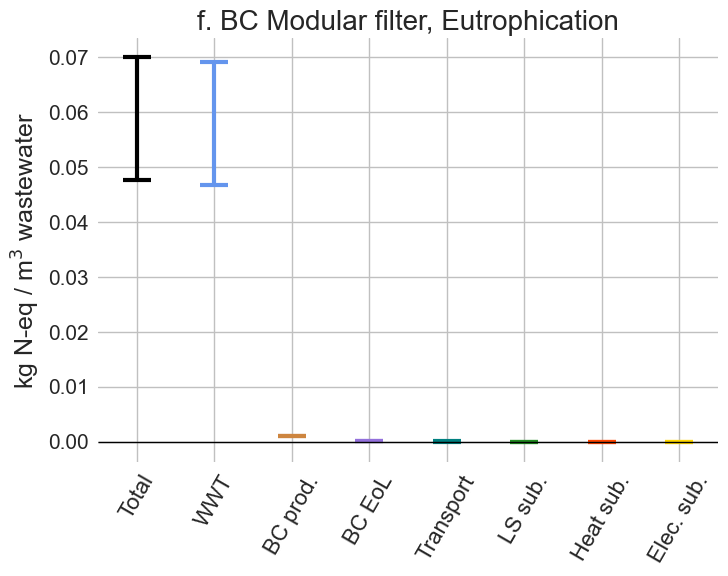

In [269]:
xlabels = ('Total','WWT','BC prod.','BC EoL','Transport','LS sub.', 'Heat sub.', 'Elec. sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_medE, x=1, yerr = BMS_eE, capsize=10,  elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_E_Wwt_med, x=2, yerr = BMS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_E_BCProd_med, x=3, yerr = BMS_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_E_BCEOL_med, x=4, yerr = BMS_E_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_E_Tr_med, x=5, yerr = BMS_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_E_LS_med, x=6, yerr = BMS_E_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_E_Heat_med, x=7, yerr = BMS_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_E_Elec_med, x=8, yerr = BMS_E_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_xlim(0.5,8.5)
ax.set_title('f. BC Modular filter, Eutrophication', fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(eutroph_label,fontsize=18)

In [270]:
#fig.savefig('Scenario-BCMod-Eutroph', dpi=600, bbox_inches='tight')

##### with sand

(-0.01, 0.087)

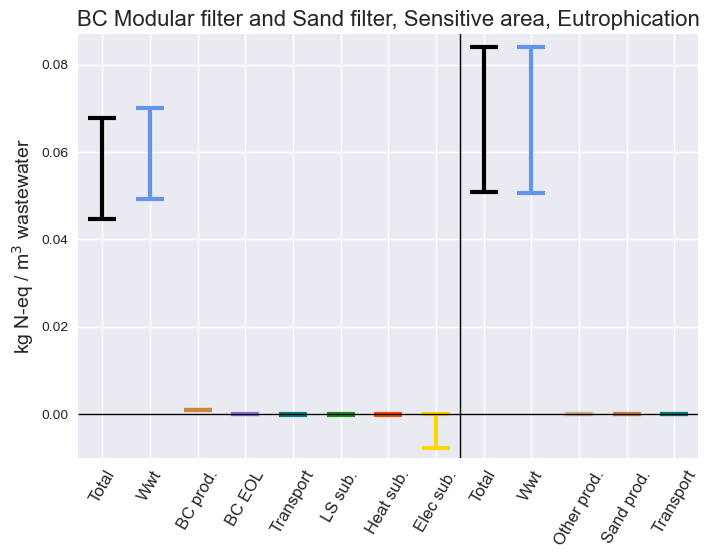

In [408]:
xlabels = ('Total', 'Wwt', 'BC prod.', 'BC EOL', 'Transport','LS sub.', 'Heat sub.', 'Elec sub.',
           'Total', 'Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_medE, x=1, yerr = BMS_eE, capsize=10,  elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_E_Wwt_med, x=2, yerr = BMS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_E_BCProd_med, x=3, yerr = BMS_E_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_E_BCEOL_med, x=4, yerr = BMS_E_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_E_Tr_med, x=5, yerr = BMS_E_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_E_LS_med, x=6, yerr = BMS_E_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_E_Heat_med, x=7, yerr = BMS_E_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_E_Elec_med, x=8, yerr = BMS_E_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.errorbar(y=SS_medE, x=9, yerr = SS_E_E, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_E_Wwt_med, x=10, yerr = SS_E_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_E_Prod_med, x=11, yerr = SS_E_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_E_SandProd_med, x=12, yerr = SS_E_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_E_Transport_med, x=13, yerr = SS_E_Transport_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=14.5, linewidth=1, color='black')
ax.vlines(x=8.5, ymin=-0.02, ymax=0.09, linewidth=1, color='black')
ax.set_title('BC Modular filter and Sand filter, Sensitive area, Eutrophication', fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(xlabels, fontsize=12,rotation=60)
ax.set_ylabel(eutroph_label,fontsize=14)
ax.set_xlim(0.5,13.5)
ax.set_ylim(-0.01,0.087)

In [409]:
#fig.savefig('Scenario-BCMod-Eutroph-sand', dpi=600, bbox_inches='tight')

##### acid

In [ ]:
BMS_A_Tot_min, BMS_A_Tot_max, BMS_A_Tot_med, BMS_A_Tot_e = calcMinMaxMedianError(BMS_sc, 'A_sum')
BMS_A_BCProd_min, BMS_A_BCProd_max, BMS_A_BCProd_med, BMS_A_BCProd_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_BCProd')
BMS_A_BCEOL_min, BMS_A_BCEOL_max, BMS_A_BCEOL_med, BMS_A_BCEOL_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_BCEOL')
BMS_A_Heat_min, BMS_A_Heat_max, BMS_A_Heat_med, BMS_A_Heat_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_Heat')
BMS_A_Elec_min, BMS_A_Elec_max, BMS_A_Elec_med, BMS_A_Elec_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_Elec')
BMS_A_Tr_min, BMS_A_Tr_max, BMS_A_Tr_med, BMS_A_Tr_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_Tr')
BMS_A_LS_min, BMS_A_LS_max, BMS_A_LS_med, BMS_A_LS_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_LS')
BMS_A_Cseq_min, BMS_A_Cseq_max, BMS_A_Cseq_med, BMS_A_Cseq_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_Cseq')
BMS_A_Wwt_min, BMS_A_Wwt_max, BMS_A_Wwt_med, BMS_A_Wwt_e = calcMinMaxMedianError(BMS_sc, 'BMS_A_Wwt')

Text(0, 0.5, 'kg SO$_{2}$-eq / m$^{3}$ wastewater')

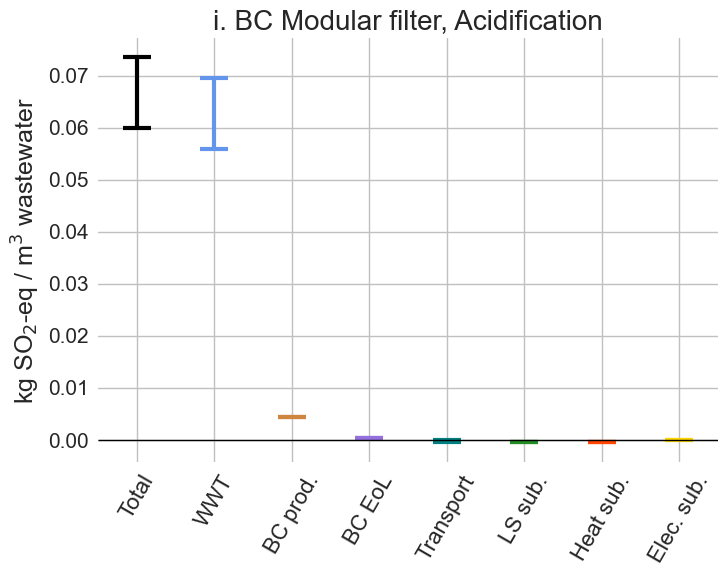

In [273]:
xlabels = ('Total','WWT', 'BC prod.','BC EoL', 'Transport','LS sub.', 'Heat sub.', 'Elec. sub.')

fig, ax = plt.subplots()

ax.errorbar(y=BMS_medA, x=1, yerr = BMS_eA, capsize=10,  elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BMS_A_Wwt_med, x=2, yerr = BMS_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BMS_A_BCProd_med, x=3, yerr = BMS_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BMS_A_BCEOL_med, x=4, yerr = BMS_A_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BMS_A_Tr_med, x=5, yerr = BMS_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BMS_A_LS_med, x=6, yerr = BMS_A_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BMS_A_Heat_med, x=7, yerr = BMS_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BMS_A_Elec_med, x=8, yerr = BMS_A_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.set_facecolor('white')
ax.grid(color='silver')

ax.hlines(y=0, xmin=0.5, xmax=8.5, linewidth=1, color='black')
ax.set_xlim(0.5,8.5)
ax.set_title('i. BC Modular filter, Acidification',fontsize=20)
ax.set_xticks((1,2,3,4,5,6,7,8))
ax.set_xticklabels(xlabels, fontsize=16,rotation=60)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(acid_label,fontsize=18)

In [274]:
#fig.savefig('Scenario-BCMod-Acid', dpi=600, bbox_inches='tight')

##### with sand

(-0.01, 0.07)

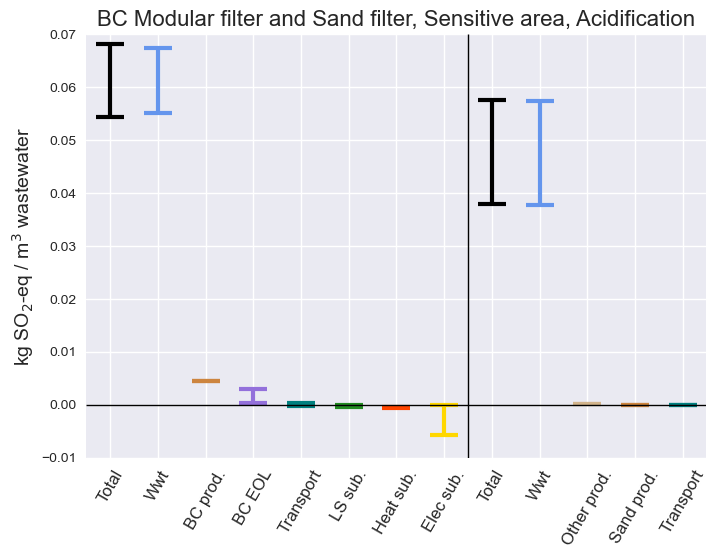

In [412]:
xlabels = ('Total', 'Wwt', 'BC prod.', 'BC EOL', 'Transport', 'LS sub.', 'Heat sub.', 'Elec sub.',
           'Total', 'Wwt', 'Other prod.', 'Sand prod.', 'Transport')

fig, ax = plt.subplots()

ax.errorbar(y=BM_A_Tot_med, x=1, yerr = BM_A_Tot_e, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=BM_A_Wwt_med, x=2, yerr = BM_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=BM_A_BCProd_med, x=3, yerr = BM_A_BCProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=BM_A_BCEOL_med, x=4, yerr = BM_A_BCEOL_e, capsize=10, elinewidth=3, markeredgewidth=3, color='mediumpurple')

ax.errorbar(y=BM_A_Tr_med, x=5, yerr = BM_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.errorbar(y=BM_A_LS_med, x=6, yerr = BM_A_LS_e, capsize=10, elinewidth=3, markeredgewidth=3, color='forestgreen')

ax.errorbar(y=BM_A_Heat_med, x=7, yerr = BM_A_Heat_e, capsize=10, elinewidth=3, markeredgewidth=3, color='orangered')

ax.errorbar(y=BM_A_Elec_med, x=8, yerr = BM_A_Elec_e, capsize=10, elinewidth=3, markeredgewidth=3, color='gold')

ax.errorbar(y=SS_medA, x=9, yerr = SS_eA, capsize=10, elinewidth=3, markeredgewidth=3, color='black')

ax.errorbar(y=SS_A_Wwt_med, x=10, yerr = SS_A_Wwt_e, capsize=10, elinewidth=3, markeredgewidth=3, color='cornflowerblue')

ax.errorbar(y=SS_A_Prod_med, x=11, yerr = SS_A_Prod_e, capsize=10, elinewidth=3, markeredgewidth=3, color='tan')

ax.errorbar(y=SS_A_SandProd_med, x=12, yerr = SS_A_SandProd_e, capsize=10, elinewidth=3, markeredgewidth=3, color='peru')

ax.errorbar(y=SS_A_Tr_med, x=13, yerr = SS_A_Tr_e, capsize=10, elinewidth=3, markeredgewidth=3, color='teal')

ax.hlines(y=0, xmin=0.5, xmax=13.5, linewidth=1, color='black')
ax.vlines(x=8.5, ymin=-0.01, ymax=0.07, linewidth=1, color='black')
ax.set_title('BC Modular filter and Sand filter, Sensitive area, Acidification',fontsize=16)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12,13))
ax.set_xticklabels(xlabels, fontsize=12,rotation=60)
ax.set_ylabel(acid_label,fontsize=14)
ax.set_xlim(0.5,13.5)
ax.set_ylim(-0.01,0.07)

In [413]:
#fig.savefig('Scenario-BCMod-Acid-sand', dpi=600, bbox_inches='tight')

## Sobol indices

In this section, the Sobol indices are calculated and saved to an Excel sheet

In [173]:
from lca_algebraic.stats import incer_stochastic_matrix_return

In [174]:
sob1, problem1 = incer_stochastic_matrix_return(BN, all_methods, n=1000)
sob2, problem2 = incer_stochastic_matrix_return(BBS, all_methods, n=1000)
sob3, problem3 = incer_stochastic_matrix_return(BMS, all_methods, n=1000)
sob4, problem4 = incer_stochastic_matrix_return(SN, all_methods, n=1000)
sob5, problem5 = incer_stochastic_matrix_return(SN, all_methods, n=1000)

Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('TRACI v2.1', 'eutrophication', 'eutrophication potential')
Processing sobol for ('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')


In [176]:
sob_df1 = pd.DataFrame()
sob_df2 = pd.DataFrame()
sob_df3 = pd.DataFrame()
sob_df4 = pd.DataFrame()
sob_df5 = pd.DataFrame()

In [177]:
sob_df1_round = pd.DataFrame()
sob_df2_round = pd.DataFrame()
sob_df3_round = pd.DataFrame()
sob_df4_round = pd.DataFrame()
sob_df5_round = pd.DataFrame()

In [178]:
sob_list = [sob1, sob2, sob3, sob4, sob5]
problem_list = [problem1, problem2, problem3, problem4, problem5]
sob_df_list = [sob_df1, sob_df2, sob_df3, sob_df4, sob_df5]
sob_df_list_round = [sob_df1_round, sob_df2_round, sob_df3_round, sob_df4_round, sob_df5_round]

In [179]:
for sob, names, df, df_round in zip(sob_list, problem_list, sob_df_list, sob_df_list_round): # for every scenario
    for s, name in zip(sob.s1, names['names']): # and every sobol & name
        df[name] = s
        df_round[name] = [str(round(s[0], 2))]

In [180]:
sob_df2

,BCStability,BOD5RemovalSludge,BOD5removalBCBedSensitive,BODremovalPAC,CH4air,CO2air,NremovalBCBedSensitive,NremovalSludge,PorgInPoutBC,PremovalBCBed,PremovalPAC,TransportDistanceFilter,TransportDistanceST,bc_Seqswitch_param,elec_switch_param,heat_switch_param
0,0.09817,0.000000,0.000000,0.000000,0.000487,0.0,0.001058,-0.000017,0.000000e+00,0.000000,0.000000,0.000641,-0.000004,0.330653,0.149956,0.060622
1,0.00000,-0.000105,0.000437,0.000004,0.000000,0.0,0.105296,0.003388,2.067884e-08,0.036345,0.021577,-0.000019,-0.000001,0.341317,0.229217,-0.000408
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.255513,0.023334,0.000000e+00,0.000000,0.000000,-0.000145,-0.000004,0.215556,0.217231,0.019490


In [181]:
sob_df2_round

,BCStability,BOD5RemovalSludge,BOD5removalBCBedSensitive,BODremovalPAC,CH4air,CO2air,NremovalBCBedSensitive,NremovalSludge,PorgInPoutBC,PremovalBCBed,PremovalPAC,TransportDistanceFilter,TransportDistanceST,bc_Seqswitch_param,elec_switch_param,heat_switch_param
0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.33,0.15,0.06


In [207]:
with pd.ExcelWriter('Sobol.xlsx') as writer:  
    sob_df1.to_excel(writer, sheet_name='Sheet_name_1')
    sob_df2.to_excel(writer, sheet_name='Sheet_name_2')
    sob_df3.to_excel(writer, sheet_name='Sheet_name_3')
    sob_df4.to_excel(writer, sheet_name='Sheet_name_4')
    sob_df5.to_excel(writer, sheet_name='Sheet_name_5')

## compare to recommendations (bonus, not in article)

define export_df in section 2 before running this

from the dataframes - calculate the total BOD, N and P removal, for all filters

- Normal: 90% reduction of BOD and a 70% reduction of P
- Sensitive: 90% reduction of P and 50% reduction of N 

Step 1: find the params we need

BC Bed Normal: BOD5in, BOD5RemovalSludge, BOD5removalBCBedNormal; Ntotin, NremovalSludge, NremovalBCBedNormal; Ptotin, PremovalSludge, PremovalBCBed, PremovalBCimpreg - BC impreg always 0.9

BC Bed Sensitive: BOD5in, BOD5RemovalSludge, BODremovalPAC, BOD5removalBCBedSensitive; Ntotin, NremovalSludge, NremovalBCBedSensitive; Ptotin, PremovalPAC, PremovalBCBed

BC Mod: BOD5in, BOD5RemovalSludge, BODremovalPAC, BOD5removalBCMod; Ntotin, NremovalSludge, NremovalBCMod; Ptotin, PremovalPAC, PremovalBCmod - BOD5 removal BC Mod also a constant (0.9)

Sand Normal: BOD5in, BOD5RemovalSludge, BOD5removalSand; Ntotin, NremovalSludge, NremovalSand; Ptotin, PremovalSludge, PremovalSand

Sand Sensitive: BOD5in, BOD5RemovalSludge, BODremovalPAC, BOD5removalSand; Ntotin, NremovalSludge, NremovalSand; Ptotin, PremovalPAC, PremovalSand

In [338]:
# save results in arrays
BCBedNormalBOD = [100-100*(1-x)*(1-y) for x, y in zip(export_df['BOD5RemovalSludge'], export_df['BOD5removalBCBedNormal'])]
BCBedNormalN = [100-100*(1-x)*(1-y) for x, y in zip(export_df['NremovalSludge'], export_df['NremovalBCBedNormal'])]
BCBedNormalP = [100-100*(1-x)*(1-y)*(0.1) for x, y in zip(export_df['PremovalSludge'], export_df['PremovalBCBed'])]

In [339]:
min(BCBedNormalBOD)

83.6342357521858

In [340]:
max(BCBedNormalBOD)

95.99075610409491

In [341]:
min(BCBedNormalN)

5.159671399928627

In [342]:
max(BCBedNormalN)

33.58569350373

In [343]:
min(BCBedNormalP)

93.54602160096168

In [344]:
max(BCBedNormalP)

99.69543667912482

BC Bed Sensitive

In [353]:
BCBedSensitiveBOD = [100-100*(1-x+y)*(1-z) for x, y,z in zip(export_df['BOD5RemovalSludge'],export_df['BODremovalPAC'], 
                                                             export_df['BOD5removalBCBedSensitive'])]
BCBedSensitiveN = [100-100*(1-x)*(1-y) for x, y in zip(export_df['NremovalSludge'], export_df['NremovalBCBedSensitive'])]
BCBedSensitiveP = [100-100*(1-x)*(1-y)*(0.1) for x, y in zip(export_df['PremovalPAC'], export_df['PremovalBCBed'])]

In [354]:
min(BCBedSensitiveBOD)

89.98595084893145

In [355]:
max(BCBedSensitiveBOD)

97.73858091008104

In [356]:
min(BCBedSensitiveN)

61.12576912716031

In [357]:
max(BCBedSensitiveN)

85.47042812779546

In [358]:
min(BCBedSensitiveP)

98.04121560299396

In [359]:
max(BCBedSensitiveP)

99.98639698255062

BC Mod

In [361]:
BCModBOD = [100-100*(1-x+y)*(0.1) for x, y in zip(export_df['BOD5RemovalSludge'],export_df['BODremovalPAC'])]
BCModN = [100-100*(1-x)*(1-y) for x, y in zip(export_df['NremovalSludge'], export_df['NremovalBCMod'])]
BCModP = [100-100*(1-x)*(1-y)*(0.1) for x, y in zip(export_df['PremovalPAC'], export_df['PremovalBCmod'])]

In [362]:
min(BCModBOD)

89.8735775756836

In [363]:
max(BCModBOD)

94.48506317138671

In [364]:
min(BCModN)

62.08944072108715

In [365]:
max(BCModN)

74.47223671060055

In [366]:
min(BCModP)

97.68335838334635

In [367]:
max(BCModP)

99.78940376287326

Seems reasonable!

## No need to run this again

In this section, I've gathered pieces of code that are used only once for setting up the model and determining the number of computations needed. Since the model is now finished, do not run them, they are just for reference / transparency and future use

### Import/export parameters

This only needs to be run once

In [7]:
loadParams()

0


In [5]:
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group
def ExportProjectParameters(f='ProjectParamExport.xlsx'):
    params = { i:p.dict for i,p in enumerate(ProjectParameter.select() )}
    pd.DataFrame.from_dict(params).to_excel('ProjectParamExport.xlsx')

def LoadProjectParameters(f='ProjectParamExport.xlsx'):
    df = pd.read_excel('ProjectParamExport.xlsx', index_col=0) # OBS OBS
    paramDict = df.to_dict(orient='dict')
    paramList = [v for k,v in paramDict.items()]
    bw2.parameters.new_project_parameters(paramList, overwrite=True)
    bw2.parameters.recalculate()

In [7]:
ExportProjectParameters()

In [8]:
project = 'wwt_new'
bw2.projects.set_current(project)

In [9]:
loadParams()

0


In [6]:
LoadProjectParameters(f='ProjectParametersUppsala')

ValueError: Global parameter BiocharYield does not have a numeric value: None

### Define switches (used for building the database, do not run it now that it is finished)

Elec

In [19]:
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["elecCoal", "elecWindpower"], # If provided as list, all possibilities have te same probability
    default="elecWindpower", 
    description="Switch on electricty")

In [20]:
elecWindpower = getActByCode('cutoff391', '1d9be64d54b61ac64ba8a6f7ca220371')
elecCoal = getActByCode('cutoff391', '7bea67942b5e008ee3dc5bafec8e1614')

In [21]:
elecSwitch = newSwitchAct('wwt_db', 
    "elecSwitch", # Name
    elec_switch_param, # Switch parameter
    {
        "elecWindpower" : elecWindpower,
        "elecCoal": elecCoal
    })
elecSwitch.addExchanges({elecSwitch:1})

Heat

In [22]:
heat_switch_param = newEnumParam(
    'heat_switch_param', 
    values=["heatNaturalGas", "heatWoodchips"], # If provided as list, all possibilities have te same probability
    default="heatWoodchips", 
    description="Switch on heat")

In [23]:
heatNaturalGas=getActByCode('cutoff391', '2446fb9b2d523f6d90a47b004bb6debf')
heatWoodchips = getActByCode('cutoff391', 'ce4ad62107e686a5dd09cca3985a4f37')

In [24]:
heatSwitch = newSwitchAct('wwt_db', 
    "heatSwitch", # Name
    heat_switch_param, # Switch parameter
    {
        "heatNaturalGas" : heatNaturalGas,
        "heatWoodchips": heatWoodchips
    })
heatSwitch.addExchanges({heatSwitch:1})

Sand - material or no

In [27]:
sand_switch_param = newEnumParam(
    'sand_switch_param', 
    values=["sand", "noSand"], # If provided as list, all possibilities have te same probability
    default="sand", 
    description="Switch on sand for filter")

In [66]:
sand=getActByCode('wwt_db', 'b23795c66a984d88aa77ed3a6f7a1499')
noSand = getActByCode('wwt_db', 'c10a45c5e30b42ba82303eeca29bf3b5')

In [67]:
sandSwitch = newSwitchAct('wwt_db', 
    "sandSwitch", # Name
    sand_switch_param, # Switch parameter
    {
        "sand" : sand,
        "noSand": noSand
    })
sandSwitch.addExchanges({sandSwitch:1})

Activity 'sandSwitch' was already in 'wwt_db'. Overwriting it


Biochar type - involves prod, amount in filter, and EoL

In [41]:
bc_switch_param = newEnumParam(
    'bc_switch_param', 
    values=["bc1", "bc2", "bc3", "bc4", "bc5", "bc6", "bc7"], # If provided as list, all possibilities have te same probability
    default="bc1", 
    description="Switch on type of biochar")

In [42]:
bc1=getActByCode('wwt_db', '6d631561b8634199949da8e659a0d0c8')
bc2 = getActByCode('wwt_db', '034ccc11d9f342ca9553dcfccc3daae6')
bc3 = getActByCode('wwt_db', 'e5876ed071b54182b4ae8e36598a87fc')
bc4=getActByCode('wwt_db', 'fd5def76a8544aac8397818e2ba482aa')
bc5 = getActByCode('wwt_db', '993fe1721f4844a983301dc6a0b1949b')
bc6 = getActByCode('wwt_db', 'd9775217ae99439e9f98e923b2de9a63')
bc7 = getActByCode('wwt_db', '58d3983a6b37472eb728fd23224782ac')

In [43]:
bcSwitch = newSwitchAct('wwt_db', 
    "bcSwitch", # Name
    bc_switch_param, # Switch parameter
    {
        "bc1":bc1,
        "bc2":bc2,
        "bc3":bc3,
        "bc4":bc4,
        "bc5":bc5,
        "bc6":bc6,
        "bc7":bc7
    })
bcSwitch.addExchanges({bcSwitch:1})

Bc prod for impreg bc - includes heat losses

In [7]:
bc_HLswitch_param = newEnumParam(
    'bc_HLswitch_param', 
    values=["bc1HL", "bc2HL", "bc3HL", "bc4HL", "bc5HL", "bc7HL"], # If provided as list, all possibilities have te same probability
    default="bc1HL", 
    description="Switch on type of biochar, with heat losses for impreg bc")

Param bc_HLswitch_param was already defined : overriding


In [8]:
bc1HL = getActByCode('wwt_db', '788013939f964a8fa4c15b96acae919e')
bc2HL = getActByCode('wwt_db', 'b5068415e5164a7fbb72a4802e549932')
bc3HL = getActByCode('wwt_db', '8b170663ebcc45e195034bc7f0c0a3da')
bc4HL = getActByCode('wwt_db', 'bbf2c0226d664b3db142fc5e9784100b')
bc5HL = getActByCode('wwt_db', '818a0b0ade734a2088b34e7640114ddb')
bc7HL = getActByCode('wwt_db', '96756a2ca4e545709e1561374faacbe2')

In [9]:
bcHLSwitch = newSwitchAct('wwt_db', 
    "bcHLSwitch", # Name
    bc_HLswitch_param, # Switch parameter
    {
        "bc1HL":bc1HL,
        "bc2HL":bc2HL,
        "bc3HL":bc3HL,
        "bc4HL":bc4HL,
        "bc5HL":bc5HL,
        "bc7HL":bc7HL
    })
bcHLSwitch.addExchanges({bcHLSwitch:1})

Activity 'bcHLSwitch' was already in 'wwt_db'. Overwriting it


BC Switch for biochar left in biochar bed filter

In [65]:
bc_Seqswitch_param = newEnumParam(
    'bc_Seqswitch_param', 
    values=["bc1Seq", "bc2Seq", "bc3Seq", "bc4Seq", "bc5Seq", "bc6Seq", "bc7Seq"], # If provided as list, all possibilities have te same probability
    default="bc1Seq", 
    description="Switch on type of biochar, that stays and sequesters carbon in the filter")

Param bc_Seqswitch_param was already defined : overriding


In [66]:
bc1Seq = getActByCode('wwt_db', '9d2a9d74170e45989b8895afdf396465')
bc2Seq = getActByCode('wwt_db', 'a71ca96c26584f03b718bcbf818540a9')
bc3Seq = getActByCode('wwt_db', 'edd55311fe3b4fba842a14ce248fa09e')
bc4Seq = getActByCode('wwt_db', 'ec190fab90934a66873edcf4f25330dd')
bc5Seq = getActByCode('wwt_db', 'd0f5229de641411a8d46333a0e1b5734')
bc6Seq = getActByCode('wwt_db', 'fe3cf3eaa3e34a63906431858404b54b')
bc7Seq = getActByCode('wwt_db', '57bcea07cb204982ac972f9d791b5d48')

In [67]:
bcSeqSwitch = newSwitchAct('wwt_db', 
    "bcSeqSwitch", # Name
    bc_Seqswitch_param, # Switch parameter
    {
        "bc1Seq":bc1Seq,
        "bc2Seq":bc2Seq,
        "bc3Seq":bc3Seq,
        "bc4Seq":bc4Seq,
        "bc5Seq":bc5Seq,
        "bc6Seq":bc6Seq,
        "bc7Seq":bc7Seq
    })
bcSeqSwitch.addExchanges({bcSeqSwitch:1})

Activity 'bcSeqSwitch' was already in 'wwt_db'. Overwriting it


EoL switches

In [17]:
EOL1and2_switch_param = newEnumParam(
    'EOL1and2_switch_param', 
    values=["LS1", "CHP1", "Heat1"], # If provided as list, all possibilities have te same probability
    default="LS1", 
    description="Switch on EOL for BC 1 and 2")

In [18]:
LS1=getActByCode('wwt_db', '087691fdf57e4675abfaa66273029c39')
CHP1=getActByCode('wwt_db', '1d2e364ab3ee4de6a4371792c9cd8010')
Heat1=getActByCode('wwt_db', 'ccf9cb08bfbb4db49e232c6ad683617d')

In [19]:
EOL1and2Switch = newSwitchAct('wwt_db', 
    "EOL1and2Switch", # Name
    EOL1and2_switch_param, # Switch parameter
    {
        "LS1" : LS1,
        "CHP1": CHP1,
        "Heat1": Heat1
    })
EOL1and2Switch.addExchanges({EOL1and2Switch:1})

In [20]:
EOL3and4_switch_param = newEnumParam(
    'EOL3and4_switch_param', 
    values=["LS2", "CHP2", "Heat2"], # If provided as list, all possibilities have te same probability
    default="LS2", 
    description="Switch on EOL for BC 3 and 4")

In [21]:
LS2=getActByCode('wwt_db', '10fa0681e8ec4650b3a187e5985e1664')
CHP2=getActByCode('wwt_db', 'cca92de926d24389b93c3c35ff2f8d2c')
Heat2=getActByCode('wwt_db', 'ee6d432ad3624bc9bfd3d6d14384662e')

In [22]:
EOL3and4Switch = newSwitchAct('wwt_db', 
    "EOL3and4Switch", # Name
    EOL3and4_switch_param, # Switch parameter
    {
        "LS2" : LS2,
        "CHP2": CHP2,
        "Heat2": Heat2
    })
EOL3and4Switch.addExchanges({EOL3and4Switch:1})

In [23]:
EOL5and6_switch_param = newEnumParam(
    'EOL5and6_switch_param', 
    values=["LS3", "CHP3", "Heat3"], # If provided as list, all possibilities have te same probability
    default="LS3", 
    description="Switch on EOL for BC 5 and 6")

In [24]:
LS3=getActByCode('wwt_db', 'dbd57f8ce8b54379a1c656105b575379')
CHP3=getActByCode('wwt_db', '938586b2d6ed4b7b9f20d7850ac0b7bf')
Heat3=getActByCode('wwt_db', '2abe1ac1f157443fa51cc2a8550fa99a')

In [25]:
EOL5and6Switch = newSwitchAct('wwt_db', 
    "EOL5and6Switch", # Name
    EOL5and6_switch_param, # Switch parameter
    {
        "LS3" : LS3,
        "CHP3": CHP3,
        "Heat3": Heat3
    })
EOL5and6Switch.addExchanges({EOL5and6Switch:1})

In [26]:
EOL7_switch_param = newEnumParam(
    'EOL7_switch_param', 
    values=["LS4", "CHP4", "Heat4"], # If provided as list, all possibilities have te same probability
    default="LS4", 
    description="Switch on EOL for BC 7")

In [27]:
LS4=getActByCode('wwt_db', '49356ebdb7fa4037970b9e66c912896c')
CHP4=getActByCode('wwt_db', 'bc1eb534a5dc4017bcb0f92ec8d2d113')
Heat4=getActByCode('wwt_db', '694f5467ac1944c3b6d94b2dc21df709')

In [28]:
EOL7Switch = newSwitchAct('wwt_db', 
    "EOL7Switch", # Name
    EOL7_switch_param, # Switch parameter
    {
        "LS4" : LS4,
        "CHP4": CHP4,
        "Heat4": Heat4
    })
EOL7Switch.addExchanges({EOL7Switch:1})

### Check number of computations

In this section I checked how many computations we need by looking at the histogram

If by adding more computations the shape didn't change, the number of computations if right

Conclusion: 10.000 is enough

In [7]:
from lca_algebraic.stats import _stochastics

In [8]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=100) # change n

Generating samples ...
Transforming samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.782404                     
 std                                              5.403781                     
 p                [-12.381994943007031, 6.483055156702864]                     
 mean                                            -2.076398                     
 var                                             -2.602478                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053878          
 std                                              0.017485          
 p              [0.03804726384794617, 0.10292951424652103]          
 mean                                             0.057804          
 var                                              0.302483          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

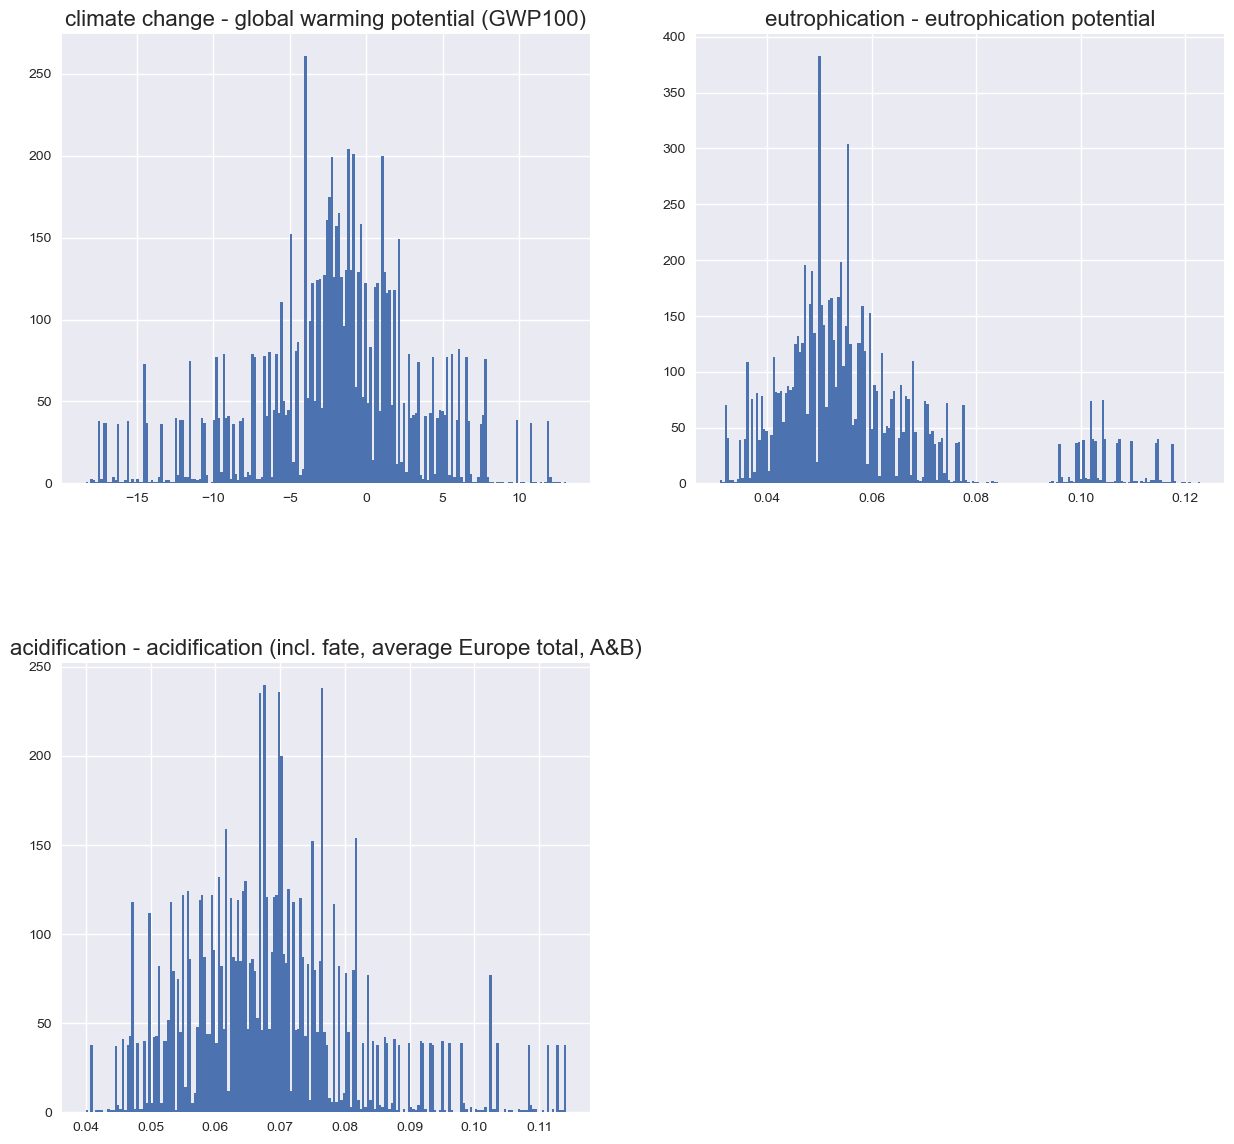

In [10]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [11]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=1000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.697774                     
 std                                              5.501821                     
 p                [-13.51039876523157, 6.0690175570364495]                     
 mean                                            -2.335347                     
 var                                              -2.35589                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053013          
 std                                              0.018012          
 p              [0.03818949029865521, 0.10528171052846247]          
 mean                                             0.057365          
 var                                              0.313986          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

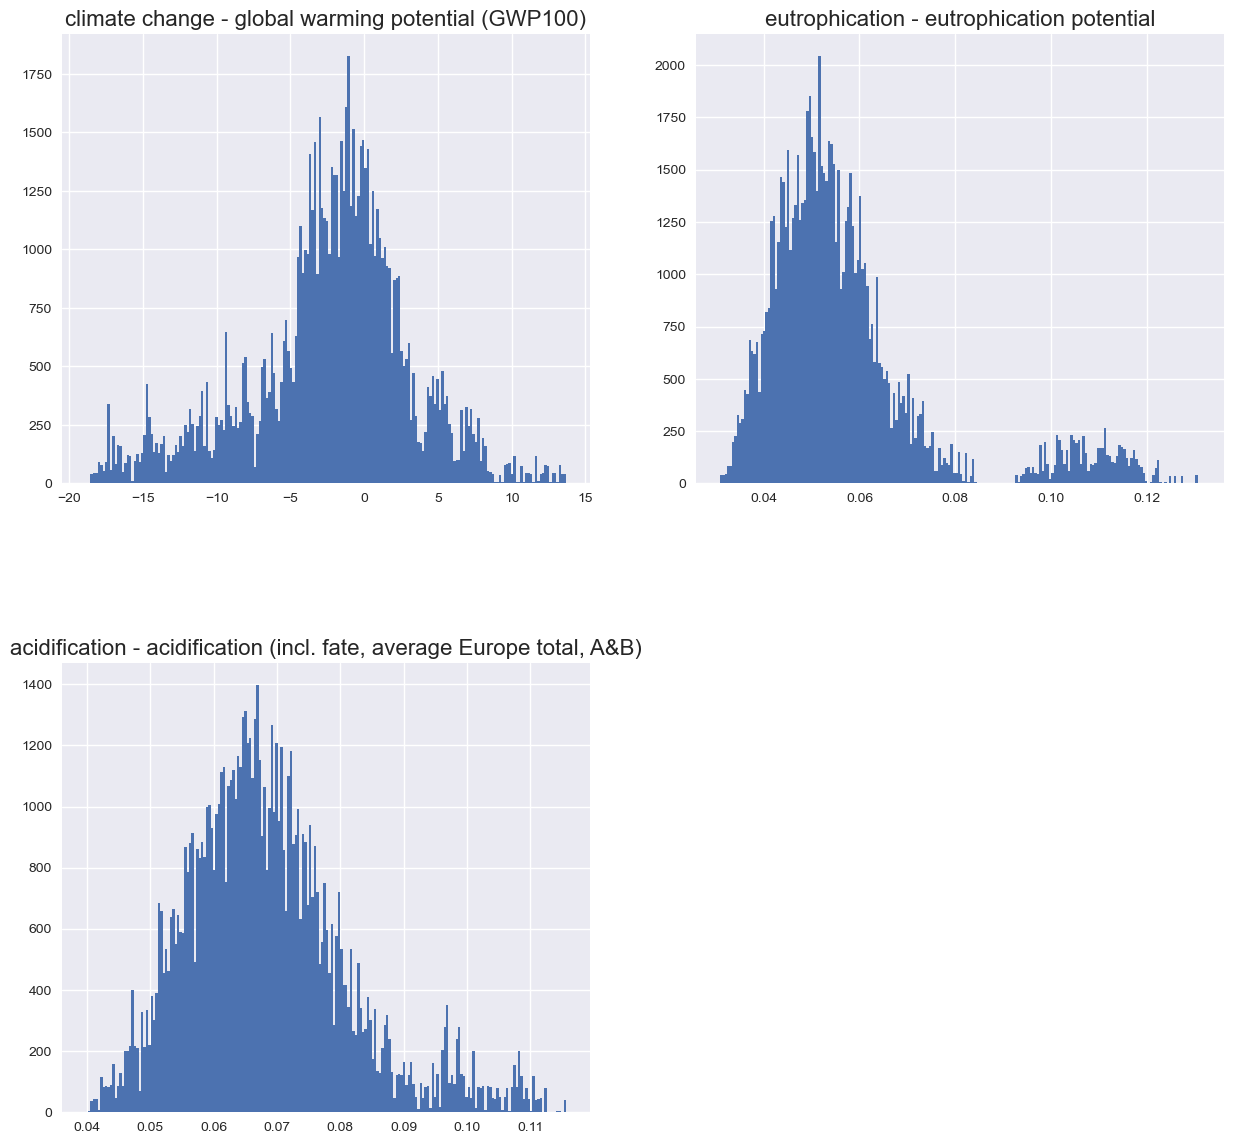

In [12]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [13]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=10000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.688509                     
 std                                              5.498122                     
 p                [-13.286471674732242, 6.273297889720073]                     
 mean                                            -2.307045                     
 var                                             -2.383188                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053181          
 std                                              0.018069          
 p              [0.03841604606010268, 0.10617843610169861]          
 mean                                             0.057456          
 var                                              0.314485          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

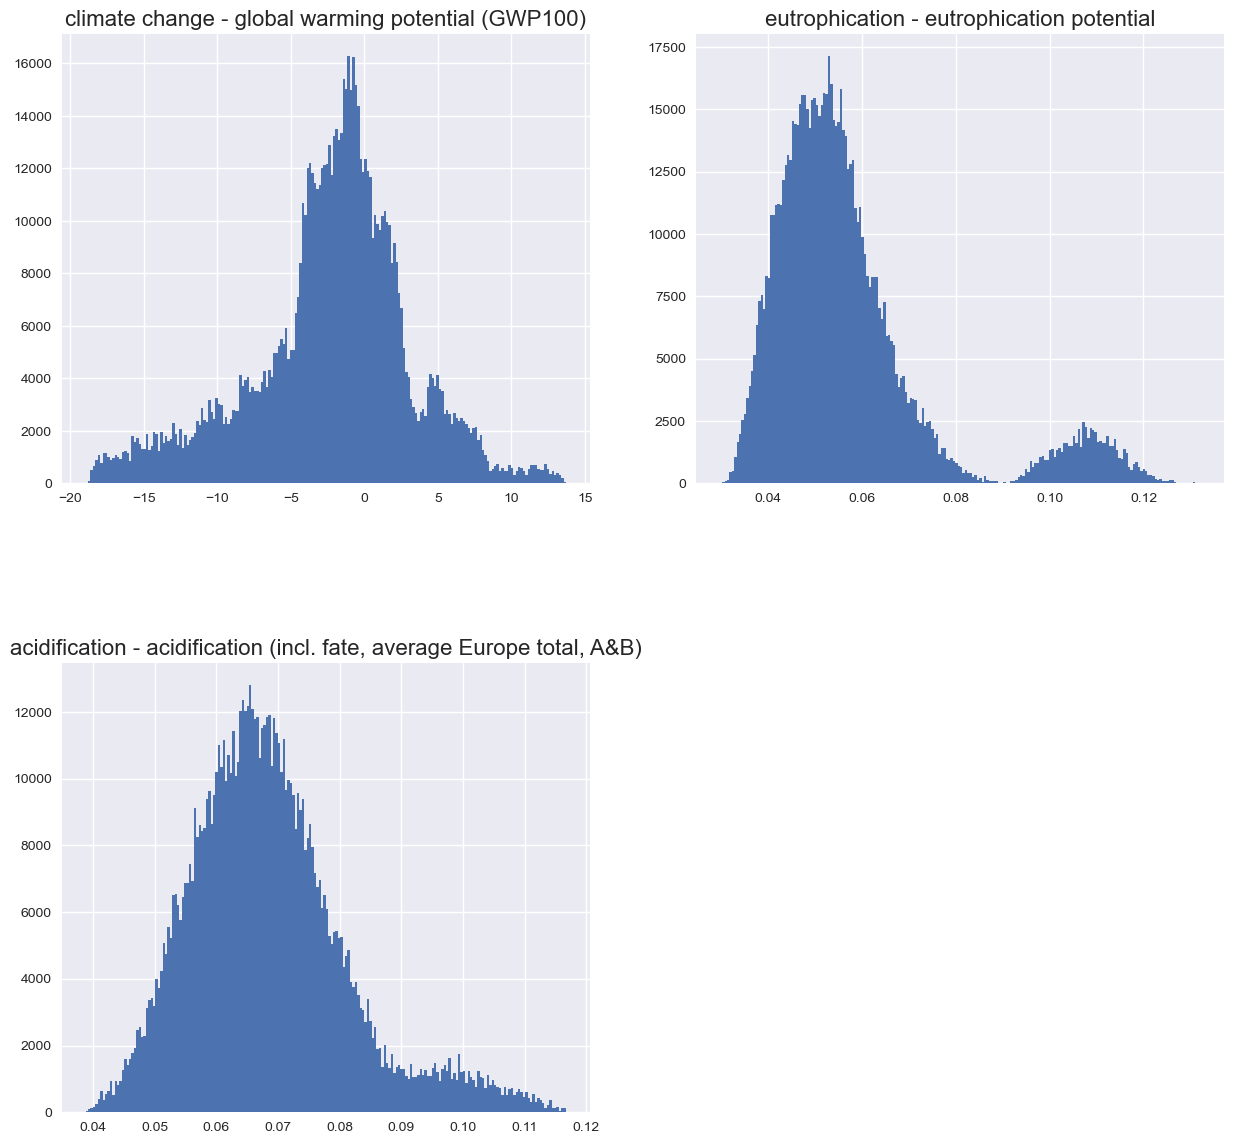

In [14]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [15]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=20000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (20000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


(       climate change - global warming potential (GWP100) [kg CO2-Eq / kWh]  \
 median                                          -1.688861                     
 std                                              5.497546                     
 p                [-13.346806173778957, 6.276850257941547]                     
 mean                                            -2.312894                     
 var                                             -2.376913                     
 
        eutrophication - eutrophication potential [kg N-Eq / kWh]  \
 median                                           0.053129          
 std                                              0.018031          
 p             [0.038465260834262015, 0.10585492458756876]          
 mean                                             0.057443          
 var                                              0.313897          
 
        acidification - acidification (incl. fate, average Europe total, A&B) [kg SO2-Eq / kWh]  
 med

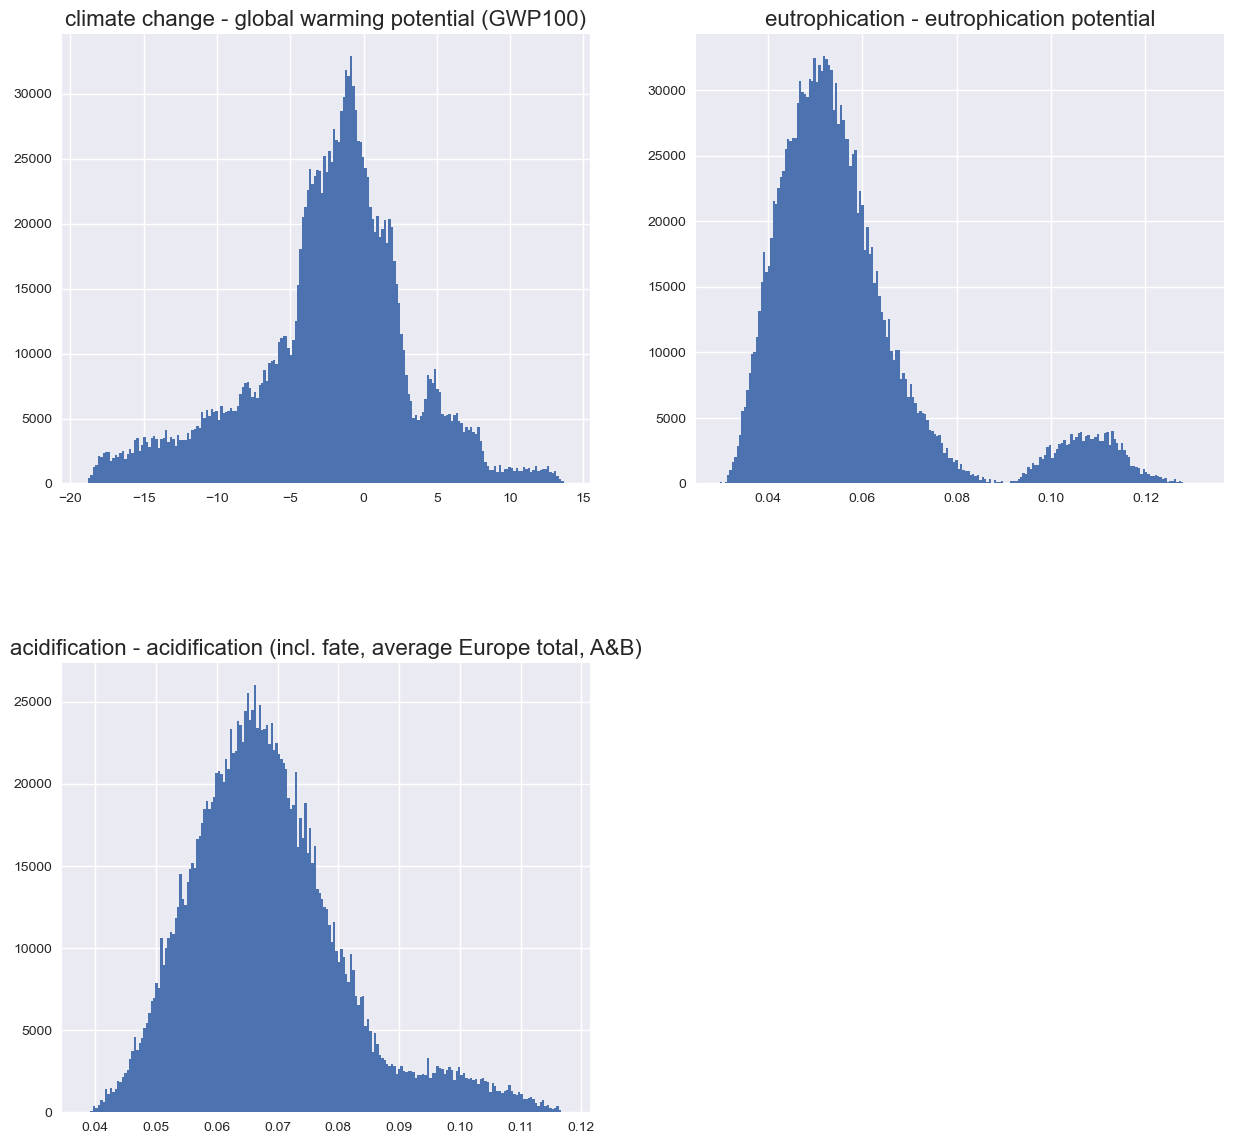

In [16]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)

In [ ]:
problem1, params, Y3 = _stochastics(BCBed_Sensitive, all_methods, n=100000) # change n

Generating samples ...


C:\Users\lizn0001\Anaconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount
Error while parsing formula 'CORINE 122b' : backing to amount
Error while parsing formula 'CORINE 31b1' : backing to amount


In [ ]:
distrib(
    BCBed_Sensitive, all_methods, Y=Y3,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2)